<span style="font-size: 24pt; font-weight: bold;">Can yellow cards for football players be predicted?</span>



This notebook is part of my university project on predicting yellow cards for football players. I am using various libraries that provide tools and functions necessary for data analysis, visualization, optimization, and many other applications.

To fully utilize the capabilities, I import several libraries that are essential for my project. Here are some of them:

In [924]:

from xgboost import XGBRegressor
import xgboost as xgb

from lightgbm import LGBMRegressor
import lightgbm as lgb

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures


from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Let's load the necessary player data and see what they contain.

In [925]:
players = pd.read_csv('all_players_2021_2022.csv')

players['Pos'] = players['Pos'].astype(str)

players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3425 entries, 0 to 3424
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  3425 non-null   object 
 1   Pos     3425 non-null   object 
 2   Age     3425 non-null   float64
 3   MP      3425 non-null   int64  
 4   Min     3425 non-null   float64
 5   90s     3425 non-null   float64
 6   Gls     3425 non-null   float64
 7   Ast     3425 non-null   float64
 8   CrdY    3425 non-null   float64
 9   CrdR    3425 non-null   float64
 10  xG      3425 non-null   float64
 11  Gls/90  3425 non-null   float64
 12  Ast/90  3425 non-null   float64
 13  xG/90   3425 non-null   float64
 14  2CrdY   3425 non-null   float64
 15  Fls     3425 non-null   float64
 16  Fld     3425 non-null   float64
 17  Off     3425 non-null   float64
 18  Crs     3425 non-null   float64
 19  Int     3425 non-null   float64
 20  TklW    3425 non-null   float64
 21  Recov   3425 non-null   float64
 22  

In [926]:
players.head()

Player    Pos   Age  MP     Min   90s   Gls   Ast  CrdY  CrdR  \
0    Thomas Müller     MF  31.0  32  2558.0  28.4   8.0  18.0   0.0   0.0   
1     Manuel Neuer     GK  35.0  28  2510.0  27.9   0.0   0.0   0.0   0.0   
2   Joshua Kimmich     MF  26.0  28  2474.0  27.5   3.0   9.0   4.0   0.0   
3  Dayot Upamecano     DF  22.0  28  2211.0  24.6   1.0   6.0   4.0   0.0   
4     Serge Gnabry  DF,FW  26.0  34  2185.0  24.3  14.0   5.0   0.0   0.0   

   ...  2CrdY   Fls   Fld   Off    Crs   Int  TklW  Recov  Won%           club  
0  ...    0.0  11.0  22.0  12.0   89.0  15.0  20.0   94.0  35.6  bayern munich  
1  ...    0.0   0.0   1.0   0.0    0.0   0.0   1.0   85.0  71.4  bayern munich  
2  ...    0.0  20.0  46.0   1.0  181.0  52.0  20.0  218.0  47.1  bayern munich  
3  ...    0.0  28.0  11.0   1.0    2.0  32.0  42.0  249.0  59.0  bayern munich  
4  ...    0.0  11.0  21.0  15.0   79.0  14.0  31.0  146.0  20.6  bayern munich  

[5 rows x 24 columns]

As we can see, we have a lot of statistics regarding the players. 

These are players from the top 7 European leagues. Below are the data regarding the number of players in each position.

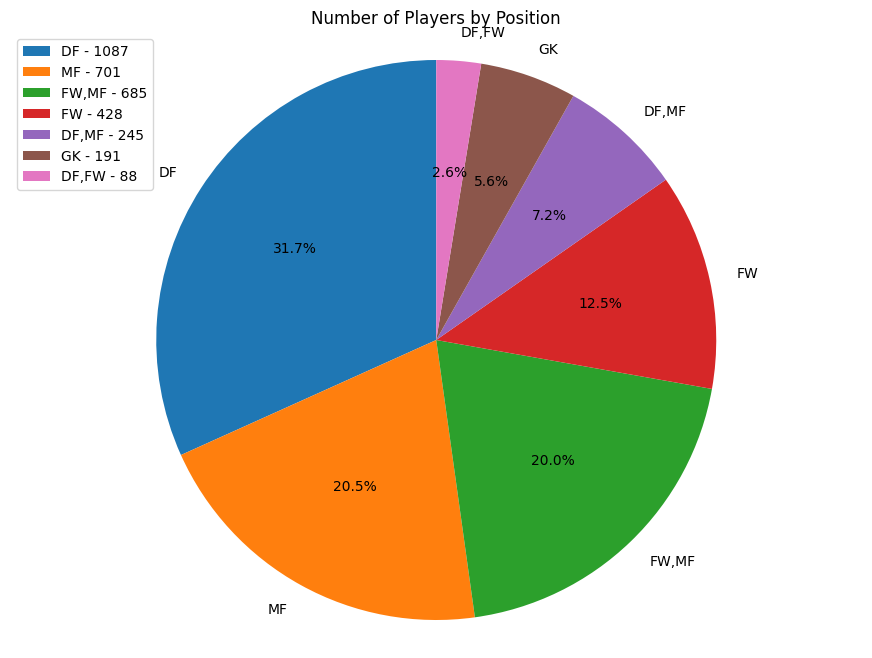

<Figure size 640x480 with 0 Axes>

In [927]:

import matplotlib.pyplot as plt

# Calculating the number of players for each position
position_counts = players['Pos'].value_counts()

# Creating a pie chart
plt.figure(figsize=(11, 8))
patches, texts, autotexts = plt.pie(position_counts, labels=position_counts.index, autopct='%1.1f%%', startangle=90)

# Creating a legend with expanded position names
legend_labels = [f'{pos} - {position_counts[pos]}' for pos in position_counts.index]
plt.legend(patches, legend_labels, loc='upper left')

plt.title("Number of Players by Position")
plt.axis('equal')  # Setting equal aspect ratio for X and Y axes
plt.show()

plt.savefig('./diagrams/position_players.png')


Let's check which clubs have the most and least number of players. Here they are:

In [928]:
club_counts = players['club'].value_counts()

club_with_most_players = club_counts.idxmax()
most_players_count = club_counts.max()

club_with_least_players = club_counts.idxmin()
least_players_count = club_counts.min()


print("The club with the most players:",
      club_with_most_players.capitalize(), f'({most_players_count})')
print("The club with the fewest players:",
      club_with_least_players.capitalize(), f'({least_players_count})')

The club with the most players: Genoa (32)
The club with the fewest players: Nec nijmegen (16)


Now let's move on to presenting statistics more relevant to the topic of my project. Below are the top 10 players with the highest number of yellow cards in the 2021/22 season.

In [929]:
total_yellow_cards = players.groupby(['Player', 'Pos', 'club'])['CrdY'].sum()
total_yellow_cards = total_yellow_cards.sort_values(ascending=False)
top_10_table = pd.DataFrame(total_yellow_cards.head(10))
top_10_table.reset_index(inplace=True)
top_10_table.index = range(1, len(top_10_table) + 1)
top_10_table.columns = ['Player', 'Position', 'Club', 'TotalYellowCards']

print("Top 10 players with the most yellow cards  in the 2021/22 season:")
top_10_table

Top 10 players with the most yellow cards  in the 2021/22 season:


Player Position                 Club  TotalYellowCards
1     Gianluca Mancini       DF                 roma              16.0
2        Omar Alderete       DF             valencia              15.0
3          Matt Crooks       MF        middlesbrough              15.0
4         Maxime Lopez       MF             sassuolo              14.0
5        Gustavo Hamer       MF        coventry city              14.0
6            Sam Field       MF  queens park rangers              14.0
7         Ethan Ampadu    DF,MF              venezia              13.0
8         Nathan Byrne       DF         derby county              13.0
9         Jordan Ferri       MF          montpellier              13.0
10  Geoffrey Kondogbia    DF,MF      atletico madrid              13.0

In [930]:
players['CrdY/90'] = players['CrdY'] / players['90s']
yellow_cards_per_90 = players.groupby(['Player', 'Pos', 'club'])['CrdY/90'].mean()
yellow_cards_per_90 = yellow_cards_per_90.sort_values(ascending=False)
top_10_table = pd.DataFrame(yellow_cards_per_90.head(10))
top_10_table.reset_index(inplace=True)
top_10_table.index = range(1, len(top_10_table) + 1)
top_10_table.columns = ['Player', 'Position', 'Club', 'YellowCardsPer90']

print("Top 10 players with the most yellow cards per 90 minutes in the 2021/22 season:")
top_10_table

Top 10 players with the most yellow cards per 90 minutes in the 2021/22 season:


Player Position           Club  YellowCardsPer90
1          Béni Makouana    FW,MF    montpellier          1.111111
2         Nikola Kalinić       FW  hellas verona          1.111111
3      Aleksandar Sedlar    DF,MF       mallorca          1.111111
4   Kevin-Prince Boateng    FW,MF     hertha bsc          1.038961
5          David Tavares       MF      famalicao          1.000000
6           Ilaix Moriba       MF       valencia          0.989011
7            José Fontán       DF     celta vigo          0.967742
8        Roberto Soldado       FW        levante          0.945946
9           Tiago Araújo    DF,FW         arouca          0.943396
10         Kévin Malcuit    DF,MF         napoli          0.937500

Below are the top 10 players with the highest number of fouls in season 2021/2022.

In [931]:
most_fouling_players = players.groupby(['Player', 'Pos', 'club'])['Fls'].sum()
most_fouling_players = most_fouling_players.sort_values(ascending=False)
top_10_table = pd.DataFrame(most_fouling_players.head(10))
top_10_table.reset_index(inplace=True)
top_10_table.index = range(1, len(top_10_table) + 1)
top_10_table.columns = ['Player', 'Position', 'Club','TotalFouls']

print("Top 10 players with the most fouls committed in the 2021/22 season:")
top_10_table

Top 10 players with the most fouls committed in the 2021/22 season:


Player Position            Club  TotalFouls
1     Morten Thorsby       MF       sampdoria        81.0
2          Enes Ünal       FW          getafe        77.0
3             Otávio    FW,MF           porto        77.0
4     Elijah Adebayo       FW      luton town        76.0
5       Brais Méndez       MF      celta vigo        75.0
6   Sebastian Polter       FW          bochum        75.0
7     Tommaso Pobega       MF          torino        75.0
8        Dani de Wit    FW,MF      az alkmaar        72.0
9     Hugo Guillamón    DF,MF        valencia        71.0
10      Fran Navarro       FW  gil vicente fc        70.0

In [932]:
players['Fls/90'] = players['Fls'] / players['90s']
fouls_per_90 = players.groupby(['Player', 'Pos', 'club'])['Fls/90'].mean()
fouls_per_90 = fouls_per_90.sort_values(ascending=False)
top_10_table = pd.DataFrame(fouls_per_90.head(10))
top_10_table.reset_index(inplace=True)
top_10_table.index = range(1, len(top_10_table) + 1)
top_10_table.columns = ['Player', 'Position', 'Club' ,'FoulsPer90']

print("Top 10 players with the most fouls committed per 90 minutes in the 2021/22 season:")
top_10_table

Top 10 players with the most fouls committed per 90 minutes in the 2021/22 season:


Player Position            Club  FoulsPer90
1          Yan Brice Eteki       MF         granada    4.736842
2                Tom Eaves       FW       hull city    4.214286
3           Martin Adeline    FW,MF           reims    4.102564
4              Julio Romão    DF,MF     santa clara    4.000000
5                   Monchu       MF         granada    3.918919
6            Youssef Maleh       MF      fiorentina    3.805310
7   Jean-Daniel Akpa-Akpro       MF           lazio    3.714286
8                   Safira       FW  belenenses sad    3.664596
9              Diego Demme       MF          napoli    3.636364
10           David Tavares       MF       famalicao    3.600000

Below are statistics on the average number of yellow cards given by players, depending on their position:

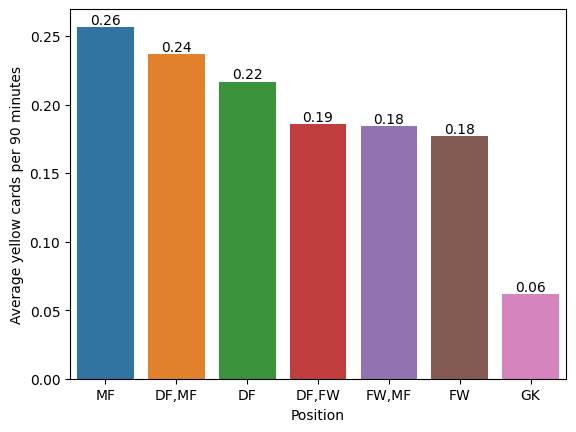

In [933]:
def add_diagram_bar_values(precision=2):
    for i, bar in enumerate(plt.gca().patches):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(round(bar.get_height(), precision)),
                ha='center', va='bottom')



position_crdY = players.groupby(['Pos'])['CrdY/90'].mean().reset_index().sort_values(ascending=False, by='CrdY/90')
sns.barplot(x = 'Pos',y='CrdY/90',data=position_crdY)     
plt.xlabel('Position')
plt.ylabel('Average yellow cards per 90 minutes')

add_diagram_bar_values()

plt.savefig('./diagrams/average_yellow_card_per_position.png')

Here we present data on the relationship between 3 statistics: the number of minutes played by a player, the number of cards he has scored and fouls committed. 

As you can see, it's VERY dense here:

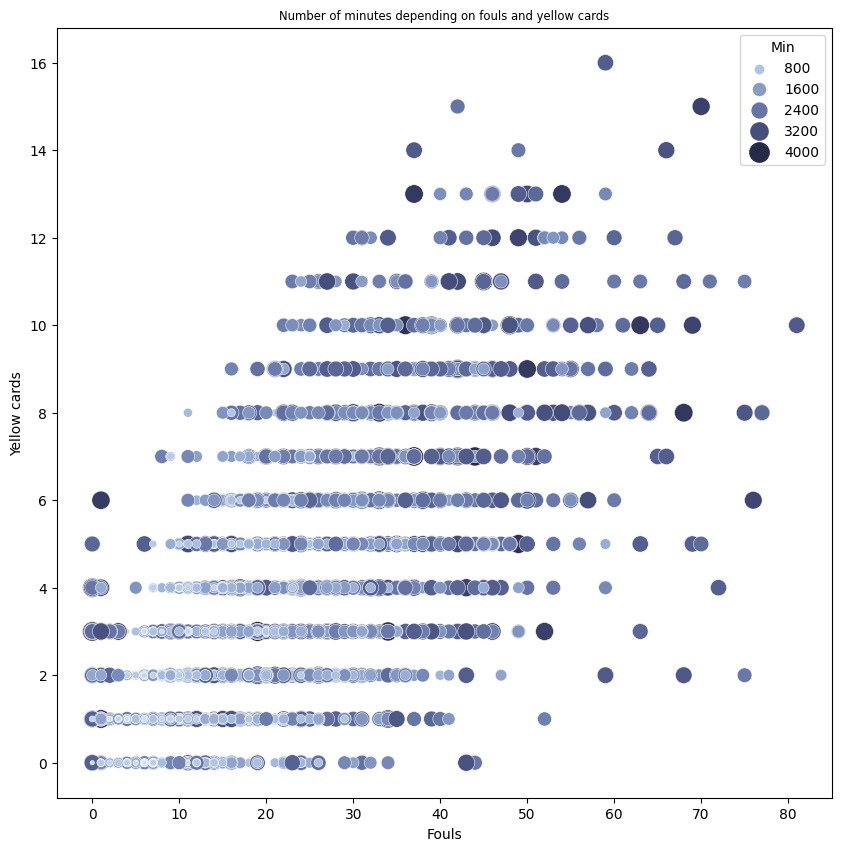

<Figure size 640x480 with 0 Axes>

In [934]:
plt.figure(figsize=(10,10))
cmap = sns.cubehelix_palette(rot=-.1, as_cmap=True)
ax = sns.scatterplot(x="Fls", y="CrdY",  hue="Min", size ="Min",
                     palette=cmap, sizes=(10, 200), data=players)
plt.xlabel("Fouls")
plt.ylabel("Yellow cards")
ax.set_title('Number of minutes depending on fouls and yellow cards', {'fontsize': 'small'})
plt.show()
plt.savefig('./diagrams/minutes_yellow_cards_fouls.png')

To facilitate the work and analysis of the data, a diagram showing the correlation between individual statistics of players has been generated below. The correlation values belong to the range <-1;1>. 

If the correlation value between two attributes is close to 1, then they are directly proportional to each other - if one value increases, so does the other. 

If the correlation value between two attributes is close to -1, then they are inversely proportional to each other - if one value increases, the other decreases and vice versa. 

And when it is 0, the attributes are totally independent of each other. 

C:\Users\trine\AppData\Local\Temp\ipykernel_18260\1590348859.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(players.corr(),linewidths=.5, annot=True );


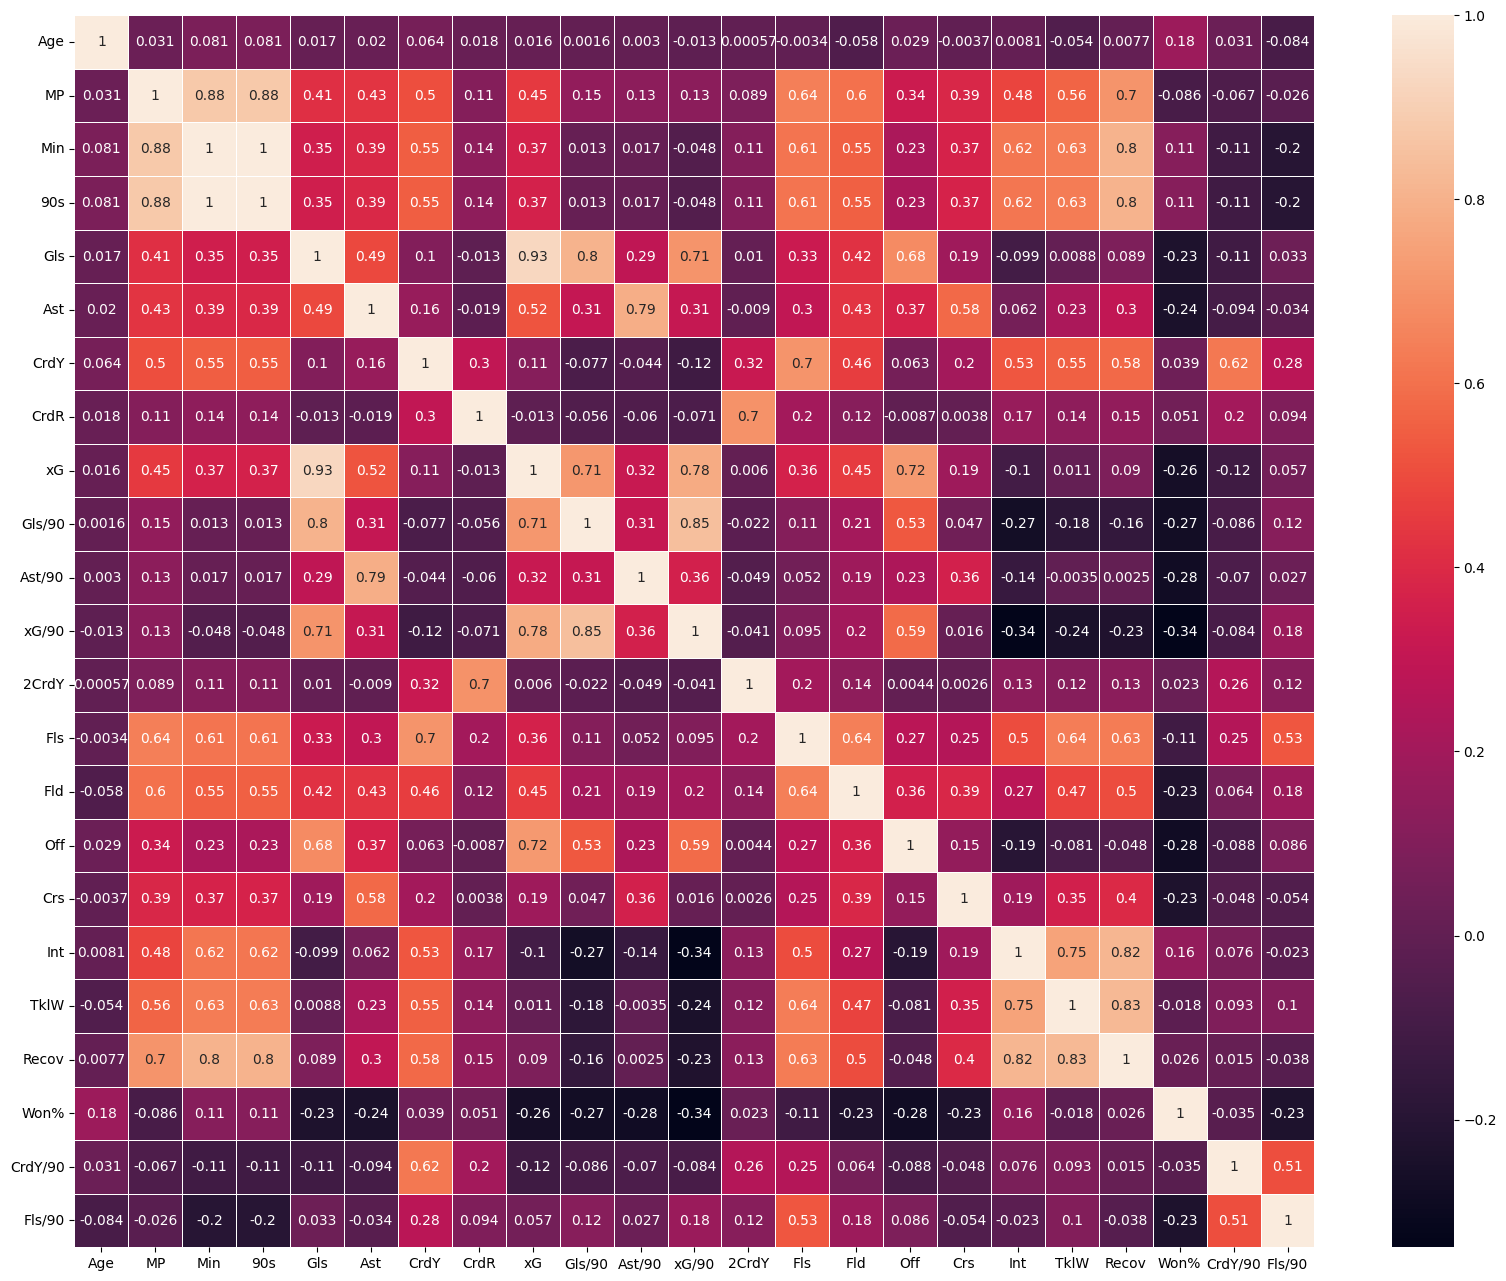

<Figure size 640x480 with 0 Axes>

In [935]:
plt.figure(figsize=(20,16))
sns.heatmap(players.corr(),linewidths=.5, annot=True );
plt.yticks(rotation=360)
plt.show()

plt.savefig('./diagrams/coefficients_matrix.png')

Now there are graphs showing the average number of yellow and red cards by age group of players in the 2021/22 season

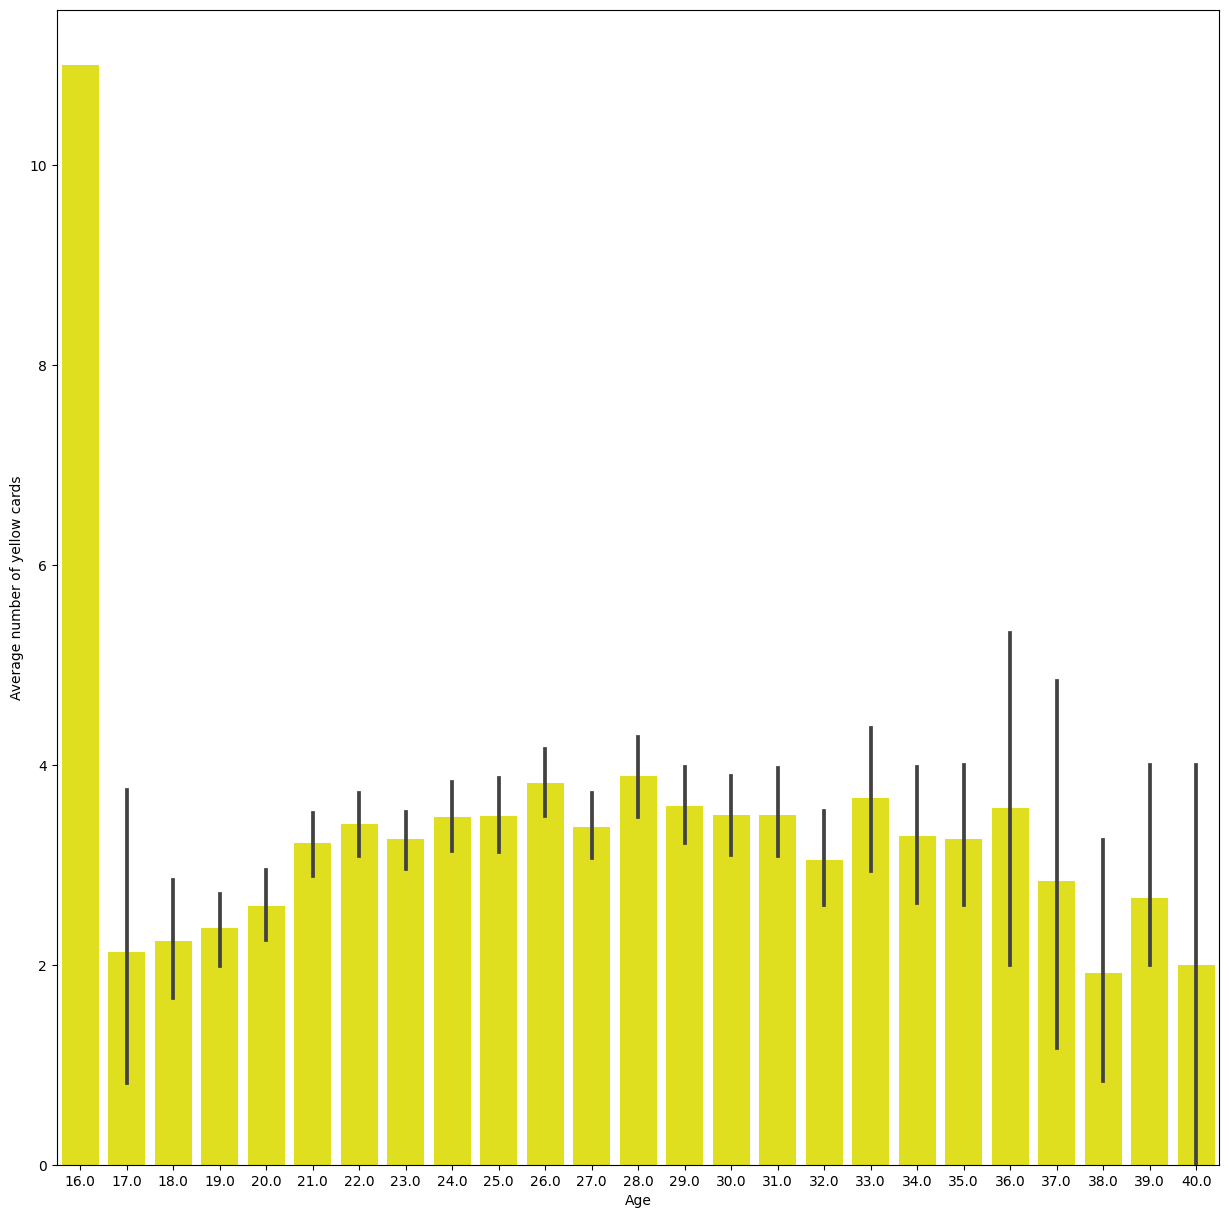

<Figure size 640x480 with 0 Axes>

In [936]:
plt.figure(figsize=(15,15))
sns.barplot(x = 'Age',y='CrdY',data=players, color='yellow')
plt.xlabel('Age')
plt.ylabel('Average number of yellow cards')

plt.show()

plt.savefig('./diagrams/mean_yellow_cards_per_age.png')

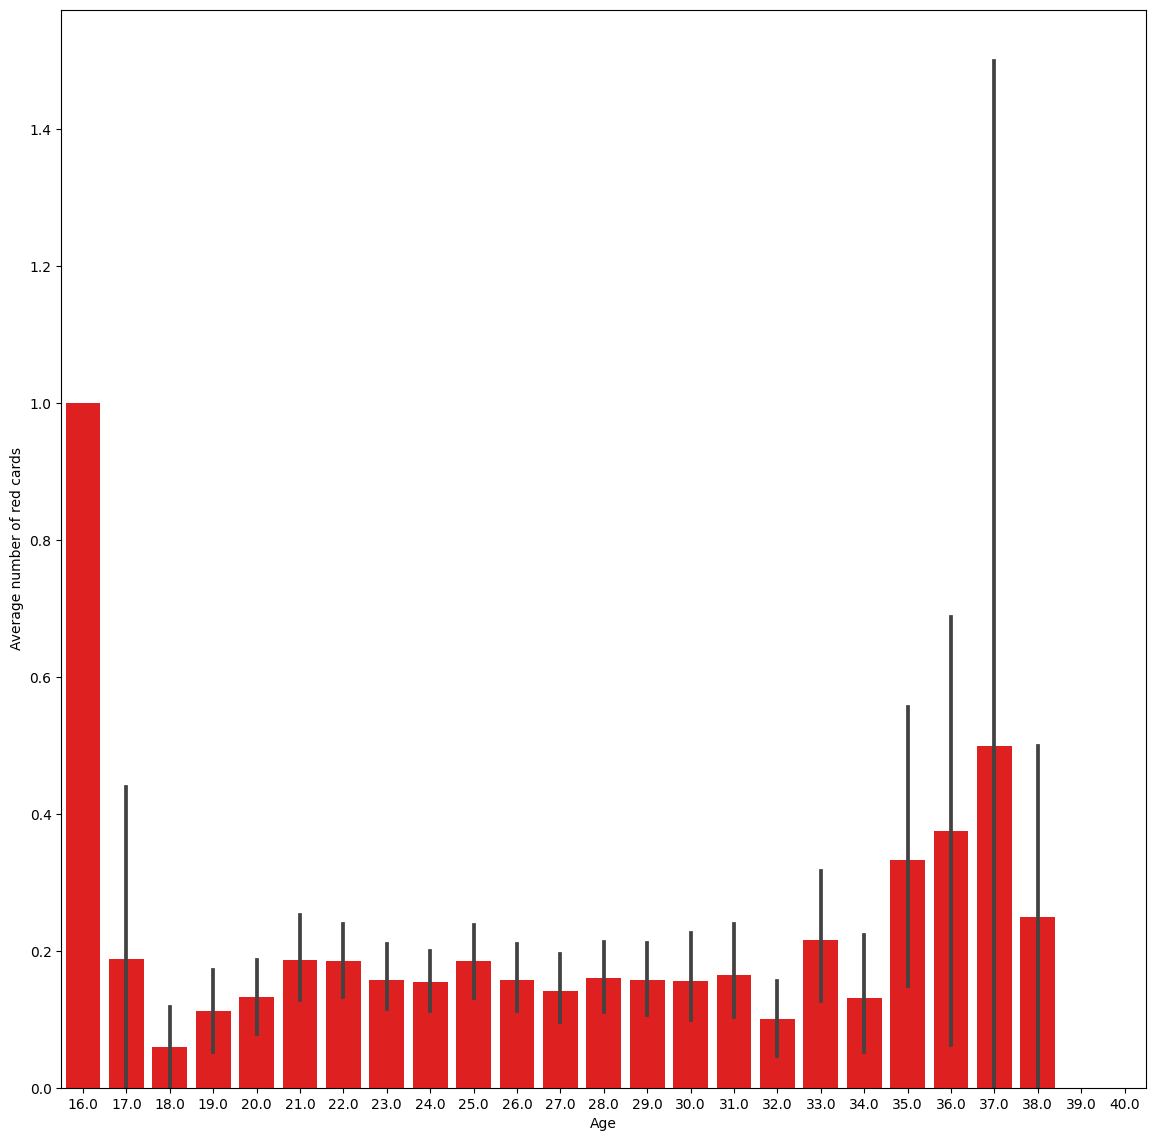

<Figure size 640x480 with 0 Axes>

In [937]:
plt.figure(figsize=(14,14))
sns.barplot(x = 'Age',y='CrdR',data=players, color='red')
plt.xlabel('Age')
plt.ylabel('Average number of red cards')

plt.show()
plt.savefig('./diagrams/mean_red_cards_per_age.png')

To experiment a bit and find some dependencies, let's check that the number of matches played affects the number of yellow and red cards scored per 90 minutes by players in given positions.

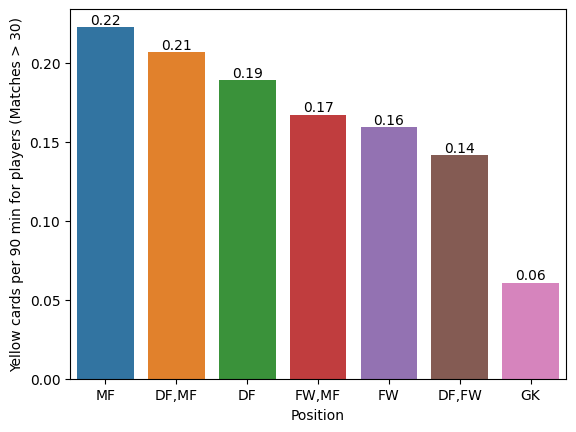

<Figure size 640x480 with 0 Axes>

In [938]:
pos_crdY = players[players['MP']>30].groupby(['Pos'])['CrdY/90'].mean().reset_index()
pos_crdY = pos_crdY.sort_values(by='CrdY/90', ascending=False)
sns.barplot(x = 'Pos',y='CrdY/90',data=pos_crdY)     
plt.xlabel('Position')
plt.ylabel('Yellow cards per 90 min for players (Matches > 30)')

add_diagram_bar_values()
plt.show()

plt.savefig('./diagrams/mean_yellow_cards_per_position_30.png')

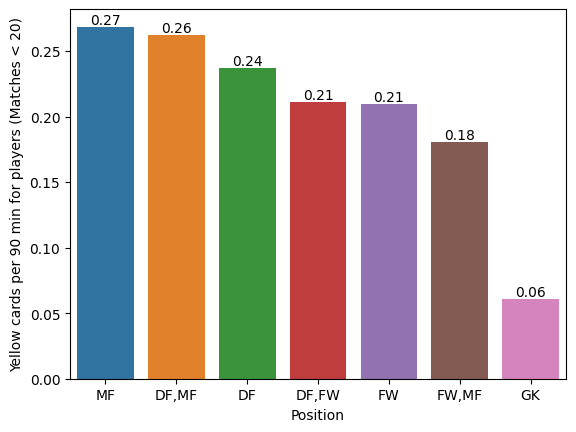

<Figure size 640x480 with 0 Axes>

In [939]:
pos_crdY = players[players['MP']<20].groupby(['Pos'])['CrdY/90'].mean().reset_index()
pos_crdY = pos_crdY.sort_values(by='CrdY/90', ascending=False)
sns.barplot(x = 'Pos',y='CrdY/90',data=pos_crdY)     
plt.xlabel('Position')
plt.ylabel('Yellow cards per 90 min for players (Matches < 20)')

add_diagram_bar_values()
plt.show()

plt.savefig('./diagrams/mean_yellow_cards_per_position_20.png')

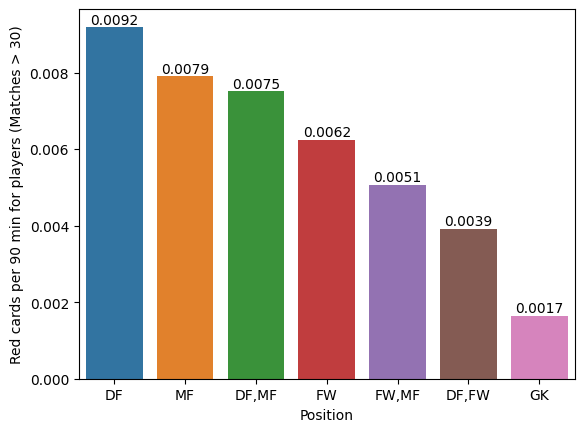

<Figure size 640x480 with 0 Axes>

In [940]:
players['CrdR/90'] = players['CrdR'] / players['90s']
pos_crdR = players[players['MP']>30].groupby(['Pos'])['CrdR/90'].mean().reset_index()
pos_crdR = pos_crdR.sort_values(by='CrdR/90', ascending=False)
sns.barplot(x = 'Pos',y='CrdR/90',data=pos_crdR)     
plt.xlabel('Position')
plt.ylabel('Red cards per 90 min for players (Matches > 30)')

add_diagram_bar_values(4)
plt.show()

plt.savefig('./diagrams/mean_red_cards_per_position_30.png')


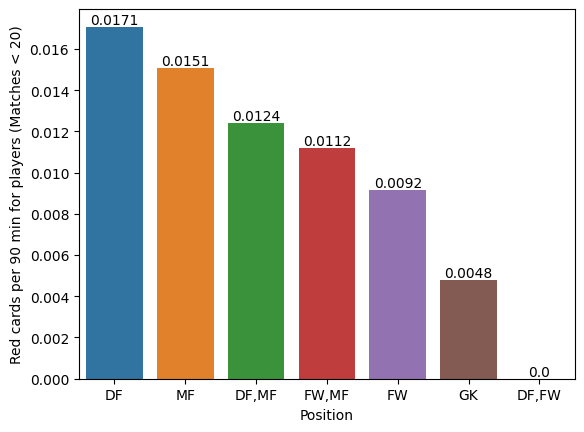

<Figure size 640x480 with 0 Axes>

In [941]:
pos_crdR = players[players['MP']<20].groupby(['Pos'])['CrdR/90'].mean().reset_index()
pos_crdR = pos_crdR.sort_values(by='CrdR/90', ascending=False)
sns.barplot(x = 'Pos',y='CrdR/90',data=pos_crdR)     
plt.xlabel('Position')
plt.ylabel('Red cards per 90 min for players (Matches < 20)')

add_diagram_bar_values(4)
plt.show()

plt.savefig('./diagrams/mean_red_cards_per_position_20.png')

As you can see, players who have played fewer matches get yellow and red cards more often. Only goalkeepers receive the same number of yellow cards on average.


We are slowly moving on to the main calculations. Since we want to predict the number of yellow cards scored, regression is a better model for this. Let's check how the data on the cards highlighted in the list of attributes are presented. This list contains abbreviations of attribute names. Their full names are as follows:

+ Age - player's age
+ MP - number of matches played
+ Min - minutes played
+ 90s - number of 90 minutes played
+ Gls - number of goals scored
+ Ast - number of assists scored
+ xG - number of expected goals
+ Gls/90 - number of goals scored per 90 minutes
+ Ast/90 - number of assists scored per 90 minutes
+ xG/90 - number of expected goals per 90 minutes
+ Fls - number of fouls committed
+ Fld - number of fouls drawn
+ Fls/90 - number of fouls committed per 90 minutes
+ Off - number of offsides
+ Crs - number of crosses (medium- to-long-range pass from a wide area of the field towards the centre of the field near the opponent's goal)
+ Int - number of interceptions (the catching of a pass by a player on an opposing team)
+ TklW - number of tackles in which the tackler's team won possession of the ball
+ Recov - number of loose balls recovered
+ Won% - percentage of aerials won


In [942]:
x_features = ['Age','MP','Min','90s','Gls','Ast','xG','Gls/90','Ast/90','xG/90','Fls','Fld', 'Fls/90','Off','Crs','Int','TklW','Recov','Won%'] 

X = players.reindex(columns=x_features)

y = players.loc[:,"CrdY"]

model = sm.OLS(y, X, data=players)
results = model.fit()
results.summary()


c:\Users\trine\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   CrdY   R-squared (uncentered):                   0.820
Model:                            OLS   Adj. R-squared (uncentered):              0.819
Method:                 Least Squares   F-statistic:                              817.0
Date:                Fri, 09 Jun 2023   Prob (F-statistic):                        0.00
Time:                        14:49:59   Log-Likelihood:                         -6974.0
No. Observations:                3425   AIC:                                  1.399e+04
Df Residuals:                    3406   BIC:                                  1.410e+04
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age            0.0181      0.006      3.237      0.001       0.007       0.029
MP            -0.0241      0.008     -2.888      0.004      -0.040      -0.008
Min           -0.0074      0.013     -0.585      0.559      -0.032       0.017
90s            0.7373      1.140      0.647      0.518      -1.499       2.973
Gls            0.0154      0.043      0.358      0.720      -0.069       0.100
Ast            0.0315      0.038      0.838      0.402      -0.042       0.105
xG            -0.1435      0.051     -2.796      0.005      -0.244      -0.043
Gls/90        -0.0146      0.599     -0.024      0.981      -1.189       1.160
Ast/90        -0.6604      0.583     -1.133      0.257      -1.803       0.482
xG/90         -0.3697      0.719     -0.514      0.607      -1.779       1.040
Fls            0.1264      0.006     21.540      0.000       0.115       0.138
Fld            0.0100      0.003      3.294      0.001       0.004       0.016
Fls/90         0.0027      0.085      0.032      0.974      -0.164       0.169
Off           -0.0159      0.010     -1.581      0.114      -0.036       0.004
Crs        -5.535e-05      0.001     -0.051      0.959      -0.002       0.002
Int            0.0255      0.004      6.202      0.000       0.017       0.034
TklW          -0.0086      0.005     -1.676      0.094      -0.019       0.001
Recov         -0.0028      0.001     -1.886      0.059      -0.006       0.000
Won%          -0.0006      0.002     -0.303      0.762      -0.004       0.003
==============================================================================
Omnibus:                      222.698   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              346.848
Skew:                           0.526   Prob(JB):                     4.82e-76
Kurtosis:                       4.151   Cond. No.                     6.31e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [943]:
y = players.loc[:,"CrdY/90"]
model = sm.OLS(y, X, data=players)
results = model.fit()
results.summary()

c:\Users\trine\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                CrdY/90   R-squared (uncentered):                   0.735
Model:                            OLS   Adj. R-squared (uncentered):              0.733
Method:                 Least Squares   F-statistic:                              497.0
Date:                Fri, 09 Jun 2023   Prob (F-statistic):                        0.00
Time:                        14:49:59   Log-Likelihood:                          2014.6
No. Observations:                3425   AIC:                                     -3991.
Df Residuals:                    3406   BIC:                                     -3875.
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age            0.0031      0.000      7.547      0.000       0.002       0.004
MP            -0.0008      0.001     -1.312      0.190      -0.002       0.000
Min           -0.0013      0.001     -1.390      0.165      -0.003       0.001
90s            0.1146      0.083      1.387      0.166      -0.047       0.277
Gls            0.0031      0.003      1.000      0.317      -0.003       0.009
Ast            0.0014      0.003      0.503      0.615      -0.004       0.007
xG            -0.0016      0.004     -0.441      0.659      -0.009       0.006
Gls/90        -0.0274      0.043     -0.630      0.529      -0.112       0.058
Ast/90        -0.0433      0.042     -1.024      0.306      -0.126       0.040
xG/90         -0.1367      0.052     -2.624      0.009      -0.239      -0.035
Fls           -0.0005      0.000     -1.264      0.206      -0.001       0.000
Fld            0.0007      0.000      2.963      0.003       0.000       0.001
Fls/90         0.1362      0.006     22.145      0.000       0.124       0.148
Off           -0.0014      0.001     -1.885      0.059      -0.003    5.52e-05
Crs        -2.629e-07   7.87e-05     -0.003      0.997      -0.000       0.000
Int            0.0012      0.000      3.898      0.000       0.001       0.002
TklW          -0.0002      0.000     -0.536      0.592      -0.001       0.001
Recov         -0.0001      0.000     -1.132      0.258      -0.000    8.92e-05
Won%        8.951e-05      0.000      0.624      0.533      -0.000       0.000
==============================================================================
Omnibus:                      500.473   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1337.461
Skew:                           0.796   Prob(JB):                    3.75e-291
Kurtosis:                       5.615   Cond. No.                     6.31e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now let's load specially prepared test data of players from another season.

Let's also check the amount and numerical ratio to the current training data.

In [944]:
test_players = pd.read_csv('test_2022_2023.csv')
test_players['Age'] = test_players['Age'].str[:2].astype(int)
test_players['Fls/90'] = test_players['Fls']/test_players['90s']
print(players.shape)
print(test_players.shape)
print("{:.2f}".format(test_players.shape[0]/(test_players.shape[0]+players.shape[0])))




(3425, 27)
(858, 25)
0.20


As you can see, unfortunately, our initial data do not have any major dependencies. However, let's try to figure it out and find a model that will show us whether it is possible to unambiguously answer the question asked in our hypothesis

As our features used to predict yellow cards per 90 minutes, the following were selected:
+ Age - player's age
+ Fls/90 - number of fouls committed per 90 minutes
+ 90s - number of 90 minutes played
+ Gls/90 - number of goals scored per 90 minutes
+ TklW - number of tackles in which the tackler's team won possession of the ball
+ Int - number of interceptions (the catching of a pass by a player on an opposing team)

They were chosen because they seem to me, as a football fan, to have the greatest influence on the game and behavior of the players

Let's start with the simplest regression model which is LinearRegression.


`LinearRegression` is a machine learning algorithm used for solving regression problems. It assumes a linear relationship between the independent variables and the target variable. The goal of `LinearRegression` is to find the best-fit line that minimizes the sum of the squared differences between the actual and predicted values.

In Python, the `scikit-learn` library provides an easy-to-use implementation of `LinearRegression`. It allows you to train a linear regression model by fitting it to a dataset with known input-output pairs. Once trained, the model can be used to make predictions on new data.

First, let's find the best polynomial degree for both the training and test data.


In [945]:
X_train, y_train = players[['Age', 'Fls/90' ,'90s', 'Gls/90', 'TklW', 'Int']], players[['CrdY/90']]


X_test, y_test = test_players[['Age', 'Fls/90' ,'90s', 'Gls/90', 'TklW', 'Int']], test_players['CrdY']/test_players['90s']


degrees = [2,3,4,5,6,7,8]
for degree in degrees:
    lr = LinearRegression()
    pol_feat = PolynomialFeatures(degree=degree, include_bias=False, interaction_only=False)

    model = lr.fit(pol_feat.fit_transform(X_train), y_train)

    print(f'R^2 for {degree} polynomial degree:')
    r_sqr = lr.score(pol_feat.fit_transform(X_train), y_train)
    print(f'Train r^2 = {r_sqr}')
    r_sqr = lr.score(pol_feat.fit_transform(X_test), y_test)
    print(f'Test r^2 = {r_sqr}')
    print('---------')



    


R^2 for 2 polynomial degree:
Train r^2 = 0.3066558083685973
Test r^2 = 0.3012091880918263
---------
R^2 for 3 polynomial degree:
Train r^2 = 0.3224737780596829
Test r^2 = 0.294227351285141
---------
R^2 for 4 polynomial degree:
Train r^2 = 0.35217616494387294
Test r^2 = 0.28816879166763076
---------
R^2 for 5 polynomial degree:
Train r^2 = 0.4025056564697467
Test r^2 = 0.1560022347924197
---------
R^2 for 6 polynomial degree:
Train r^2 = 0.4491209927724539
Test r^2 = -16.687128714386596
---------
R^2 for 7 polynomial degree:
Train r^2 = 0.5809277033322346
Test r^2 = -505.44356265185615
---------
R^2 for 8 polynomial degree:
Train r^2 = 0.714423821363342
Test r^2 = -101212.57251351075
---------


As can be seen, the higher the degree of the polynomial, the better the fit to the training data. Unfortunately, the results for the test data suffer from this, as they deteriorate significantly as the degree of the polynomial increases.

Therefore, all my further calculations for my data will be done for the second degree of the polynomial to make the results as comparable and reliable as possible.

Due to the number of characteristics according to which we want to predict yellow cards, it is not possible to present our data on the chart.

Graphs for more than 2 variables are unfeasible and hard to imagine for the human mind.

Now let's retrain to a model for normal LinearRegression.

In [946]:
lr = LinearRegression()

model1 = lr.fit(X_train, y_train)
print(f'coef = {lr.coef_}')
print(f'intercept a0 = {lr.intercept_}')

r_sqr = lr.score(X_train, y_train)
print(f'r^2 = {r_sqr}')



coef = [[ 0.00301918  0.12637597 -0.00132616 -0.11237664 -0.00019764  0.00118643]]
intercept a0 = [-0.00259398]
r^2 = 0.29129920466359804


Now let's make a prediction for our training data.

In [947]:
predictions_df = pd.DataFrame({
    'Player': players['Player'],
    'Age': players['Age'],
    'Fls/90': players['Fls/90'],
    '90s': players['90s'],
    'Gls/90': players['Gls/90'],
    'TklW': players['TklW'],
    'Int': players['Int'],
    'CrdY/90': players['CrdY/90'],
    'lr_p_CrdY/90': model1.predict(X_train).flatten()
})

predictions_df

Player   Age    Fls/90   90s  Gls/90  TklW   Int   CrdY/90  \
0       Thomas Müller  31.0  0.387324  28.4    0.28  20.0  15.0  0.000000   
1        Manuel Neuer  35.0  0.000000  27.9    0.00   1.0   0.0  0.000000   
2      Joshua Kimmich  26.0  0.727273  27.5    0.11  20.0  52.0  0.145455   
3     Dayot Upamecano  22.0  1.138211  24.6    0.04  42.0  32.0  0.162602   
4        Serge Gnabry  26.0  0.452675  24.3    0.58  31.0  14.0  0.000000   
...               ...   ...       ...   ...     ...   ...   ...       ...   
3420  Luca Fiordilino  25.0  0.684932   7.3    0.00  13.0  11.0  0.273973   
3421       Dor Peretz  26.0  1.538462   6.5    0.00  18.0   8.0  0.307692   
3422  Francesco Forte  28.0  2.340426   4.7    0.21   2.0   0.0  0.638298   
3423     Marco Modolo  32.0  1.363636   4.4    0.00   3.0   4.0  0.454545   
3424             Nani  34.0  0.625000   3.2    0.00   1.0   2.0  0.312500   

      lr_p_CrdY/90  
0         0.084664  
1         0.065880  
2         0.176725  
3         0.200217  
4         0.046191  
...            ...  
3420      0.160245  
3421      0.267643  
3422      0.347489  
3423      0.264668  
3424      0.176975  

[3425 rows x 9 columns]

Let's now calculate the 2 main measures of our model's error: MAE (mean absolute error) and MSE (mean squared error):

In [948]:
mean_absolute_error(y_train, predictions_df['lr_p_CrdY/90']), mean_squared_error(y_train, predictions_df['lr_p_CrdY/90'])

(0.10077220919690684, 0.018344081722215515)

In [949]:
test_predictions_df = pd.DataFrame({
    'Player': test_players['Player'],
    'Age': test_players['Age'],
    'Fls/90': test_players['Fls']/test_players['90s'],
    '90s': test_players['90s'],
    'Gls/90': test_players['Gls/90'],
    'TklW': test_players['TklW'],
    'Int': test_players['Int'],
    'CrdY/90': test_players['CrdY']/test_players['90s']
})
test_predictions_df

Player  Age    Fls/90   90s  Gls/90  TklW  Int   CrdY/90
0                 Rodri   26  1.455108  32.3    0.06    41   33  0.154799
1        Erling Haaland   22  1.006494  30.8    1.17     2    3  0.162338
2       Kevin De Bruyne   31  0.743494  26.9    0.26    12    9  0.037175
3        İlkay Gündoğan   32  0.842912  26.1    0.31    18   20  0.000000
4         Manuel Akanji   27  0.944882  25.4    0.00    25   16  0.078740
..                  ...  ...       ...   ...     ...   ...  ...       ...
853      Gonzalo Villar   25  2.207792   7.7    0.00     7    4  0.259740
854        Koray Günter   28  0.864198   8.1    0.00     7   11  0.246914
855       Valerio Verre   29  1.866667   7.5    0.00     7    9  0.666667
856  Fabio Quagliarella   40  0.571429   7.0    0.14     1    0  0.285714
857        Nicola Murru   28  1.666667   7.2    0.00    13    8  0.277778

[858 rows x 8 columns]

Now let's make a prediction for our testing data.

In [950]:
test_predictions_df['lr_p_CrdY/90'] = model1.predict(X_test).flatten()


test_predictions_df.head()

Player  Age    Fls/90   90s  Gls/90  TklW  Int   CrdY/90  \
0            Rodri   26  1.455108  32.3    0.06    41   33  0.154799   
1   Erling Haaland   22  1.006494  30.8    1.17     2    3  0.162338   
2  Kevin De Bruyne   31  0.743494  26.9    0.26    12    9  0.037175   
3   İlkay Gündoğan   32  0.842912  26.1    0.31    18   20  0.000000   
4    Manuel Akanji   27  0.944882  25.4    0.00    25   16  0.078740   

   lr_p_CrdY/90  
0      0.241267  
1      0.021862  
2      0.128375  
3      0.151265  
4      0.178692

Now let's calculate the quality measures of our LinearRegression model:

In [951]:
r_sqr = lr.score(X_test,y_test)
print(f'r^2 = {r_sqr}')

r^2 = 0.29089903793297744


In [952]:
mean_absolute_error(y_test, test_predictions_df['lr_p_CrdY/90']), mean_squared_error(y_test, test_predictions_df['lr_p_CrdY/90'])

(0.09634370154056071, 0.016252342856494607)

Below is a comparison of what our prediction results look like compared to real data.

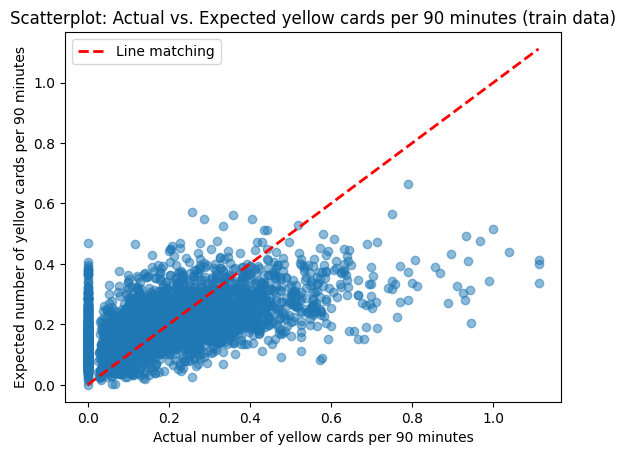

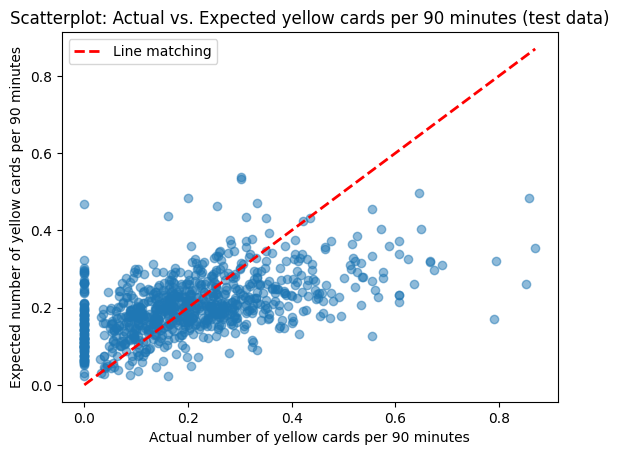

In [953]:
def generate_a_comparison_of_prediction_and_reality(target, actual_data, predicted_data, type_of_data):

    plt.scatter(actual_data, predicted_data, alpha=0.5)
    plt.xlabel(f'Actual number of {target}')
    plt.ylabel(f'Expected number of {target}')
    plt.title(f'Scatterplot: Actual vs. Expected {target} ({type_of_data} data)')

    line = np.linspace(min(actual_data), max(actual_data), 100)
    plt.plot(line, line, color='red', linestyle='--', linewidth=2, label='Line matching')

    plt.legend()
    plt.show()  

generate_a_comparison_of_prediction_and_reality('yellow cards per 90 minutes', predictions_df['CrdY/90'], predictions_df['lr_p_CrdY/90'], 'train')
generate_a_comparison_of_prediction_and_reality('yellow cards per 90 minutes', test_predictions_df['CrdY/90'], test_predictions_df['lr_p_CrdY/90'], 'test')

Now we move on to the next regression model - XGBRegressor from the xgboost library.

XGBRegressor is a gradient boosting algorithm specifically designed for regression tasks. It utilizes an ensemble of decision trees to make predictions on continuous targets. It excels at handling complex relationships, capturing interactions between variables, and handling noisy or correlated features. With tunable hyperparameters, such as learning rate, number of trees, and tree depth, it achieves a balance between model complexity and generalization ability. XGBRegressor also provides feature importance scores. 

Overall, it is a powerful algorithm widely used in regression tasks due to its strong predictive performance and flexibility.


In [954]:
xgbr = XGBRegressor()

model2 = xgbr.fit(X_train, y_train)

r_sqr = xgbr.score(X_train, y_train)
print(f'r^2 = {r_sqr}')


r^2 = 0.8823666541975347


Now let's make a prediction for our training data.

In [955]:
predictions_df['xgbr_p_CrdY/90'] = model2.predict(X_train).flatten()

predictions_df

Player   Age    Fls/90   90s  Gls/90  TklW   Int   CrdY/90  \
0       Thomas Müller  31.0  0.387324  28.4    0.28  20.0  15.0  0.000000   
1        Manuel Neuer  35.0  0.000000  27.9    0.00   1.0   0.0  0.000000   
2      Joshua Kimmich  26.0  0.727273  27.5    0.11  20.0  52.0  0.145455   
3     Dayot Upamecano  22.0  1.138211  24.6    0.04  42.0  32.0  0.162602   
4        Serge Gnabry  26.0  0.452675  24.3    0.58  31.0  14.0  0.000000   
...               ...   ...       ...   ...     ...   ...   ...       ...   
3420  Luca Fiordilino  25.0  0.684932   7.3    0.00  13.0  11.0  0.273973   
3421       Dor Peretz  26.0  1.538462   6.5    0.00  18.0   8.0  0.307692   
3422  Francesco Forte  28.0  2.340426   4.7    0.21   2.0   0.0  0.638298   
3423     Marco Modolo  32.0  1.363636   4.4    0.00   3.0   4.0  0.454545   
3424             Nani  34.0  0.625000   3.2    0.00   1.0   2.0  0.312500   

      lr_p_CrdY/90  xgbr_p_CrdY/90  
0         0.084664        0.011774  
1         0.065880        0.045258  
2         0.176725        0.137634  
3         0.200217        0.214681  
4         0.046191        0.019484  
...            ...             ...  
3420      0.160245        0.176242  
3421      0.267643        0.310670  
3422      0.347489        0.548638  
3423      0.264668        0.445653  
3424      0.176975        0.310619  

[3425 rows x 10 columns]

Let's now calculate the 2 main measures of our model's error for training data:

In [956]:
mean_absolute_error(y_train, predictions_df['xgbr_p_CrdY/90']), mean_squared_error(y_train, predictions_df['xgbr_p_CrdY/90'])

(0.04052535725932352, 0.0030448331973915357)

Now let's make a prediction for our testing data.

In [957]:
test_predictions_df['xgbr_p_CrdY/90'] = model2.predict(X_test).flatten()

test_predictions_df

Player  Age    Fls/90   90s  Gls/90  TklW  Int   CrdY/90  \
0                 Rodri   26  1.455108  32.3    0.06    41   33  0.154799   
1        Erling Haaland   22  1.006494  30.8    1.17     2    3  0.162338   
2       Kevin De Bruyne   31  0.743494  26.9    0.26    12    9  0.037175   
3        İlkay Gündoğan   32  0.842912  26.1    0.31    18   20  0.000000   
4         Manuel Akanji   27  0.944882  25.4    0.00    25   16  0.078740   
..                  ...  ...       ...   ...     ...   ...  ...       ...   
853      Gonzalo Villar   25  2.207792   7.7    0.00     7    4  0.259740   
854        Koray Günter   28  0.864198   8.1    0.00     7   11  0.246914   
855       Valerio Verre   29  1.866667   7.5    0.00     7    9  0.666667   
856  Fabio Quagliarella   40  0.571429   7.0    0.14     1    0  0.285714   
857        Nicola Murru   28  1.666667   7.2    0.00    13    8  0.277778   

     lr_p_CrdY/90  xgbr_p_CrdY/90  
0        0.241267        0.309983  
1        0.021862        0.230964  
2        0.128375        0.094149  
3        0.151265        0.170880  
4        0.178692        0.184223  
..            ...             ...  
853      0.345048        0.437686  
854      0.192082        0.164168  
855      0.320212        0.471042  
856      0.165175        0.095241  
857      0.289943        0.275089  

[858 rows x 10 columns]

Now let's calculate the quality measures of our XBGRegressor model:

In [958]:
r_sqr = xgbr.score(X_test, y_test)
print(f'r^2 = {r_sqr}')

r^2 = 0.14670023213567474


In [959]:
mean_absolute_error(y_test, test_predictions_df['xgbr_p_CrdY/90']), mean_squared_error(y_test, test_predictions_df['xgbr_p_CrdY/90'])

(0.10372169924838943, 0.019557328403945237)

And now to compare our results to reality.

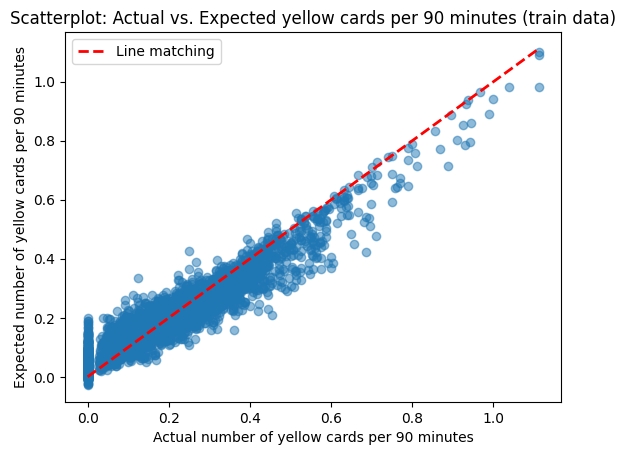

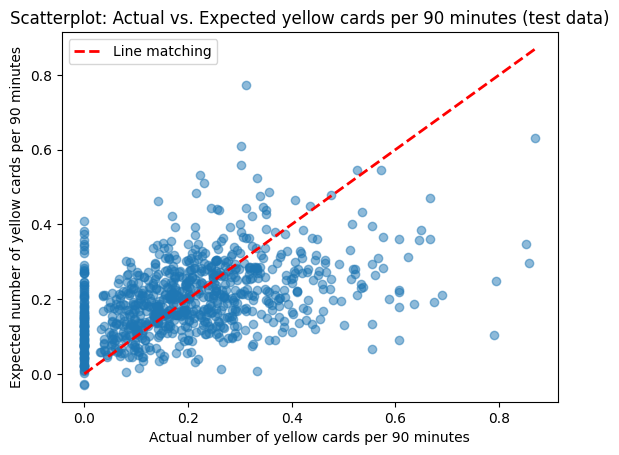

In [960]:
generate_a_comparison_of_prediction_and_reality('yellow cards per 90 minutes', predictions_df['CrdY/90'], predictions_df['xgbr_p_CrdY/90'], 'train')
generate_a_comparison_of_prediction_and_reality('yellow cards per 90 minutes', test_predictions_df['CrdY/90'], test_predictions_df['xgbr_p_CrdY/90'], 'test')

Next, we will explore another regression model - LGBMRegressor from lightgbm library

LightGBMRegressor is a part of the LightGBM library and is used for regression tasks using the gradient boosting method. It is a specifically designed regression algorithm based on decision trees that offers scalability, efficiency, and good predictive performance.

LightGBMRegressor is used for training regression models where the goal is to predict numerical values based on a set of features. It operates on a similar principle to other gradient boosting models, where it iteratively adds decision trees to the model to correct the errors made by previous trees.

In [961]:
lgbm = LGBMRegressor()

model3 = lgbm.fit(X_train, y_train)

r_sqr = lgbm.score(X_train, y_train)
print(f'r^2 = {r_sqr}')
print(f'params = {lgbm.get_params}')

r^2 = 0.6372502298437848
params = <bound method LGBMModel.get_params of LGBMRegressor()>


Now let's make a prediction for our training data.


In [962]:
predictions_df['lgbm1_p_CrdY/90'] = model3.predict(X_train).flatten()
predictions_df

Player   Age    Fls/90   90s  Gls/90  TklW   Int   CrdY/90  \
0       Thomas Müller  31.0  0.387324  28.4    0.28  20.0  15.0  0.000000   
1        Manuel Neuer  35.0  0.000000  27.9    0.00   1.0   0.0  0.000000   
2      Joshua Kimmich  26.0  0.727273  27.5    0.11  20.0  52.0  0.145455   
3     Dayot Upamecano  22.0  1.138211  24.6    0.04  42.0  32.0  0.162602   
4        Serge Gnabry  26.0  0.452675  24.3    0.58  31.0  14.0  0.000000   
...               ...   ...       ...   ...     ...   ...   ...       ...   
3420  Luca Fiordilino  25.0  0.684932   7.3    0.00  13.0  11.0  0.273973   
3421       Dor Peretz  26.0  1.538462   6.5    0.00  18.0   8.0  0.307692   
3422  Francesco Forte  28.0  2.340426   4.7    0.21   2.0   0.0  0.638298   
3423     Marco Modolo  32.0  1.363636   4.4    0.00   3.0   4.0  0.454545   
3424             Nani  34.0  0.625000   3.2    0.00   1.0   2.0  0.312500   

      lr_p_CrdY/90  xgbr_p_CrdY/90  lgbm1_p_CrdY/90  
0         0.084664        0.011774         0.060495  
1         0.065880        0.045258         0.087760  
2         0.176725        0.137634         0.136652  
3         0.200217        0.214681         0.226669  
4         0.046191        0.019484         0.042770  
...            ...             ...              ...  
3420      0.160245        0.176242         0.142659  
3421      0.267643        0.310670         0.329698  
3422      0.347489        0.548638         0.462819  
3423      0.264668        0.445653         0.407213  
3424      0.176975        0.310619         0.281329  

[3425 rows x 11 columns]

Let's now calculate the 2 main measures of our model's error for training data:

In [963]:
mean_absolute_error(y_train, predictions_df['lgbm1_p_CrdY/90']), mean_squared_error(y_train, predictions_df['lgbm1_p_CrdY/90'])

(0.07475192457795207, 0.009389451052191747)

Now let's make a prediction for our testing data.

In [964]:
test_predictions_df['lgbm1_p_CrdY/90'] = model3.predict(X_test).flatten()

test_predictions_df

Player  Age    Fls/90   90s  Gls/90  TklW  Int   CrdY/90  \
0                 Rodri   26  1.455108  32.3    0.06    41   33  0.154799   
1        Erling Haaland   22  1.006494  30.8    1.17     2    3  0.162338   
2       Kevin De Bruyne   31  0.743494  26.9    0.26    12    9  0.037175   
3        İlkay Gündoğan   32  0.842912  26.1    0.31    18   20  0.000000   
4         Manuel Akanji   27  0.944882  25.4    0.00    25   16  0.078740   
..                  ...  ...       ...   ...     ...   ...  ...       ...   
853      Gonzalo Villar   25  2.207792   7.7    0.00     7    4  0.259740   
854        Koray Günter   28  0.864198   8.1    0.00     7   11  0.246914   
855       Valerio Verre   29  1.866667   7.5    0.00     7    9  0.666667   
856  Fabio Quagliarella   40  0.571429   7.0    0.14     1    0  0.285714   
857        Nicola Murru   28  1.666667   7.2    0.00    13    8  0.277778   

     lr_p_CrdY/90  xgbr_p_CrdY/90  lgbm1_p_CrdY/90  
0        0.241267        0.309983         0.293443  
1        0.021862        0.230964         0.149730  
2        0.128375        0.094149         0.105688  
3        0.151265        0.170880         0.136407  
4        0.178692        0.184223         0.203729  
..            ...             ...              ...  
853      0.345048        0.437686         0.304788  
854      0.192082        0.164168         0.147450  
855      0.320212        0.471042         0.336897  
856      0.165175        0.095241         0.175088  
857      0.289943        0.275089         0.270324  

[858 rows x 11 columns]

Now let's calculate the quality measures of our first LGBMRegressor model:

In [965]:
r_sqr = lgbm.score(X_test, y_test)
print(f'r^2 = {r_sqr}')

r^2 = 0.21334283570504586


In [966]:
mean_absolute_error(y_test, test_predictions_df['lgbm1_p_CrdY/90']), mean_squared_error(y_test, test_predictions_df['lgbm1_p_CrdY/90'])

(0.09896105985369083, 0.01802990353781383)

And now to compare our results to reality.

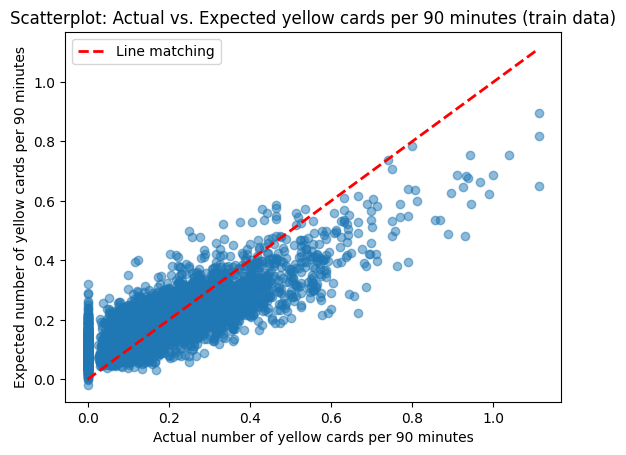

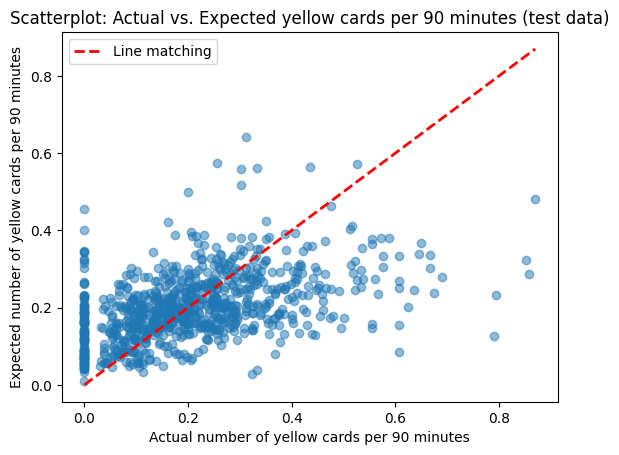

In [967]:
generate_a_comparison_of_prediction_and_reality('yellow cards per 90 minutes', predictions_df['CrdY/90'], predictions_df['lgbm1_p_CrdY/90'], 'train')
generate_a_comparison_of_prediction_and_reality('yellow cards per 90 minutes', test_predictions_df['CrdY/90'], test_predictions_df['lgbm1_p_CrdY/90'], 'test')


This time we will train our `LGBMRegressor` model with the given parameters.

Each of them plays a role in training the model, and here is an overview of these parameters:

`objective='regression'` - parameter specifying the regression goal.

`n_estimators=750` - the number of decision trees (estimators) to build. A higher value will result in a more complex model, but it may also lead to longer training time.

`max_depth=4` - the maximum depth of each tree in the model. It controls the model's complexity by limiting the number of nodes in the tree. Higher values can lead to more complex models but may also increase the risk of overfitting.

`learning_rate=0.05` - the learning rate, which controls how quickly the model adapts to the data. A lower value means the model learns slower but may lead to better generalization.

`min_child_samples=1` - the minimum number of samples required to create a new node in the tree. Higher values can simplify the model and reduce the risk of overfitting.

`colsample_bytree=0.9` - random feature (column) subsampling for each tree. It determines the percentage of features that will be considered when building each tree. Higher values can result in greater tree diversity and better generalization.

`subsample=0.9` - random subsampling of samples (rows) for each tree. It determines the percentage of samples that will be considered when building each tree. Higher values can result in greater tree diversity and better generalization.

`random_state=101` - setting the seed for the random number generator to ensure result reproducibility.

In [968]:
lgbm = LGBMRegressor(objective='regression', 
                    n_estimators=750, 
                    max_depth=4, 
                    learning_rate=0.05, 
                    min_child_samples=1,
                    colsample_bytree=0.9,
                    subsample=0.9,
                    random_state=101)

model4 = lgbm.fit(X_train, y_train)

r_sqr = lgbm.score(X_train, y_train)
print(f'r^2 = {r_sqr}')
print(f'params = {lgbm.get_params}')

r^2 = 0.7103742750702713
params = <bound method LGBMModel.get_params of LGBMRegressor(colsample_bytree=0.9, learning_rate=0.05, max_depth=4,
              min_child_samples=1, n_estimators=750, objective='regression',
              random_state=101, subsample=0.9)>


Now let's make a prediction for our training data.


In [969]:
predictions_df['lgbm2_p_CrdY/90'] = model4.predict(X_train).flatten()
predictions_df


Player   Age    Fls/90   90s  Gls/90  TklW   Int   CrdY/90  \
0       Thomas Müller  31.0  0.387324  28.4    0.28  20.0  15.0  0.000000   
1        Manuel Neuer  35.0  0.000000  27.9    0.00   1.0   0.0  0.000000   
2      Joshua Kimmich  26.0  0.727273  27.5    0.11  20.0  52.0  0.145455   
3     Dayot Upamecano  22.0  1.138211  24.6    0.04  42.0  32.0  0.162602   
4        Serge Gnabry  26.0  0.452675  24.3    0.58  31.0  14.0  0.000000   
...               ...   ...       ...   ...     ...   ...   ...       ...   
3420  Luca Fiordilino  25.0  0.684932   7.3    0.00  13.0  11.0  0.273973   
3421       Dor Peretz  26.0  1.538462   6.5    0.00  18.0   8.0  0.307692   
3422  Francesco Forte  28.0  2.340426   4.7    0.21   2.0   0.0  0.638298   
3423     Marco Modolo  32.0  1.363636   4.4    0.00   3.0   4.0  0.454545   
3424             Nani  34.0  0.625000   3.2    0.00   1.0   2.0  0.312500   

      lr_p_CrdY/90  xgbr_p_CrdY/90  lgbm1_p_CrdY/90  lgbm2_p_CrdY/90  
0         0.084664        0.011774         0.060495         0.020594  
1         0.065880        0.045258         0.087760         0.070174  
2         0.176725        0.137634         0.136652         0.142767  
3         0.200217        0.214681         0.226669         0.229665  
4         0.046191        0.019484         0.042770         0.013253  
...            ...             ...              ...              ...  
3420      0.160245        0.176242         0.142659         0.142524  
3421      0.267643        0.310670         0.329698         0.347607  
3422      0.347489        0.548638         0.462819         0.488830  
3423      0.264668        0.445653         0.407213         0.385349  
3424      0.176975        0.310619         0.281329         0.255100  

[3425 rows x 12 columns]

Let's now calculate the 2 main measures of our model's error for training data:

In [970]:
mean_absolute_error(y_train, predictions_df['lgbm2_p_CrdY/90']), mean_squared_error(y_train, predictions_df['lgbm2_p_CrdY/90'])

(0.06582853230490428, 0.007496701008279452)

Now let's make a prediction for our testing data.

In [971]:
test_predictions_df['lgbm2_p_CrdY/90'] = model4.predict(X_test).flatten()

test_predictions_df

Player  Age    Fls/90   90s  Gls/90  TklW  Int   CrdY/90  \
0                 Rodri   26  1.455108  32.3    0.06    41   33  0.154799   
1        Erling Haaland   22  1.006494  30.8    1.17     2    3  0.162338   
2       Kevin De Bruyne   31  0.743494  26.9    0.26    12    9  0.037175   
3        İlkay Gündoğan   32  0.842912  26.1    0.31    18   20  0.000000   
4         Manuel Akanji   27  0.944882  25.4    0.00    25   16  0.078740   
..                  ...  ...       ...   ...     ...   ...  ...       ...   
853      Gonzalo Villar   25  2.207792   7.7    0.00     7    4  0.259740   
854        Koray Günter   28  0.864198   8.1    0.00     7   11  0.246914   
855       Valerio Verre   29  1.866667   7.5    0.00     7    9  0.666667   
856  Fabio Quagliarella   40  0.571429   7.0    0.14     1    0  0.285714   
857        Nicola Murru   28  1.666667   7.2    0.00    13    8  0.277778   

     lr_p_CrdY/90  xgbr_p_CrdY/90  lgbm1_p_CrdY/90  lgbm2_p_CrdY/90  
0        0.241267        0.309983         0.293443         0.287962  
1        0.021862        0.230964         0.149730         0.225993  
2        0.128375        0.094149         0.105688         0.118512  
3        0.151265        0.170880         0.136407         0.176645  
4        0.178692        0.184223         0.203729         0.205329  
..            ...             ...              ...              ...  
853      0.345048        0.437686         0.304788         0.393121  
854      0.192082        0.164168         0.147450         0.169547  
855      0.320212        0.471042         0.336897         0.365762  
856      0.165175        0.095241         0.175088         0.146211  
857      0.289943        0.275089         0.270324         0.293254  

[858 rows x 12 columns]

Now let's calculate the quality measures of our second LGBMRegressor model:

In [972]:
r_sqr = lgbm.score(X_test, y_test)
print(f'r^2 = {r_sqr}')


r^2 = 0.2098532895285682


In [973]:
mean_absolute_error(y_test, test_predictions_df['lgbm2_p_CrdY/90']), mean_squared_error(y_test, test_predictions_df['lgbm2_p_CrdY/90'])

(0.10023363122262939, 0.01810988270003125)

And now to compare our results to reality.

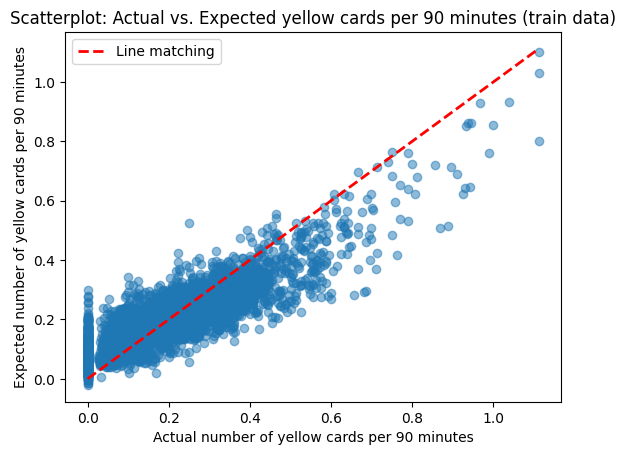

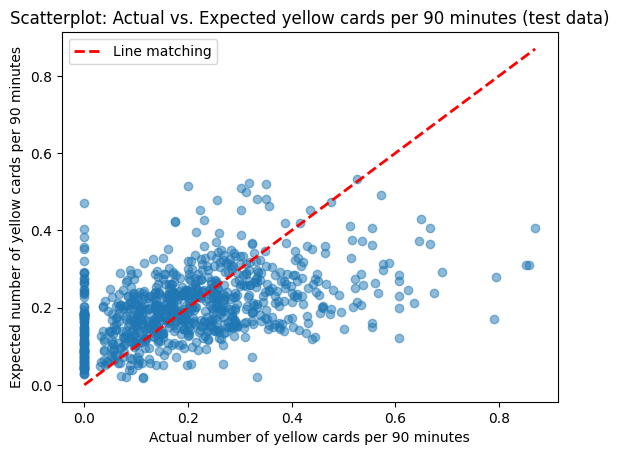

In [974]:
generate_a_comparison_of_prediction_and_reality('yellow cards per 90 minutes', predictions_df['CrdY/90'], predictions_df['lgbm2_p_CrdY/90'], 'train')
generate_a_comparison_of_prediction_and_reality('yellow cards per 90 minutes', test_predictions_df['CrdY/90'], test_predictions_df['lgbm2_p_CrdY/90'], 'test')

The next way to predict yellow cards will be neural networks.

A neural network for regression models predicts continuous numerical values. It consists of interconnected neurons that process input data through hidden layers, producing an output value. During training, weights are adjusted based on prediction errors using backpropagation and gradient descent. The network's architecture, activation functions, and hyperparameters affect its capacity and learning ability. Once trained, it predicts outputs for new data. Neural networks excel at capturing complex patterns, but proper design, training, and validation are essential for optimal performance and generalization.

c:\Users\trine\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


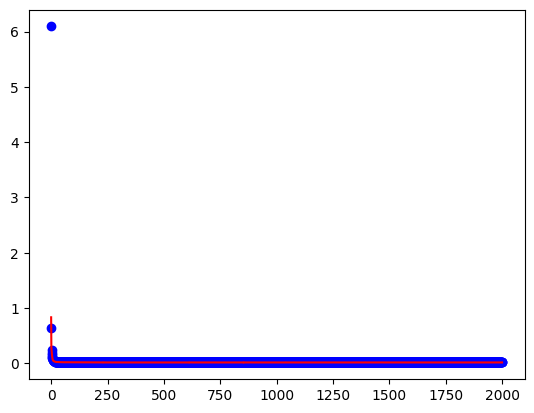

In [975]:
counter = 1
model5 = Sequential()
model5.add(Dense(13, input_shape=(6,), activation='relu'))
model5.add(Dense(13, activation='relu'))
model5.add(Dense(13, activation='relu'))
model5.add(Dense(13, activation='relu'))
model5.add(Dense(13, activation='relu'))
model5.add(Dense(1,))
model5.compile(Adam(lr=0.0001), 'mean_squared_error')

model5_hist = model5.fit(X_train, y_train, epochs = 2000, validation_split = 0, validation_data=(X_test, y_test), verbose = 0)


model5_dict = model5_hist.history
loss_values = model5_dict['loss']
val_loss_values = model5_dict['val_loss']
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='training loss val')

plt.savefig(f'./diagrams/keras{counter}.png')
counter += 1



The diagram above shows how the error of our model decreased over the epochs.

In neural networks, epochs refer to the number of times the entire training dataset is passed through the network during the training process. It is an important concept in training neural networks.

During each epoch, the network receives the training data, makes predictions, calculates the loss (error) between the predicted output and the actual target values, and adjusts the weights using an optimization algorithm such as gradient descent. The goal is to iteratively improve the network's performance by reducing the loss.

Now let's make a prediction for our training data.

In [976]:
predictions_df['krs1_p_CrdY/90'] = model5.predict(X_train)

predictions_df

108/108 [==============================] - 0s 1ms/step


Player   Age    Fls/90   90s  Gls/90  TklW   Int   CrdY/90  \
0       Thomas Müller  31.0  0.387324  28.4    0.28  20.0  15.0  0.000000   
1        Manuel Neuer  35.0  0.000000  27.9    0.00   1.0   0.0  0.000000   
2      Joshua Kimmich  26.0  0.727273  27.5    0.11  20.0  52.0  0.145455   
3     Dayot Upamecano  22.0  1.138211  24.6    0.04  42.0  32.0  0.162602   
4        Serge Gnabry  26.0  0.452675  24.3    0.58  31.0  14.0  0.000000   
...               ...   ...       ...   ...     ...   ...   ...       ...   
3420  Luca Fiordilino  25.0  0.684932   7.3    0.00  13.0  11.0  0.273973   
3421       Dor Peretz  26.0  1.538462   6.5    0.00  18.0   8.0  0.307692   
3422  Francesco Forte  28.0  2.340426   4.7    0.21   2.0   0.0  0.638298   
3423     Marco Modolo  32.0  1.363636   4.4    0.00   3.0   4.0  0.454545   
3424             Nani  34.0  0.625000   3.2    0.00   1.0   2.0  0.312500   

      lr_p_CrdY/90  xgbr_p_CrdY/90  lgbm1_p_CrdY/90  lgbm2_p_CrdY/90  \
0         0.084664        0.011774         0.060495         0.020594   
1         0.065880        0.045258         0.087760         0.070174   
2         0.176725        0.137634         0.136652         0.142767   
3         0.200217        0.214681         0.226669         0.229665   
4         0.046191        0.019484         0.042770         0.013253   
...            ...             ...              ...              ...   
3420      0.160245        0.176242         0.142659         0.142524   
3421      0.267643        0.310670         0.329698         0.347607   
3422      0.347489        0.548638         0.462819         0.488830   
3423      0.264668        0.445653         0.407213         0.385349   
3424      0.176975        0.310619         0.281329         0.255100   

      krs1_p_CrdY/90  
0           0.039512  
1           0.070941  
2           0.130799  
3           0.175104  
4           0.019504  
...              ...  
3420        0.227934  
3421        0.394631  
3422        0.308295  
3423        0.332181  
3424        0.201482  

[3425 rows x 13 columns]

R² for our first neural networks for training data is:

In [977]:
r2_score(y_train, predictions_df['krs1_p_CrdY/90'])


0.35272451122534554

Let's now calculate the 2 main measures of our model's error for training data:


In [978]:
mean_absolute_error(y_train, predictions_df['krs1_p_CrdY/90']), mean_squared_error(y_train, predictions_df['krs1_p_CrdY/90'])

(0.09575788580045613, 0.01675414299095449)

Now let's make a prediction for our testing data.

In [979]:
test_predictions_df['krs1_p_CrdY/90'] = model5.predict(X_test)

test_predictions_df

27/27 [==============================] - 0s 2ms/step


Player  Age    Fls/90   90s  Gls/90  TklW  Int   CrdY/90  \
0                 Rodri   26  1.455108  32.3    0.06    41   33  0.154799   
1        Erling Haaland   22  1.006494  30.8    1.17     2    3  0.162338   
2       Kevin De Bruyne   31  0.743494  26.9    0.26    12    9  0.037175   
3        İlkay Gündoğan   32  0.842912  26.1    0.31    18   20  0.000000   
4         Manuel Akanji   27  0.944882  25.4    0.00    25   16  0.078740   
..                  ...  ...       ...   ...     ...   ...  ...       ...   
853      Gonzalo Villar   25  2.207792   7.7    0.00     7    4  0.259740   
854        Koray Günter   28  0.864198   8.1    0.00     7   11  0.246914   
855       Valerio Verre   29  1.866667   7.5    0.00     7    9  0.666667   
856  Fabio Quagliarella   40  0.571429   7.0    0.14     1    0  0.285714   
857        Nicola Murru   28  1.666667   7.2    0.00    13    8  0.277778   

     lr_p_CrdY/90  xgbr_p_CrdY/90  lgbm1_p_CrdY/90  lgbm2_p_CrdY/90  \
0        0.241267        0.309983         0.293443         0.287962   
1        0.021862        0.230964         0.149730         0.225993   
2        0.128375        0.094149         0.105688         0.118512   
3        0.151265        0.170880         0.136407         0.176645   
4        0.178692        0.184223         0.203729         0.205329   
..            ...             ...              ...              ...   
853      0.345048        0.437686         0.304788         0.393121   
854      0.192082        0.164168         0.147450         0.169547   
855      0.320212        0.471042         0.336897         0.365762   
856      0.165175        0.095241         0.175088         0.146211   
857      0.289943        0.275089         0.270324         0.293254   

     krs1_p_CrdY/90  
0          0.219218  
1         -0.014206  
2          0.126292  
3          0.105831  
4          0.174035  
..              ...  
853        0.324770  
854        0.221198  
855        0.294760  
856        0.167742  
857        0.275330  

[858 rows x 13 columns]

R² for our first neural networks for testing data is:

In [980]:
r2_score(y_test, test_predictions_df['krs1_p_CrdY/90'])

0.27366989549872933

Let's now calculate the 2 main measures of our model's error for testing data:


In [981]:
mean_absolute_error(y_test, test_predictions_df['krs1_p_CrdY/90']), mean_squared_error(y_test, test_predictions_df['krs1_p_CrdY/90'])

(0.09641819674573689, 0.016647228697783754)

And now to compare our results to reality.

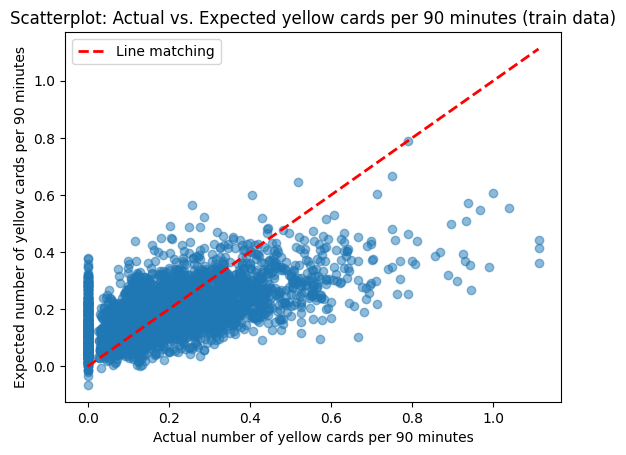

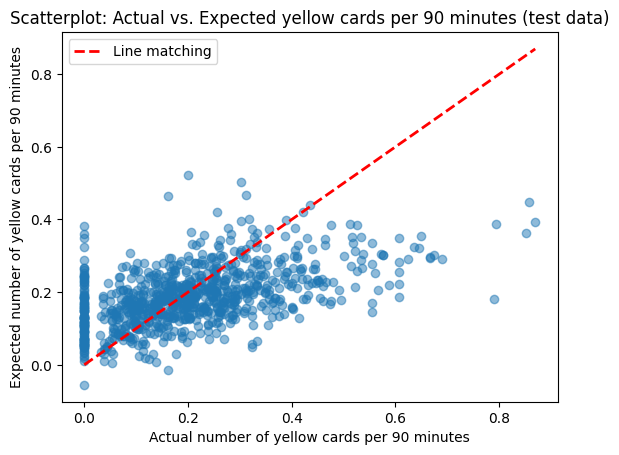

In [982]:
generate_a_comparison_of_prediction_and_reality('yellow cards per 90 minutes', predictions_df['CrdY/90'], predictions_df['krs1_p_CrdY/90'], 'train')
generate_a_comparison_of_prediction_and_reality('yellow cards per 90 minutes', test_predictions_df['CrdY/90'], test_predictions_df['krs1_p_CrdY/90'], 'test')

Now let's create a neural network model similar to the previous one, this time with a stop condition in the event that after a certain number of epochs, there is no improvement of the validation error, in our case after 50 epochs ( `patience=50` )

Validation loss is a measure that evaluates how well a model generalizes on validation data, which is not used during training. In the context of neural networks, the validation loss measures the difference between the model's predictions and the actual values on the validation data.

During training, the model is adjusted to the training data to minimize the loss. However, if the model becomes too overfit, it may poorly generalize to new, unseen data. To assess the model's ability to generalize, a validation set is used, which contains data not present in the training set.

In this model of neural networks, the `EarlyStopping` object appears, which is responsible for stopping the training of the neural network. The individual parameters that are passed to the constructor of the `EarlyStopping` class are explained below:

+ `monitor='val_loss'`: The monitor parameter specifies the metric to monitor the training progress. In this case, the monitored metric is val_loss, which represents the loss value on the validation set. The model will be observed to minimize this metric.

+ `min_delta=0`: The min_delta parameter determines the minimum change required in the monitored metric to be considered as an improvement. A value of 0 means that we expect no decrease in the monitored metric.

+ `patience=50`: The patience parameter specifies the number of epochs to continue training even if the monitored metric doesn't improve. If there is no improvement for patience consecutive epochs, the training will be stopped.

+ `verbose=1`: The verbose parameter controls the verbosity level of the output messages during training. A value of 1 indicates that informative messages will be displayed when the training is stopped based on the defined conditions.

+ `mode='min'`: The mode parameter specifies whether to minimize the monitored metric (`'min'`) or maximize it (`'max'`). In this case, the value 'min' indicates that we aim to minimize the `'val_loss'`

c:\Users\trine\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 368: early stopping


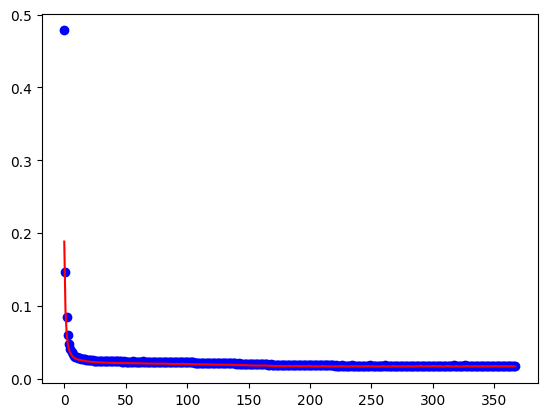

In [984]:
model6 = Sequential()
model6.add(Dense(13, input_shape=(6,), activation='relu'))
model6.add(Dense(13, activation='relu'))
model6.add(Dense(13, activation='relu'))
model6.add(Dense(13, activation='relu'))
model6.add(Dense(13, activation='relu'))
model6.add(Dense(1,))
model6.compile(Adam(lr=0.0001), 'mean_squared_error')

earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='min')

model6_hist = model6.fit(X_train, y_train, epochs = 2000, validation_split = 0, validation_data=(X_test, y_test), verbose = 0,callbacks = [earlystopper])

model6_dict = model6_hist.history
loss_values = model6_dict['loss']
val_loss_values = model6_dict['val_loss']
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='training loss val')

plt.savefig(f'./diagrams/keras{counter}.png')
counter += 1

The diagram above shows how the error of our model decreased over the epochs.

Now let's make a prediction for our training data.

In [985]:
predictions_df['krs2_p_CrdY/90'] = model6.predict(X_train)

predictions_df

108/108 [==============================] - 0s 989us/step


Player   Age    Fls/90   90s  Gls/90  TklW   Int   CrdY/90  \
0       Thomas Müller  31.0  0.387324  28.4    0.28  20.0  15.0  0.000000   
1        Manuel Neuer  35.0  0.000000  27.9    0.00   1.0   0.0  0.000000   
2      Joshua Kimmich  26.0  0.727273  27.5    0.11  20.0  52.0  0.145455   
3     Dayot Upamecano  22.0  1.138211  24.6    0.04  42.0  32.0  0.162602   
4        Serge Gnabry  26.0  0.452675  24.3    0.58  31.0  14.0  0.000000   
...               ...   ...       ...   ...     ...   ...   ...       ...   
3420  Luca Fiordilino  25.0  0.684932   7.3    0.00  13.0  11.0  0.273973   
3421       Dor Peretz  26.0  1.538462   6.5    0.00  18.0   8.0  0.307692   
3422  Francesco Forte  28.0  2.340426   4.7    0.21   2.0   0.0  0.638298   
3423     Marco Modolo  32.0  1.363636   4.4    0.00   3.0   4.0  0.454545   
3424             Nani  34.0  0.625000   3.2    0.00   1.0   2.0  0.312500   

      lr_p_CrdY/90  xgbr_p_CrdY/90  lgbm1_p_CrdY/90  lgbm2_p_CrdY/90  \
0         0.084664        0.011774         0.060495         0.020594   
1         0.065880        0.045258         0.087760         0.070174   
2         0.176725        0.137634         0.136652         0.142767   
3         0.200217        0.214681         0.226669         0.229665   
4         0.046191        0.019484         0.042770         0.013253   
...            ...             ...              ...              ...   
3420      0.160245        0.176242         0.142659         0.142524   
3421      0.267643        0.310670         0.329698         0.347607   
3422      0.347489        0.548638         0.462819         0.488830   
3423      0.264668        0.445653         0.407213         0.385349   
3424      0.176975        0.310619         0.281329         0.255100   

      krs1_p_CrdY/90  krs2_p_CrdY/90  
0           0.039512        0.091087  
1           0.070941        0.079971  
2           0.130799        0.161508  
3           0.175104        0.193397  
4           0.019504        0.082977  
...              ...             ...  
3420        0.227934        0.178509  
3421        0.394631        0.273820  
3422        0.308295        0.332146  
3423        0.332181        0.424259  
3424        0.201482        0.215262  

[3425 rows x 14 columns]

R² for our second neural networks for training data is:

In [986]:
r2_score(y_train, predictions_df['krs2_p_CrdY/90'])

0.33402291973142495

Let's now calculate the 2 main measures of our model's error for training data:


In [987]:
mean_absolute_error(y_train, predictions_df['krs2_p_CrdY/90']), mean_squared_error(y_train, predictions_df['krs2_p_CrdY/90'])


(0.09906663132006373, 0.017238216841241518)

Now let's make a prediction for our testing data.

In [988]:
test_predictions_df['krs2_p_CrdY/90'] = model6.predict(X_test)

test_predictions_df

27/27 [==============================] - 0s 953us/step


Player  Age    Fls/90   90s  Gls/90  TklW  Int   CrdY/90  \
0                 Rodri   26  1.455108  32.3    0.06    41   33  0.154799   
1        Erling Haaland   22  1.006494  30.8    1.17     2    3  0.162338   
2       Kevin De Bruyne   31  0.743494  26.9    0.26    12    9  0.037175   
3        İlkay Gündoğan   32  0.842912  26.1    0.31    18   20  0.000000   
4         Manuel Akanji   27  0.944882  25.4    0.00    25   16  0.078740   
..                  ...  ...       ...   ...     ...   ...  ...       ...   
853      Gonzalo Villar   25  2.207792   7.7    0.00     7    4  0.259740   
854        Koray Günter   28  0.864198   8.1    0.00     7   11  0.246914   
855       Valerio Verre   29  1.866667   7.5    0.00     7    9  0.666667   
856  Fabio Quagliarella   40  0.571429   7.0    0.14     1    0  0.285714   
857        Nicola Murru   28  1.666667   7.2    0.00    13    8  0.277778   

     lr_p_CrdY/90  xgbr_p_CrdY/90  lgbm1_p_CrdY/90  lgbm2_p_CrdY/90  \
0        0.241267        0.309983         0.293443         0.287962   
1        0.021862        0.230964         0.149730         0.225993   
2        0.128375        0.094149         0.105688         0.118512   
3        0.151265        0.170880         0.136407         0.176645   
4        0.178692        0.184223         0.203729         0.205329   
..            ...             ...              ...              ...   
853      0.345048        0.437686         0.304788         0.393121   
854      0.192082        0.164168         0.147450         0.169547   
855      0.320212        0.471042         0.336897         0.365762   
856      0.165175        0.095241         0.175088         0.146211   
857      0.289943        0.275089         0.270324         0.293254   

     krs1_p_CrdY/90  krs2_p_CrdY/90  
0          0.219218        0.214414  
1         -0.014206        0.084711  
2          0.126292        0.120554  
3          0.105831        0.172189  
4          0.174035        0.158077  
..              ...             ...  
853        0.324770        0.360392  
854        0.221198        0.199735  
855        0.294760        0.346447  
856        0.167742        0.251577  
857        0.275330        0.294100  

[858 rows x 14 columns]

R² for our second neural networks for testing data is:

In [989]:
r2_score(y_test, test_predictions_df['krs2_p_CrdY/90'])

0.2639445031749741

Let's now calculate the 2 main measures of our model's error for testing data:


In [990]:
mean_absolute_error(y_test, test_predictions_df['krs2_p_CrdY/90']), mean_squared_error(y_test, test_predictions_df['krs2_p_CrdY/90'])

(0.09869356311197604, 0.01687013124469167)

And now to compare our results to reality.


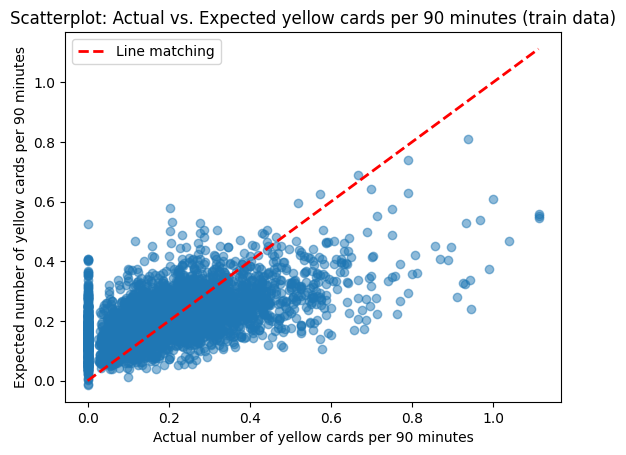

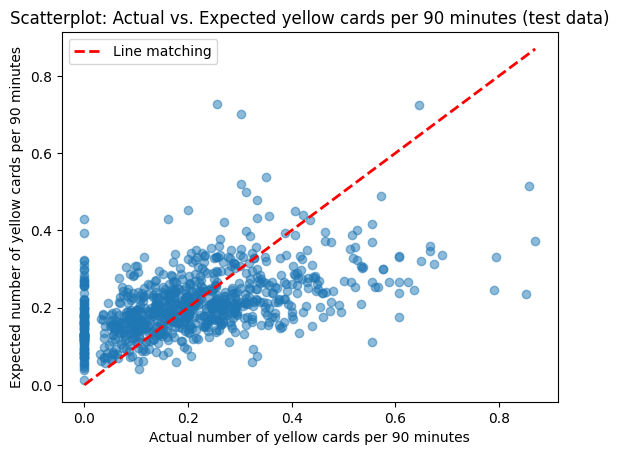

In [991]:

generate_a_comparison_of_prediction_and_reality('yellow cards per 90 minutes', predictions_df['CrdY/90'], predictions_df['krs2_p_CrdY/90'], 'train')
generate_a_comparison_of_prediction_and_reality('yellow cards per 90 minutes', test_predictions_df['CrdY/90'], test_predictions_df['krs2_p_CrdY/90'], 'test')

The last model we will use to build our regression model will be `DecisionTreeRegressor`.

`The DecisionTreeRegressor` builds a binary decision tree by recursively splitting the data based on feature thresholds. The splits are determined by minimizing chosen criterion, aiming to minimize the variance within each resulting partition.

During training, `the DecisionTreeRegressor` learns the optimal splits based on the provided input features and target values. It considers different features and thresholds to find the best split. The training process continues until certain stopping criteria, such as reaching a maximum depth or minimum number of samples in a leaf node, are met.

`The DecisionTreeRegressor` offers various parameters to control its behavior, such as the maximum depth of the tree, the minimum number of samples required to split a node, and the criterion used for splitting (e.g., MSE or MAE). These parameters allow for customization and trade-offs between model complexity and overfitting.

To begin with, let's choose a default model for our training data

In [992]:
dtr1 = DecisionTreeRegressor()
model7 = dtr1.fit(X_train, y_train)

r_sqr = dtr1.score(X_train, y_train)
print(f'r^2 = {r_sqr}')
print(f'params = {dtr1.get_params}')

r^2 = 0.9999941311503402
params = <bound method BaseEstimator.get_params of DecisionTreeRegressor()>


Now let's make a prediction for our training data.

In [993]:
predictions_df['dtr1_p_CrdY/90'] = model7.predict(X_train).flatten()
predictions_df


Player   Age    Fls/90   90s  Gls/90  TklW   Int   CrdY/90  \
0       Thomas Müller  31.0  0.387324  28.4    0.28  20.0  15.0  0.000000   
1        Manuel Neuer  35.0  0.000000  27.9    0.00   1.0   0.0  0.000000   
2      Joshua Kimmich  26.0  0.727273  27.5    0.11  20.0  52.0  0.145455   
3     Dayot Upamecano  22.0  1.138211  24.6    0.04  42.0  32.0  0.162602   
4        Serge Gnabry  26.0  0.452675  24.3    0.58  31.0  14.0  0.000000   
...               ...   ...       ...   ...     ...   ...   ...       ...   
3420  Luca Fiordilino  25.0  0.684932   7.3    0.00  13.0  11.0  0.273973   
3421       Dor Peretz  26.0  1.538462   6.5    0.00  18.0   8.0  0.307692   
3422  Francesco Forte  28.0  2.340426   4.7    0.21   2.0   0.0  0.638298   
3423     Marco Modolo  32.0  1.363636   4.4    0.00   3.0   4.0  0.454545   
3424             Nani  34.0  0.625000   3.2    0.00   1.0   2.0  0.312500   

      lr_p_CrdY/90  xgbr_p_CrdY/90  lgbm1_p_CrdY/90  lgbm2_p_CrdY/90  \
0         0.084664        0.011774         0.060495         0.020594   
1         0.065880        0.045258         0.087760         0.070174   
2         0.176725        0.137634         0.136652         0.142767   
3         0.200217        0.214681         0.226669         0.229665   
4         0.046191        0.019484         0.042770         0.013253   
...            ...             ...              ...              ...   
3420      0.160245        0.176242         0.142659         0.142524   
3421      0.267643        0.310670         0.329698         0.347607   
3422      0.347489        0.548638         0.462819         0.488830   
3423      0.264668        0.445653         0.407213         0.385349   
3424      0.176975        0.310619         0.281329         0.255100   

      krs1_p_CrdY/90  krs2_p_CrdY/90  dtr1_p_CrdY/90  
0           0.039512        0.091087        0.000000  
1           0.070941        0.079971        0.000000  
2           0.130799        0.161508        0.145455  
3           0.175104        0.193397        0.162602  
4           0.019504        0.082977        0.000000  
...              ...             ...             ...  
3420        0.227934        0.178509        0.273973  
3421        0.394631        0.273820        0.307692  
3422        0.308295        0.332146        0.638298  
3423        0.332181        0.424259        0.454545  
3424        0.201482        0.215262        0.312500  

[3425 rows x 15 columns]

Let's now calculate the 2 main measures of our model's error for training data:


In [994]:
mean_absolute_error(y_train, predictions_df['dtr1_p_CrdY/90']), mean_squared_error(y_train, predictions_df['dtr1_p_CrdY/90'])

(9.418412997409936e-06, 1.5190988705499896e-07)

Now let's make a prediction for our testing data.

In [995]:
test_predictions_df['dtr1_p_CrdY/90'] = model7.predict(X_test).flatten()

test_predictions_df

Player  Age    Fls/90   90s  Gls/90  TklW  Int   CrdY/90  \
0                 Rodri   26  1.455108  32.3    0.06    41   33  0.154799   
1        Erling Haaland   22  1.006494  30.8    1.17     2    3  0.162338   
2       Kevin De Bruyne   31  0.743494  26.9    0.26    12    9  0.037175   
3        İlkay Gündoğan   32  0.842912  26.1    0.31    18   20  0.000000   
4         Manuel Akanji   27  0.944882  25.4    0.00    25   16  0.078740   
..                  ...  ...       ...   ...     ...   ...  ...       ...   
853      Gonzalo Villar   25  2.207792   7.7    0.00     7    4  0.259740   
854        Koray Günter   28  0.864198   8.1    0.00     7   11  0.246914   
855       Valerio Verre   29  1.866667   7.5    0.00     7    9  0.666667   
856  Fabio Quagliarella   40  0.571429   7.0    0.14     1    0  0.285714   
857        Nicola Murru   28  1.666667   7.2    0.00    13    8  0.277778   

     lr_p_CrdY/90  xgbr_p_CrdY/90  lgbm1_p_CrdY/90  lgbm2_p_CrdY/90  \
0        0.241267        0.309983         0.293443         0.287962   
1        0.021862        0.230964         0.149730         0.225993   
2        0.128375        0.094149         0.105688         0.118512   
3        0.151265        0.170880         0.136407         0.176645   
4        0.178692        0.184223         0.203729         0.205329   
..            ...             ...              ...              ...   
853      0.345048        0.437686         0.304788         0.393121   
854      0.192082        0.164168         0.147450         0.169547   
855      0.320212        0.471042         0.336897         0.365762   
856      0.165175        0.095241         0.175088         0.146211   
857      0.289943        0.275089         0.270324         0.293254   

     krs1_p_CrdY/90  krs2_p_CrdY/90  dtr1_p_CrdY/90  
0          0.219218        0.214414        0.287356  
1         -0.014206        0.084711        0.235294  
2          0.126292        0.120554        0.043103  
3          0.105831        0.172189        0.000000  
4          0.174035        0.158077        0.000000  
..              ...             ...             ...  
853        0.324770        0.360392        0.370370  
854        0.221198        0.199735        0.000000  
855        0.294760        0.346447        0.263158  
856        0.167742        0.251577        0.106383  
857        0.275330        0.294100        0.476190  

[858 rows x 15 columns]

R² for our first `DecisionTreeRegressor` model for testing data is:

In [996]:
r_sqr = dtr1.score(X_test, test_predictions_df['CrdY/90'])
print(f'r^2 = {r_sqr}')


r^2 = -0.5312616965294241


Let's now calculate the 2 main measures of our model's error for training data:


In [997]:
mean_absolute_error(y_test, test_predictions_df['dtr1_p_CrdY/90']), mean_squared_error(y_test, test_predictions_df['dtr1_p_CrdY/90'])

(0.1402035761338969, 0.03509597564565366)

And now to compare our results to reality.

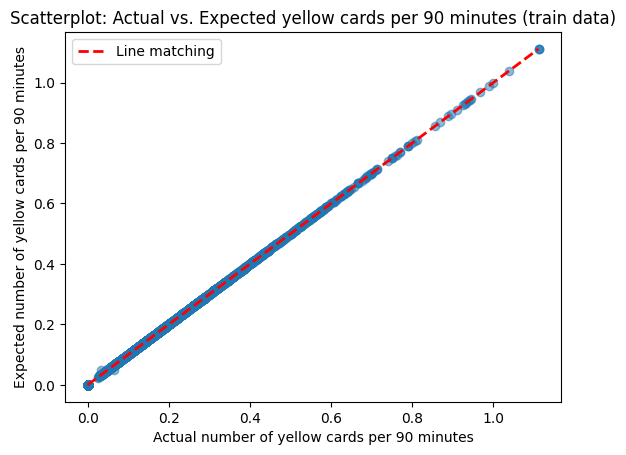

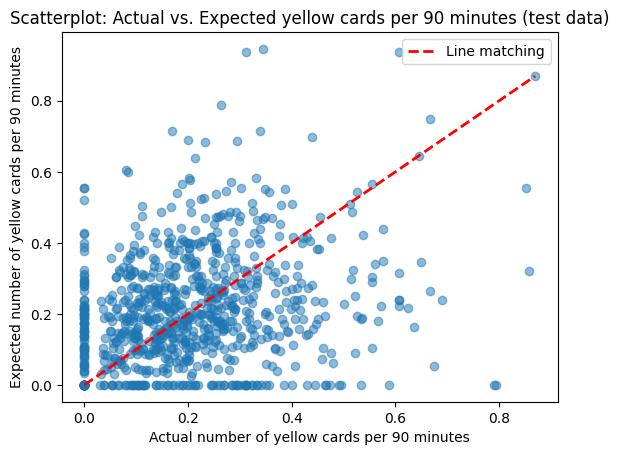

In [998]:
generate_a_comparison_of_prediction_and_reality('yellow cards per 90 minutes', predictions_df['CrdY/90'], predictions_df['dtr1_p_CrdY/90'], 'train')
generate_a_comparison_of_prediction_and_reality('yellow cards per 90 minutes', test_predictions_df['CrdY/90'], test_predictions_df['dtr1_p_CrdY/90'], 'test')

This time, we will pass parameters to our tree that will affect the training of our `DecisionTreeRegressor` model.

The parameter grid contains different values for the splitting criterion ('criterion'), the splitting strategy ( `splitter` ), the maximum depth of the tree ( `max_depth` ), the minimum number of samples required to split a node ( `min_samples_split` ), and the minimum impurity decrease required for splitting ( `min_impurity_decrease` ).

The `GridSearchCV` object is created, which performs the grid search. It is passed:
`DecisionTreeRegressor()` as the base model, `param_grid` as the parameter dictionary to be tested, `cv=5` indicating 5-fold cross-validation, which splits the training data into 5 subsets for model evaluation and `scoring='neg_mean_squared_error'` indicating that the evaluation metric is the negative mean squared error.

As a result, the code performs a grid search to find the optimal parameters for the `DecisionTreeRegressor` model and reports the best score (negative MSE) and best parameters discovered during this process.

At this point, it should be noted that I have made earlier attempts at the selection of parameters and the values below are the final version of these best attempts to match them.

In [999]:
param_grid = {
    'criterion': ['absolute_error', 'squared_error', 'friedman_mse'],
    'splitter' : ['random', 'best'],
    'max_depth' : [70, 80, 90, 100],
    'min_samples_split' : [50, 55, 60, 65, 70, 75],
    'min_impurity_decrease' : [0.0025, 0.005, 0.01]
}

gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
gridSearch.fit(X_train, y_train)
print('The best score: ', gridSearch.best_score_)
print('The best parameters: ', gridSearch.best_params_)

The best score:  -0.019678759911024142
The best parameters:  {'criterion': 'friedman_mse', 'max_depth': 90, 'min_impurity_decrease': 0.01, 'min_samples_split': 75, 'splitter': 'random'}


Below we take the best parameter for our `DecisionTreeRegressor` model and train it on our training data.

In [1000]:
# best_params = {'criterion': 'friedman_mse', 'max_depth': 80, 'min_impurity_decrease': 0.005, 'min_samples_split': 60, 'splitter': 'random'}
dtr2 = DecisionTreeRegressor(**gridSearch.best_params_)
model8 = dtr2.fit(X_train, y_train)

r_sqr = dtr2.score(X_train, y_train)
print(f'r^2 = {r_sqr}')

r^2 = 0.3241163770710006


Let's now calculate the 2 main measures of our model's error for training data:


In [1001]:
predictions_df['dtr2_p_CrdY/90'] = model8.predict(X_train).flatten()
predictions_df


Player   Age    Fls/90   90s  Gls/90  TklW   Int   CrdY/90  \
0       Thomas Müller  31.0  0.387324  28.4    0.28  20.0  15.0  0.000000   
1        Manuel Neuer  35.0  0.000000  27.9    0.00   1.0   0.0  0.000000   
2      Joshua Kimmich  26.0  0.727273  27.5    0.11  20.0  52.0  0.145455   
3     Dayot Upamecano  22.0  1.138211  24.6    0.04  42.0  32.0  0.162602   
4        Serge Gnabry  26.0  0.452675  24.3    0.58  31.0  14.0  0.000000   
...               ...   ...       ...   ...     ...   ...   ...       ...   
3420  Luca Fiordilino  25.0  0.684932   7.3    0.00  13.0  11.0  0.273973   
3421       Dor Peretz  26.0  1.538462   6.5    0.00  18.0   8.0  0.307692   
3422  Francesco Forte  28.0  2.340426   4.7    0.21   2.0   0.0  0.638298   
3423     Marco Modolo  32.0  1.363636   4.4    0.00   3.0   4.0  0.454545   
3424             Nani  34.0  0.625000   3.2    0.00   1.0   2.0  0.312500   

      lr_p_CrdY/90  xgbr_p_CrdY/90  lgbm1_p_CrdY/90  lgbm2_p_CrdY/90  \
0         0.084664        0.011774         0.060495         0.020594   
1         0.065880        0.045258         0.087760         0.070174   
2         0.176725        0.137634         0.136652         0.142767   
3         0.200217        0.214681         0.226669         0.229665   
4         0.046191        0.019484         0.042770         0.013253   
...            ...             ...              ...              ...   
3420      0.160245        0.176242         0.142659         0.142524   
3421      0.267643        0.310670         0.329698         0.347607   
3422      0.347489        0.548638         0.462819         0.488830   
3423      0.264668        0.445653         0.407213         0.385349   
3424      0.176975        0.310619         0.281329         0.255100   

      krs1_p_CrdY/90  krs2_p_CrdY/90  dtr1_p_CrdY/90  dtr2_p_CrdY/90  
0           0.039512        0.091087        0.000000        0.056784  
1           0.070941        0.079971        0.000000        0.058608  
2           0.130799        0.161508        0.145455        0.142833  
3           0.175104        0.193397        0.162602        0.222379  
4           0.019504        0.082977        0.000000        0.053870  
...              ...             ...             ...             ...  
3420        0.227934        0.178509        0.273973        0.214149  
3421        0.394631        0.273820        0.307692        0.238264  
3422        0.308295        0.332146        0.638298        0.277096  
3423        0.332181        0.424259        0.454545        0.250378  
3424        0.201482        0.215262        0.312500        0.245787  

[3425 rows x 16 columns]

Let's now calculate the 2 main measures of our model's error for training data:


In [1002]:
mean_absolute_error(predictions_df['CrdY/90'], predictions_df['dtr2_p_CrdY/90']), mean_squared_error(predictions_df['CrdY/90'], predictions_df['dtr2_p_CrdY/90'])

(0.09785257951641715, 0.017494638774648803)

Now let's make a prediction for our testing data.

In [1003]:
test_predictions_df['dtr2_p_CrdY/90'] = model8.predict(X_test).flatten()

test_predictions_df

Player  Age    Fls/90   90s  Gls/90  TklW  Int   CrdY/90  \
0                 Rodri   26  1.455108  32.3    0.06    41   33  0.154799   
1        Erling Haaland   22  1.006494  30.8    1.17     2    3  0.162338   
2       Kevin De Bruyne   31  0.743494  26.9    0.26    12    9  0.037175   
3        İlkay Gündoğan   32  0.842912  26.1    0.31    18   20  0.000000   
4         Manuel Akanji   27  0.944882  25.4    0.00    25   16  0.078740   
..                  ...  ...       ...   ...     ...   ...  ...       ...   
853      Gonzalo Villar   25  2.207792   7.7    0.00     7    4  0.259740   
854        Koray Günter   28  0.864198   8.1    0.00     7   11  0.246914   
855       Valerio Verre   29  1.866667   7.5    0.00     7    9  0.666667   
856  Fabio Quagliarella   40  0.571429   7.0    0.14     1    0  0.285714   
857        Nicola Murru   28  1.666667   7.2    0.00    13    8  0.277778   

     lr_p_CrdY/90  xgbr_p_CrdY/90  lgbm1_p_CrdY/90  lgbm2_p_CrdY/90  \
0        0.241267        0.309983         0.293443         0.287962   
1        0.021862        0.230964         0.149730         0.225993   
2        0.128375        0.094149         0.105688         0.118512   
3        0.151265        0.170880         0.136407         0.176645   
4        0.178692        0.184223         0.203729         0.205329   
..            ...             ...              ...              ...   
853      0.345048        0.437686         0.304788         0.393121   
854      0.192082        0.164168         0.147450         0.169547   
855      0.320212        0.471042         0.336897         0.365762   
856      0.165175        0.095241         0.175088         0.146211   
857      0.289943        0.275089         0.270324         0.293254   

     krs1_p_CrdY/90  krs2_p_CrdY/90  dtr1_p_CrdY/90  dtr2_p_CrdY/90  
0          0.219218        0.214414        0.287356        0.274791  
1         -0.014206        0.084711        0.235294        0.125116  
2          0.126292        0.120554        0.043103        0.142833  
3          0.105831        0.172189        0.000000        0.142833  
4          0.174035        0.158077        0.000000        0.205157  
..              ...             ...             ...             ...  
853        0.324770        0.360392        0.370370        0.375362  
854        0.221198        0.199735        0.000000        0.214149  
855        0.294760        0.346447        0.263158        0.324756  
856        0.167742        0.251577        0.106383        0.245787  
857        0.275330        0.294100        0.476190        0.238264  

[858 rows x 16 columns]

R² for our second `DecisionTreeregressor` for testing data is:

In [1004]:
r_sqr = dtr2.score(X_test, y_test)
print(f'r^2 = {r_sqr}')

r^2 = 0.27584630562599455


And now to compare our results to reality.

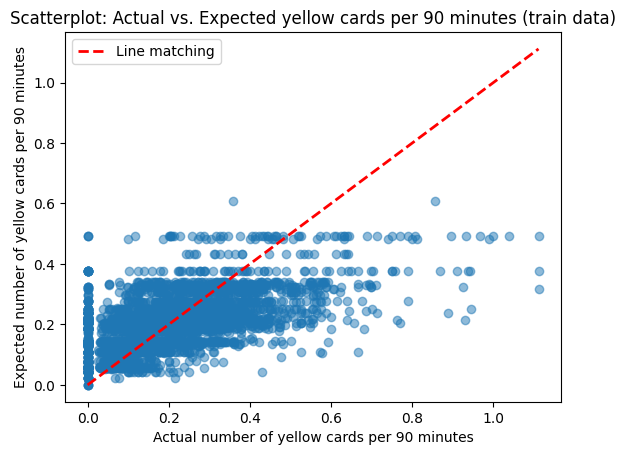

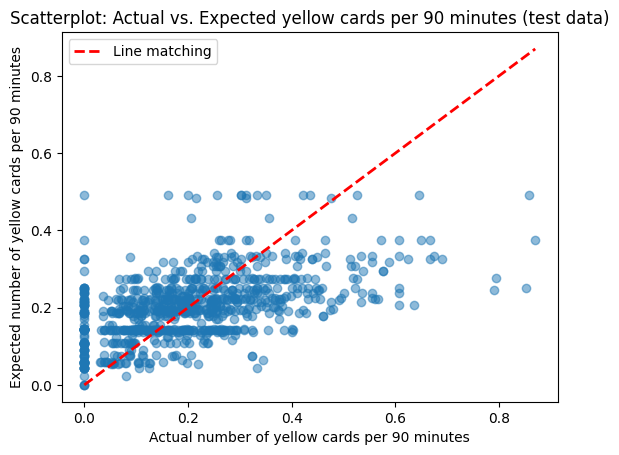

In [1005]:
generate_a_comparison_of_prediction_and_reality('yellow cards per 90 minutes', predictions_df['CrdY/90'], predictions_df['dtr2_p_CrdY/90'], 'train')
generate_a_comparison_of_prediction_and_reality('yellow cards per 90 minutes', test_predictions_df['CrdY/90'], test_predictions_df['dtr2_p_CrdY/90'], 'test')

Now let's present our results so far in a compact form. Below are graphs comparing r², `MAE`, `MSE` for each model and the type of data that was used to generate them.

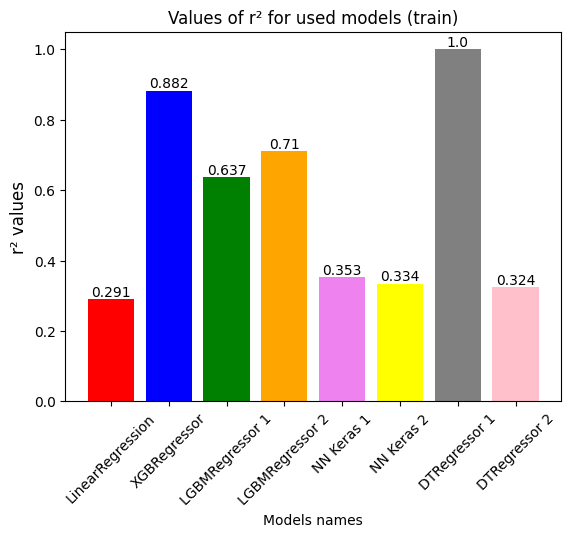

<Figure size 640x480 with 0 Axes>

In [1006]:
def add_values_on_diagram_bars(ax):
    for p in ax.patches:
        wysokość = round(p.get_height(),3)
        ax.annotate(f'{wysokość}', (p.get_x() + p.get_width() / 2, wysokość),
                    ha='center', va='bottom')

NAMES_OF_PREDICTIONS_COLUMNS = ['lr_p_CrdY/90', 'xgbr_p_CrdY/90', 'lgbm1_p_CrdY/90', 'lgbm2_p_CrdY/90', 'krs1_p_CrdY/90','krs2_p_CrdY/90', 'dtr1_p_CrdY/90', 'dtr2_p_CrdY/90']


def get_all_values(func, columns, y_values, prediction_set):
    result = []
    for column in columns:
        result.append(func(y_values, prediction_set[f'{column}']))
    return result

def get_all_r2_values(columns, y_values, prediction_set):
    return get_all_values(r2_score, columns, y_values, prediction_set)


train_r2_score_list = get_all_r2_values(NAMES_OF_PREDICTIONS_COLUMNS, y_train, predictions_df)

models_names = ['LinearRegression', 'XGBRegressor', 'LGBMRegressor 1','LGBMRegressor 2', 'NN Keras 1', 'NN Keras 2',  'DTRegressor 1', 'DTRegressor 2']

colors = ['red', 'blue', 'green', 'orange', 'violet', 'yellow', 'grey', 'pink']


plt.bar(models_names, train_r2_score_list, color=colors)


plt.title('Values of r² for used models (train)')
plt.xticks(rotation=45)
plt.xlabel('Models names')
plt.ylabel('r² values',  fontsize=12, va='bottom')


add_values_on_diagram_bars(plt.gca())
plt.show()

plt.savefig('./diagrams/r2_crdY_90_train.png')




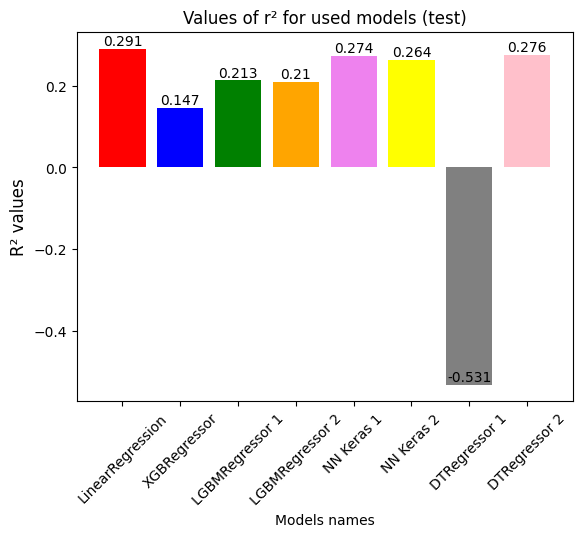

<Figure size 640x480 with 0 Axes>

In [1007]:
test_r2_score_list = get_all_r2_values(NAMES_OF_PREDICTIONS_COLUMNS, y_test, test_predictions_df)

plt.bar(models_names, test_r2_score_list, color=colors)


plt.title('Values of r² for used models (test)')
plt.xticks(rotation=45)
plt.xlabel('Models names')
plt.ylabel('R² values',  fontsize=12, va='bottom')

add_values_on_diagram_bars(plt.gca())
plt.show()

plt.savefig('./diagrams/r2_crdY_90_test.png')


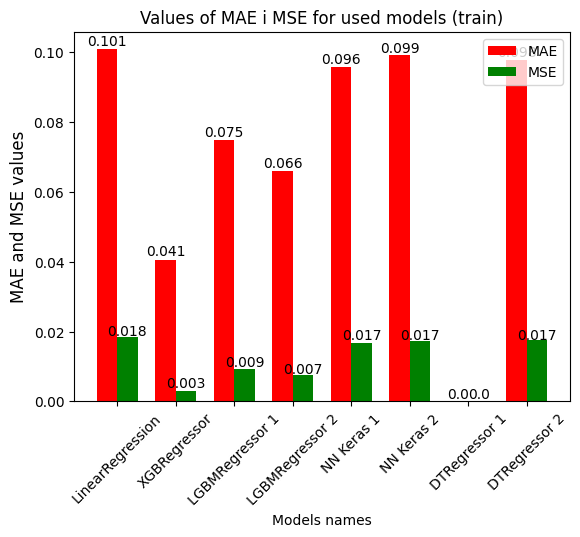

<Figure size 640x480 with 0 Axes>

In [1008]:
def get_all_mse_values(columns, y_values, prediction_set):
    return get_all_values(mean_squared_error, columns, y_values, prediction_set)


def get_all_mae_values(columns, y_values, prediction_set):
    return get_all_values(mean_absolute_error, columns, y_values, prediction_set)

train_mse_score_list = get_all_mse_values(NAMES_OF_PREDICTIONS_COLUMNS, y_train, predictions_df)
train_mae_score_list = get_all_mae_values(NAMES_OF_PREDICTIONS_COLUMNS, y_train, predictions_df)

indexes = np.arange(len(models_names))

width = 0.35

plt.bar(indexes, train_mae_score_list, width, color=['red'], label='MAE')
plt.bar(indexes + width, train_mse_score_list, width, color=['green'], label='MSE')


plt.title('Values of MAE i MSE for used models (train)')
plt.xticks(indexes + width/2, models_names, rotation=45)
plt.xlabel('Models names')
plt.ylabel('MAE and MSE values',  fontsize=12, va='bottom')
plt.legend()

add_values_on_diagram_bars(plt.gca())
plt.show()

plt.savefig('./diagrams/mae_mse_crdY_90_train.png')


So let's now calculate the mean value of number of yellow cards per 90 minutes scored by all players for the training data

In [1009]:
median_crdY_90 = predictions_df['CrdY/90'].median()
median_crdY_90

0.18518518518518517

Now, for each model, let's calculate what fraction of the average number of yellow cards per 90 minutes is due to their MAE and MSE errors.

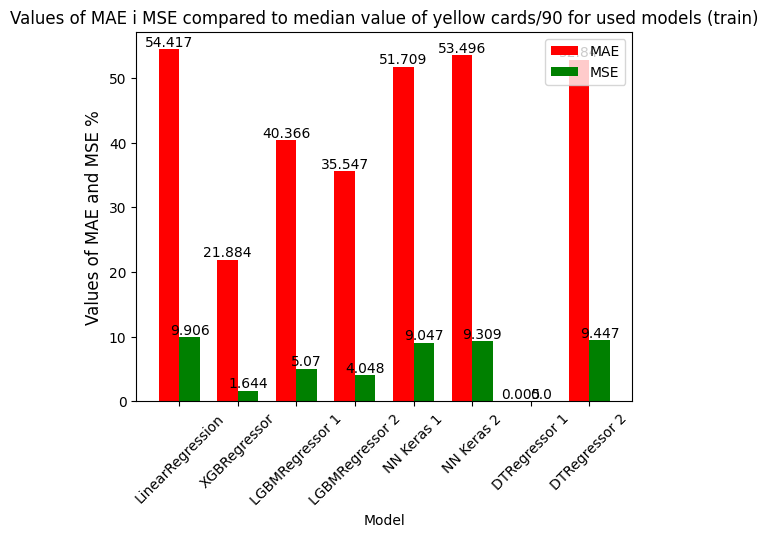

<Figure size 640x480 with 0 Axes>

In [1010]:
compared_to_prediction_mae_train = [error/median_crdY_90 * 100 for error in train_mae_score_list]

compared_to_prediction_mse_train = [error/median_crdY_90  * 100 for error in train_mse_score_list]

indexes = np.arange(len(models_names))

width = 0.35

plt.bar(indexes, compared_to_prediction_mae_train, width, color=['red'], label='MAE')
plt.bar(indexes + width, compared_to_prediction_mse_train, width, color=['green'], label='MSE')


plt.title('Values of MAE i MSE compared to median value of yellow cards/90 for used models (train)')
plt.xticks(indexes + width/2, models_names, rotation=45)
plt.xlabel('Model')
plt.ylabel('Values of MAE and MSE %',  fontsize=12, va='bottom')
plt.legend()

add_values_on_diagram_bars(plt.gca())
plt.show()

plt.savefig('./diagrams/compared_mae_mse_crdY_90_train.png')

In our case, the `MAE` will be a better indicator, because it indicates the real difference between the prediction and our data.

Unfortunately, for the training data alone, the smallest difference of 20% is quite a significant departure from reality and gives us reliable results.

Let's check how this situation looks for test data.

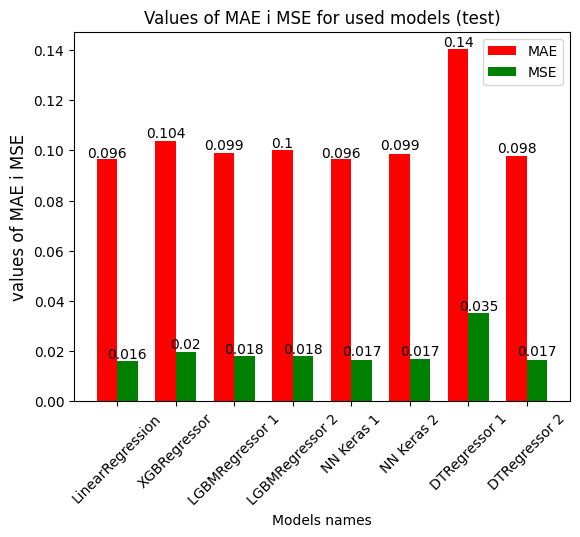

<Figure size 640x480 with 0 Axes>

In [1011]:
test_mse_score_list = get_all_mse_values(NAMES_OF_PREDICTIONS_COLUMNS, y_test, test_predictions_df)
test_mae_score_list = get_all_mae_values(NAMES_OF_PREDICTIONS_COLUMNS, y_test, test_predictions_df)

indexes = np.arange(len(models_names))

plt.bar(indexes, test_mae_score_list, width, color=['red'], label='MAE')
plt.bar(indexes + width, test_mse_score_list, width, color=['green'], label='MSE')


plt.title('Values of MAE i MSE for used models (test)')
plt.xticks(indexes + width/2, models_names, rotation=45)
plt.xlabel('Models names')
plt.ylabel('values of MAE i MSE',  fontsize=12, va='bottom')
plt.legend()

add_values_on_diagram_bars(plt.gca())
plt.show()

plt.savefig('./diagrams/mae_mse_crdY_90_test.png')

So let's now calculate the mean value of number of yellow cards per 90 minutes scored by all players for the test data

In [1012]:
median_crdY_90 = test_predictions_df['CrdY/90'].median()
median_crdY_90

0.18720794392523366

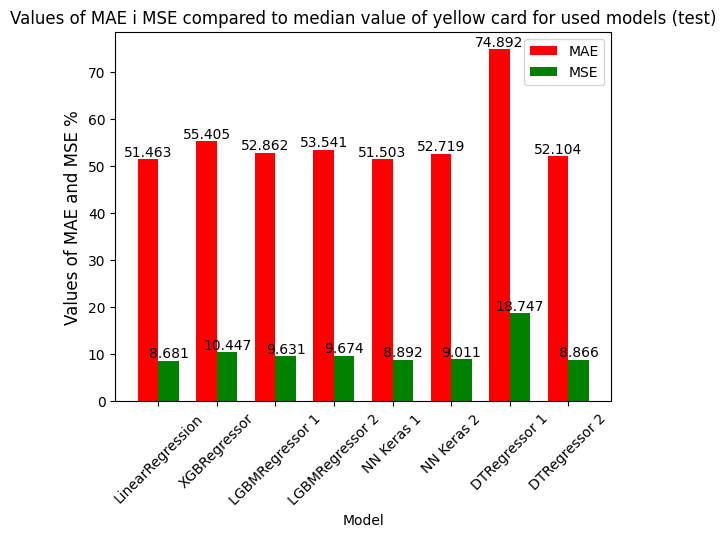

<Figure size 640x480 with 0 Axes>

In [1013]:

compared_to_prediction_mae_test = [error/median_crdY_90 * 100 for error in test_mae_score_list]

compared_to_prediction_mse_test = [error/median_crdY_90  * 100 for error in test_mse_score_list]

indexes = np.arange(len(models_names))

width = 0.35

plt.bar(indexes, compared_to_prediction_mae_test, width, color=['red'], label='MAE')
plt.bar(indexes + width, compared_to_prediction_mse_test, width, color=['green'], label='MSE')


plt.title('Values of MAE i MSE compared to median value of yellow card for used models (test)')
plt.xticks(indexes + width/2, models_names, rotation=45)
plt.xlabel('Model')
plt.ylabel('Values of MAE and MSE %',  fontsize=12, va='bottom')
plt.legend()

add_values_on_diagram_bars(plt.gca())
plt.show()

plt.savefig('./diagrams/compared_mae_mse_crdY_90_test.png')

Here the situation, as I expected, is even worse. The smallest `MAE` error is roughly half of the average number of yellow cards per player per 90 minutes.

Let's try to change tactics and predict the number of yellow cards throughout the season.


In [1014]:
predictions_df.to_csv('./checkpoints/prediction_df.csv')
test_predictions_df.to_csv('./checkpoints/test_prediction_df.csv')

To use player positions as a feature in our regression models, let's change the position names to appropriate numerical values that will help us in our calculations.

In [1015]:
pos_mapping = {'GK' : 1, 'DF': 2, 'MF': 3, 'FW': 4, 'DF,MF': 5 , 'DF,FW' : 6, 'FW,MF': 7}

players['Pos'] = players['Pos'].replace(pos_mapping)
players['Pos'] = players['Pos'].fillna(-1) 

We will use the following stats as our new traits:
+ Pos - player's position
+ Min - minutes played
+ Fls - number of fouls committed
+ Fld - number of fouls drawn
+ Int - number of interceptions (the catching of a pass by a player on an opposing team)
+ TklW - number of tackles in which the tackler's team won possession of the ball
+ Recov - number of loose balls recovered

We will use the same models in exactly the same way, and by comparing the results, we will be able to answer the question of whether our main hypothesis is correct.

Below, a LinearRegression object was created and our data was trained on it.

In [1016]:
lr = LinearRegression()

X_train, y_train = players[['Pos','Min' ,'Fls', 'Fld', 'Int', 'TklW', 'Recov']], players[['CrdY']]

model11 = lr.fit(X_train, y_train)
print(f'coef = {lr.coef_}')
print(f'intercept = {lr.intercept_}')

r_sqr = lr.score(X_train, y_train)
print(f'r^2 = {r_sqr}')


coef = [[-0.13721626  0.00021294  0.11574336  0.00635061  0.03066969 -0.00127684
   0.00028151]]
intercept = [0.6805319]
r^2 = 0.5476446686249803


Now let's make a prediction for our training data.

In [1017]:
predictions_df_1 = pd.DataFrame({
    'Player': players['Player'],
    'Pos': players['Pos'],
    'Min': players['Min'],
    'Fls': players['Fls'],
    'Fld': players['Fld'],
    'Int': players['Int'],
    'TklW': players['TklW'],
    'Recov': players["Recov"],
    'CrdY': players['CrdY'],
    'lr_p_CrdY': model11.predict(X_train).flatten()
})

predictions_df_1

Player  Pos     Min   Fls   Fld   Int  TklW  Recov  CrdY  \
0       Thomas Müller    3  2558.0  11.0  22.0  15.0  20.0   94.0   0.0   
1        Manuel Neuer    1  2510.0   0.0   1.0   0.0   1.0   85.0   0.0   
2      Joshua Kimmich    3  2474.0  20.0  46.0  52.0  20.0  218.0   4.0   
3     Dayot Upamecano    2  2211.0  28.0  11.0  32.0  42.0  249.0   4.0   
4        Serge Gnabry    6  2185.0  11.0  21.0  14.0  31.0  146.0   0.0   
...               ...  ...     ...   ...   ...   ...   ...    ...   ...   
3420  Luca Fiordilino    3   661.0   5.0  10.0  11.0  13.0   50.0   2.0   
3421       Dor Peretz    3   585.0  10.0   8.0   8.0  18.0   25.0   2.0   
3422  Francesco Forte    4   422.0  11.0   7.0   0.0   2.0   14.0   3.0   
3423     Marco Modolo    2   392.0   6.0   3.0   4.0   3.0   19.0   2.0   
3424             Nani    7   287.0   2.0   8.0   2.0   1.0   20.0   1.0   

      lr_p_CrdY  
0      2.687454  
1      1.106807  
2      5.033358  
3      5.185488  
4      2.159950  
...         ...  
3420   1.386705  
3421   1.831106  
3422   1.540548  
3423   1.327282  
3424   0.129117  

[3425 rows x 10 columns]

Let's now calculate the 2 main measures of our model's error

In [1018]:
mean_absolute_error(y_train, predictions_df_1['lr_p_CrdY']), mean_squared_error(y_train, predictions_df_1['lr_p_CrdY'])


(1.4217204682277602, 3.5468046029407985)


Here we will use the same test data, but we also need to adapt it to the new values.


In [1019]:
test_players['Pos'] = test_players['Pos'].astype(str)
test_players['Pos'] = test_players['Pos'].replace(pos_mapping)
test_players['Pos']


0      3
1      4
2      3
3      3
4      2
      ..
853    3
854    2
855    3
856    4
857    2
Name: Pos, Length: 858, dtype: int64

In [1020]:
test_predictions_df_1 = pd.DataFrame({
    'Player': test_players['Player'],
    'Pos': test_players['Pos'],
    'Min': test_players['Min'],
    'Fls': test_players['Fls'],
    'Fld': test_players['Fld'],
    'Int': test_players['Int'],
    'TklW': test_players['TklW'],
    'Recov': test_players["Recov"],
    'CrdY': test_players['CrdY']
})
test_predictions_df_1

Player  Pos     Min  Fls  Fld  Int  TklW  Recov  CrdY
0                 Rodri    3  2911.0   47   20   33    41  301.0   5.0
1        Erling Haaland    4  2769.0   31   24    3     2   37.0   5.0
2       Kevin De Bruyne    3  2417.0   20   29    9    12   97.0   1.0
3        İlkay Gündoğan    3  2353.0   22   25   20    18  155.0   0.0
4         Manuel Akanji    2  2287.0   24   12   16    25  136.0   2.0
..                  ...  ...     ...  ...  ...  ...   ...    ...   ...
853      Gonzalo Villar    3   696.0   17   18    4     7   55.0   2.0
854        Koray Günter    2   731.0    7    2   11     7   47.0   2.0
855       Valerio Verre    3   677.0   14   13    9     7   61.0   5.0
856  Fabio Quagliarella    4   628.0    4   18    0     1   25.0   2.0
857        Nicola Murru    2   650.0   12    6    8    13   31.0   2.0

[858 rows x 9 columns]

Let's update our testing data with other stats as well and make a prediction for our testing data.

In [1021]:
X_test, y_test = test_players[['Pos', 'Min', 'Fls' ,'Fld', 'Int', 'TklW', 'Recov']], test_players['CrdY']

test_predictions_df_1['lr_p_CrdY'] = model11.predict(X_test).flatten()

test_predictions_df_1

Player  Pos     Min  Fls  Fld  Int  TklW  Recov  CrdY  \
0                 Rodri    3  2911.0   47   20   33    41  301.0   5.0   
1        Erling Haaland    4  2769.0   31   24    3     2   37.0   5.0   
2       Kevin De Bruyne    3  2417.0   20   29    9    12   97.0   1.0   
3        İlkay Gündoğan    3  2353.0   22   25   20    18  155.0   0.0   
4         Manuel Akanji    2  2287.0   24   12   16    25  136.0   2.0   
..                  ...  ...     ...  ...  ...  ...   ...    ...   ...   
853      Gonzalo Villar    3   696.0   17   18    4     7   55.0   2.0   
854        Koray Günter    2   731.0    7    2   11     7   47.0   2.0   
855       Valerio Verre    3   677.0   14   13    9     7   61.0   5.0   
856  Fabio Quagliarella    4   628.0    4   18    0     1   25.0   2.0   
857        Nicola Murru    2   650.0   12    6    8    13   31.0   2.0   

     lr_p_CrdY  
0     7.500197  
1     4.561638  
2     3.570615  
3     4.109104  
4     4.244229  
..         ...  
853   2.628264  
854   1.726326  
855   2.400273  
856   0.848441  
857   2.209022  

[858 rows x 10 columns]

Although the numbers of yellow cards are integers, I will not make any rounding, as this may affect the final values of r² or `MAE` and `MSE` errors.

In [1022]:
r_sqr = lr.score(X_test, test_predictions_df_1['CrdY'])
print(f'r^2 = {r_sqr}')

r^2 = 0.5486357151139903


In [1023]:
mean_absolute_error(y_test, test_predictions_df_1['lr_p_CrdY']), mean_squared_error(y_test, test_predictions_df_1['lr_p_CrdY'])

(1.309958552487941, 3.041964522498542)

And now to compare our results to reality.

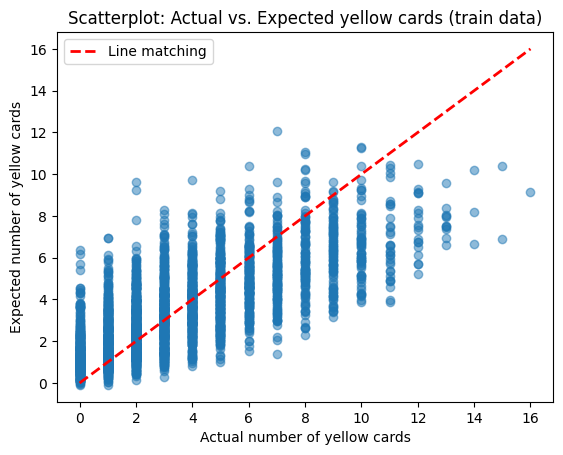

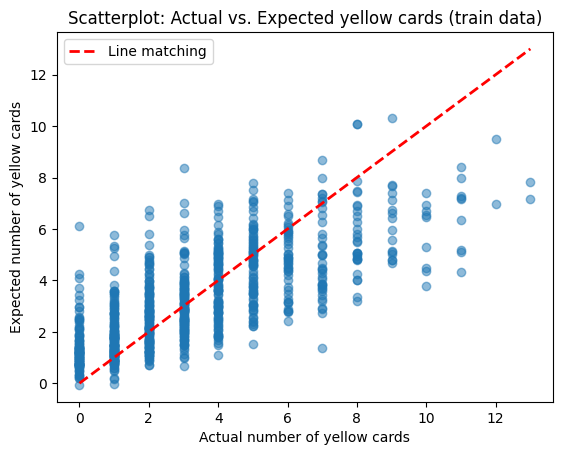

In [1024]:
generate_a_comparison_of_prediction_and_reality('yellow cards', predictions_df_1['CrdY'], predictions_df_1['lr_p_CrdY'], 'train')
generate_a_comparison_of_prediction_and_reality('yellow cards', test_predictions_df_1['CrdY'], test_predictions_df_1['lr_p_CrdY'], 'train')


Now it's time for another model we already know - `XGBRegressor`

In [1025]:
xgbr = XGBRegressor()

model22 = xgbr.fit(X_train, y_train)

r_sqr = xgbr.score(X_train, y_train)
print(f'r^2 = {r_sqr}')


r^2 = 0.9380073904218715


Now let's make a prediction for our training data.

In [1026]:
predictions_df_1['xgbr_p_CrdY'] = model22.predict(X_train).flatten()
predictions_df_1

Player  Pos     Min   Fls   Fld   Int  TklW  Recov  CrdY  \
0       Thomas Müller    3  2558.0  11.0  22.0  15.0  20.0   94.0   0.0   
1        Manuel Neuer    1  2510.0   0.0   1.0   0.0   1.0   85.0   0.0   
2      Joshua Kimmich    3  2474.0  20.0  46.0  52.0  20.0  218.0   4.0   
3     Dayot Upamecano    2  2211.0  28.0  11.0  32.0  42.0  249.0   4.0   
4        Serge Gnabry    6  2185.0  11.0  21.0  14.0  31.0  146.0   0.0   
...               ...  ...     ...   ...   ...   ...   ...    ...   ...   
3420  Luca Fiordilino    3   661.0   5.0  10.0  11.0  13.0   50.0   2.0   
3421       Dor Peretz    3   585.0  10.0   8.0   8.0  18.0   25.0   2.0   
3422  Francesco Forte    4   422.0  11.0   7.0   0.0   2.0   14.0   3.0   
3423     Marco Modolo    2   392.0   6.0   3.0   4.0   3.0   19.0   2.0   
3424             Nani    7   287.0   2.0   8.0   2.0   1.0   20.0   1.0   

      lr_p_CrdY  xgbr_p_CrdY  
0      2.687454     0.575441  
1      1.106807     0.025646  
2      5.033358     4.254878  
3      5.185488     4.114817  
4      2.159950    -0.002485  
...         ...          ...  
3420   1.386705     1.644959  
3421   1.831106     2.011050  
3422   1.540548     1.992890  
3423   1.327282     2.072019  
3424   0.129117     0.519256  

[3425 rows x 11 columns]

Let's now calculate the 2 main measures of our model's error for training data:

In [1027]:
mean_absolute_error(y_train, predictions_df_1['xgbr_p_CrdY']), mean_squared_error(y_train, predictions_df_1['xgbr_p_CrdY'])

(0.5140088740325989, 0.4860684902986866)

Now let's make a prediction for our testing data.

In [1028]:
test_predictions_df_1['xgbr_p_CrdY'] = model22.predict(X_test).flatten()

test_predictions_df_1

Player  Pos     Min  Fls  Fld  Int  TklW  Recov  CrdY  \
0                 Rodri    3  2911.0   47   20   33    41  301.0   5.0   
1        Erling Haaland    4  2769.0   31   24    3     2   37.0   5.0   
2       Kevin De Bruyne    3  2417.0   20   29    9    12   97.0   1.0   
3        İlkay Gündoğan    3  2353.0   22   25   20    18  155.0   0.0   
4         Manuel Akanji    2  2287.0   24   12   16    25  136.0   2.0   
..                  ...  ...     ...  ...  ...  ...   ...    ...   ...   
853      Gonzalo Villar    3   696.0   17   18    4     7   55.0   2.0   
854        Koray Günter    2   731.0    7    2   11     7   47.0   2.0   
855       Valerio Verre    3   677.0   14   13    9     7   61.0   5.0   
856  Fabio Quagliarella    4   628.0    4   18    0     1   25.0   2.0   
857        Nicola Murru    2   650.0   12    6    8    13   31.0   2.0   

     lr_p_CrdY  xgbr_p_CrdY  
0     7.500197    10.020272  
1     4.561638     1.369111  
2     3.570615     2.393644  
3     4.109104     4.437050  
4     4.244229     4.518568  
..         ...          ...  
853   2.628264     2.900242  
854   1.726326     1.572734  
855   2.400273     2.015562  
856   0.848441     0.226073  
857   2.209022     3.510860  

[858 rows x 11 columns]

Now let's calculate the quality measures of our XBGRegressor model:

In [1029]:
r_sqr = xgbr.score(X_test, test_predictions_df_1['CrdY'])
print(f'r^2 = {r_sqr}')

r^2 = 0.47976987084921585


In [1030]:
mean_absolute_error(y_test, test_predictions_df_1['xgbr_p_CrdY']), mean_squared_error(y_test, test_predictions_df_1['xgbr_p_CrdY'])

(1.4031562629722423, 3.50608510553993)

And now to compare our results to reality.

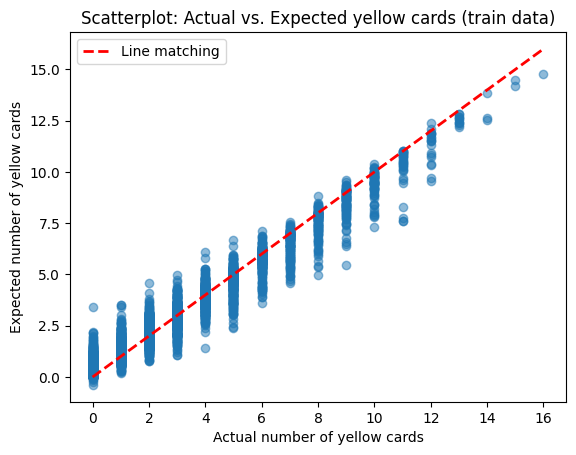

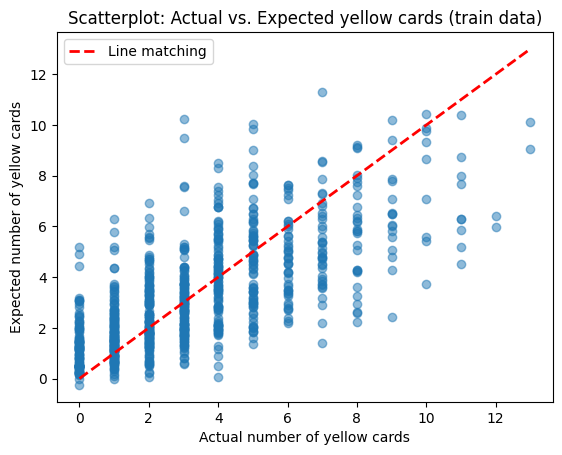

In [1031]:
generate_a_comparison_of_prediction_and_reality('yellow cards', predictions_df_1['CrdY'], predictions_df_1['xgbr_p_CrdY'], 'train')
generate_a_comparison_of_prediction_and_reality('yellow cards', test_predictions_df_1['CrdY'], test_predictions_df_1['xgbr_p_CrdY'], 'train')

For the `LGBMRegressor` model, the calculations were made again in two ways - without and with parameters.

In [1032]:
lgbm = LGBMRegressor()
model33 = lgbm.fit(X_train, y_train)

r_sqr = lgbm.score(X_train, y_train)
print(f'r^2 = {r_sqr}')
print(f'params = {lgbm.get_params}')

r^2 = 0.7835015105579289
params = <bound method LGBMModel.get_params of LGBMRegressor()>


Now let's make a prediction for our training data.


In [1033]:
predictions_df_1['lgbm1_p_CrdY'] = model33.predict(X_train).flatten()

predictions_df_1


Player  Pos     Min   Fls   Fld   Int  TklW  Recov  CrdY  \
0       Thomas Müller    3  2558.0  11.0  22.0  15.0  20.0   94.0   0.0   
1        Manuel Neuer    1  2510.0   0.0   1.0   0.0   1.0   85.0   0.0   
2      Joshua Kimmich    3  2474.0  20.0  46.0  52.0  20.0  218.0   4.0   
3     Dayot Upamecano    2  2211.0  28.0  11.0  32.0  42.0  249.0   4.0   
4        Serge Gnabry    6  2185.0  11.0  21.0  14.0  31.0  146.0   0.0   
...               ...  ...     ...   ...   ...   ...   ...    ...   ...   
3420  Luca Fiordilino    3   661.0   5.0  10.0  11.0  13.0   50.0   2.0   
3421       Dor Peretz    3   585.0  10.0   8.0   8.0  18.0   25.0   2.0   
3422  Francesco Forte    4   422.0  11.0   7.0   0.0   2.0   14.0   3.0   
3423     Marco Modolo    2   392.0   6.0   3.0   4.0   3.0   19.0   2.0   
3424             Nani    7   287.0   2.0   8.0   2.0   1.0   20.0   1.0   

      lr_p_CrdY  xgbr_p_CrdY  lgbm1_p_CrdY  
0      2.687454     0.575441      1.780699  
1      1.106807     0.025646      1.245144  
2      5.033358     4.254878      4.455744  
3      5.185488     4.114817      5.274376  
4      2.159950    -0.002485      0.974105  
...         ...          ...           ...  
3420   1.386705     1.644959      1.249192  
3421   1.831106     2.011050      1.604853  
3422   1.540548     1.992890      1.530462  
3423   1.327282     2.072019      1.567257  
3424   0.129117     0.519256      0.420793  

[3425 rows x 12 columns]

Let's now calculate the 2 main measures of our model's error for training data:

In [1034]:
mean_absolute_error(y_train, predictions_df_1['lgbm1_p_CrdY']), mean_squared_error(y_train, predictions_df_1['lgbm1_p_CrdY'])

(1.0210278877248018, 1.697510310199633)

Now let's make a prediction for our testing data.

In [1035]:
test_predictions_df_1['lgbm1_p_CrdY'] = model33.predict(X_test).flatten()

test_predictions_df_1

Player  Pos     Min  Fls  Fld  Int  TklW  Recov  CrdY  \
0                 Rodri    3  2911.0   47   20   33    41  301.0   5.0   
1        Erling Haaland    4  2769.0   31   24    3     2   37.0   5.0   
2       Kevin De Bruyne    3  2417.0   20   29    9    12   97.0   1.0   
3        İlkay Gündoğan    3  2353.0   22   25   20    18  155.0   0.0   
4         Manuel Akanji    2  2287.0   24   12   16    25  136.0   2.0   
..                  ...  ...     ...  ...  ...  ...   ...    ...   ...   
853      Gonzalo Villar    3   696.0   17   18    4     7   55.0   2.0   
854        Koray Günter    2   731.0    7    2   11     7   47.0   2.0   
855       Valerio Verre    3   677.0   14   13    9     7   61.0   5.0   
856  Fabio Quagliarella    4   628.0    4   18    0     1   25.0   2.0   
857        Nicola Murru    2   650.0   12    6    8    13   31.0   2.0   

     lr_p_CrdY  xgbr_p_CrdY  lgbm1_p_CrdY  
0     7.500197    10.020272      8.631900  
1     4.561638     1.369111      3.433525  
2     3.570615     2.393644      3.324976  
3     4.109104     4.437050      5.120948  
4     4.244229     4.518568      5.361538  
..         ...          ...           ...  
853   2.628264     2.900242      3.141624  
854   1.726326     1.572734      1.392935  
855   2.400273     2.015562      2.113059  
856   0.848441     0.226073      0.957397  
857   2.209022     3.510860      2.408798  

[858 rows x 12 columns]

Now let's calculate the quality measures of our first LGBMRegressor model:

In [1036]:
r_sqr = lgbm.score(X_test, y_test)
print(f'r^2 = {r_sqr}')

r^2 = 0.5088225621546916


In [1037]:
mean_absolute_error(y_test, test_predictions_df_1['lgbm1_p_CrdY']), mean_squared_error(y_test, test_predictions_df_1['lgbm1_p_CrdY'])

(1.3597156663748358, 3.31028481917771)

And now to compare our results to reality.

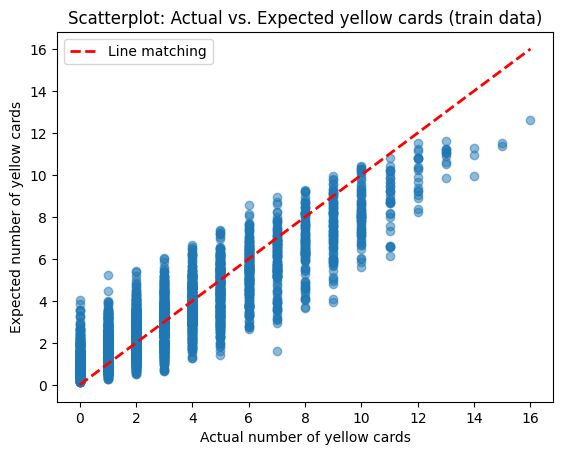

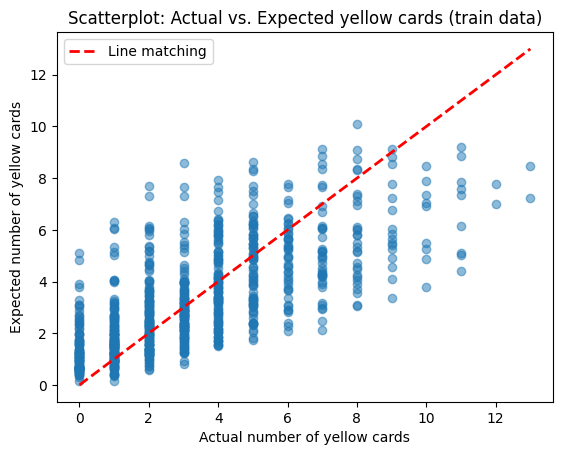

In [1038]:
generate_a_comparison_of_prediction_and_reality('yellow cards', predictions_df_1['CrdY'], predictions_df_1['lgbm1_p_CrdY'], 'train')
generate_a_comparison_of_prediction_and_reality('yellow cards', test_predictions_df_1['CrdY'], test_predictions_df_1['lgbm1_p_CrdY'], 'train')


This time we will apply the same parameters to the `LGBMRegressor` model as before

In [1039]:
lgbm = LGBMRegressor(objective='regression', 
                    n_estimators=750, 
                    max_depth=4, 
                    learning_rate=0.05, 
                    min_child_samples=1,
                    colsample_bytree=0.9,
                    subsample=0.9,
                    random_state=101)

model44 = lgbm.fit(X_train, y_train)

r_sqr = lgbm.score(X_train, y_train)
print(f'r^2 = {r_sqr}')
print(f'params = {lgbm.get_params}')

r^2 = 0.8217995492872137
params = <bound method LGBMModel.get_params of LGBMRegressor(colsample_bytree=0.9, learning_rate=0.05, max_depth=4,
              min_child_samples=1, n_estimators=750, objective='regression',
              random_state=101, subsample=0.9)>


Now let's make a prediction for our training data.


In [1040]:
predictions_df_1['lgbm2_p_CrdY'] = model44.predict(X_train).flatten()
predictions_df_1


Player  Pos     Min   Fls   Fld   Int  TklW  Recov  CrdY  \
0       Thomas Müller    3  2558.0  11.0  22.0  15.0  20.0   94.0   0.0   
1        Manuel Neuer    1  2510.0   0.0   1.0   0.0   1.0   85.0   0.0   
2      Joshua Kimmich    3  2474.0  20.0  46.0  52.0  20.0  218.0   4.0   
3     Dayot Upamecano    2  2211.0  28.0  11.0  32.0  42.0  249.0   4.0   
4        Serge Gnabry    6  2185.0  11.0  21.0  14.0  31.0  146.0   0.0   
...               ...  ...     ...   ...   ...   ...   ...    ...   ...   
3420  Luca Fiordilino    3   661.0   5.0  10.0  11.0  13.0   50.0   2.0   
3421       Dor Peretz    3   585.0  10.0   8.0   8.0  18.0   25.0   2.0   
3422  Francesco Forte    4   422.0  11.0   7.0   0.0   2.0   14.0   3.0   
3423     Marco Modolo    2   392.0   6.0   3.0   4.0   3.0   19.0   2.0   
3424             Nani    7   287.0   2.0   8.0   2.0   1.0   20.0   1.0   

      lr_p_CrdY  xgbr_p_CrdY  lgbm1_p_CrdY  lgbm2_p_CrdY  
0      2.687454     0.575441      1.780699      2.053421  
1      1.106807     0.025646      1.245144      0.501411  
2      5.033358     4.254878      4.455744      4.272967  
3      5.185488     4.114817      5.274376      4.310365  
4      2.159950    -0.002485      0.974105      1.302827  
...         ...          ...           ...           ...  
3420   1.386705     1.644959      1.249192      1.480984  
3421   1.831106     2.011050      1.604853      2.031186  
3422   1.540548     1.992890      1.530462      1.493729  
3423   1.327282     2.072019      1.567257      1.466908  
3424   0.129117     0.519256      0.420793      0.439774  

[3425 rows x 13 columns]

Let's now calculate the 2 main measures of our model's error for training data:

In [1041]:
mean_absolute_error(y_train, predictions_df_1['lgbm2_p_CrdY']), mean_squared_error(y_train, predictions_df_1['lgbm2_p_CrdY'])

(0.9099486570693515, 1.3972250021084613)

Now let's make a prediction for our testing data.

In [1042]:
test_predictions_df_1['lgbm2_p_CrdY'] = model44.predict(X_test).flatten()

test_predictions_df_1

Player  Pos     Min  Fls  Fld  Int  TklW  Recov  CrdY  \
0                 Rodri    3  2911.0   47   20   33    41  301.0   5.0   
1        Erling Haaland    4  2769.0   31   24    3     2   37.0   5.0   
2       Kevin De Bruyne    3  2417.0   20   29    9    12   97.0   1.0   
3        İlkay Gündoğan    3  2353.0   22   25   20    18  155.0   0.0   
4         Manuel Akanji    2  2287.0   24   12   16    25  136.0   2.0   
..                  ...  ...     ...  ...  ...  ...   ...    ...   ...   
853      Gonzalo Villar    3   696.0   17   18    4     7   55.0   2.0   
854        Koray Günter    2   731.0    7    2   11     7   47.0   2.0   
855       Valerio Verre    3   677.0   14   13    9     7   61.0   5.0   
856  Fabio Quagliarella    4   628.0    4   18    0     1   25.0   2.0   
857        Nicola Murru    2   650.0   12    6    8    13   31.0   2.0   

     lr_p_CrdY  xgbr_p_CrdY  lgbm1_p_CrdY  lgbm2_p_CrdY  
0     7.500197    10.020272      8.631900     10.484989  
1     4.561638     1.369111      3.433525      3.396009  
2     3.570615     2.393644      3.324976      2.881410  
3     4.109104     4.437050      5.120948      5.036146  
4     4.244229     4.518568      5.361538      4.763816  
..         ...          ...           ...           ...  
853   2.628264     2.900242      3.141624      3.154168  
854   1.726326     1.572734      1.392935      1.663254  
855   2.400273     2.015562      2.113059      1.931106  
856   0.848441     0.226073      0.957397      0.881647  
857   2.209022     3.510860      2.408798      2.664880  

[858 rows x 13 columns]

Now let's calculate the quality measures of our second `LGBMRegressor` model:


In [1043]:
r_sqr = lgbm.score(X_test, y_test)
print(f'r^2 = {r_sqr}')

r^2 = 0.5192092415584905


In [1044]:
mean_absolute_error(y_test, test_predictions_df_1['lgbm2_p_CrdY']), mean_squared_error(y_test, test_predictions_df_1['lgbm2_p_CrdY'])

(1.347119046192736, 3.240283910131701)

And now to compare our results to reality.

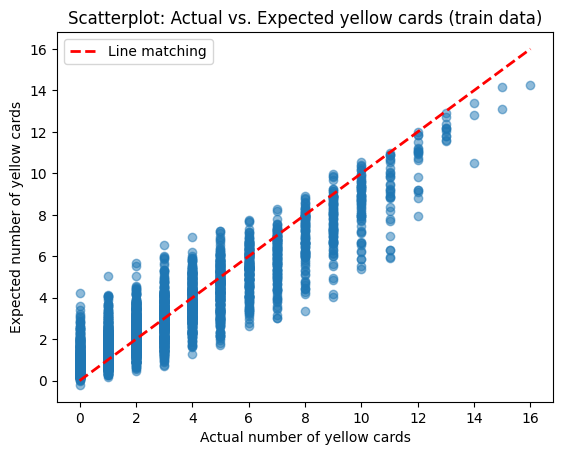

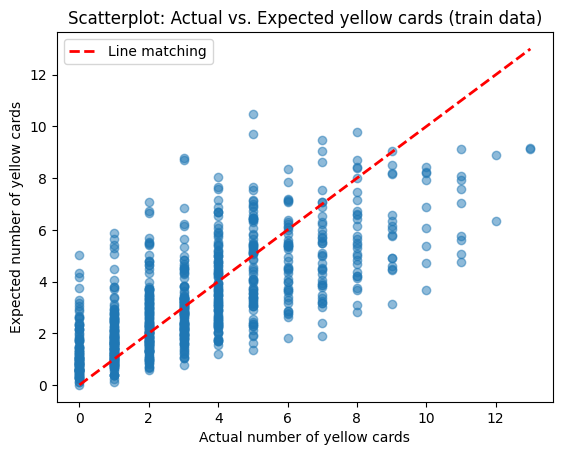

In [1045]:
generate_a_comparison_of_prediction_and_reality('yellow cards', predictions_df_1['CrdY'], predictions_df_1['lgbm2_p_CrdY'], 'train')
generate_a_comparison_of_prediction_and_reality('yellow cards', test_predictions_df_1['CrdY'], test_predictions_df_1['lgbm2_p_CrdY'], 'train')

Now it's the turn of neural networks and, like the previous models, they will be launched with the same parameters.

c:\Users\trine\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


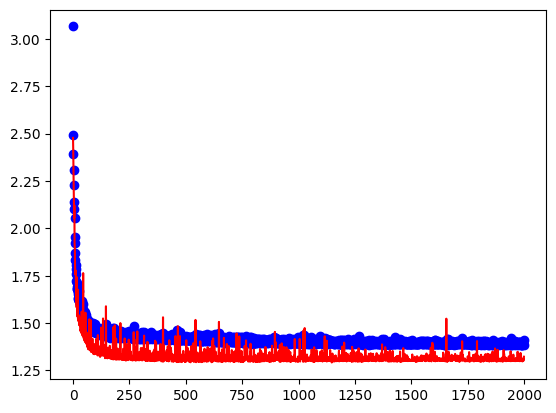

In [1046]:

model55 = Sequential()
model55.add(Dense(13, input_shape=(7,), activation='relu'))
model55.add(Dense(13, activation='relu'))
model55.add(Dense(13, activation='relu'))
model55.add(Dense(13, activation='relu'))
model55.add(Dense(13, activation='relu'))
model55.add(Dense(1,))
model55.compile(Adam(lr=0.0001), 'mean_absolute_error')


model55_hist = model55.fit(X_train, y_train, epochs = 2000, validation_split = 0, validation_data=(X_test, y_test), verbose = 0)

model55_dict = model55_hist.history
loss_values = model55_dict['loss']
val_loss_values = model55_dict['val_loss']
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='training loss val')

plt.savefig(f'./diagrams/keras{counter}.png')
counter += 1

Now let's make a prediction for our training data.

In [1047]:
predictions_df_1['krs1_p_CrdY'] = model55.predict(X_train)

predictions_df_1

108/108 [==============================] - 0s 867us/step


Player  Pos     Min   Fls   Fld   Int  TklW  Recov  CrdY  \
0       Thomas Müller    3  2558.0  11.0  22.0  15.0  20.0   94.0   0.0   
1        Manuel Neuer    1  2510.0   0.0   1.0   0.0   1.0   85.0   0.0   
2      Joshua Kimmich    3  2474.0  20.0  46.0  52.0  20.0  218.0   4.0   
3     Dayot Upamecano    2  2211.0  28.0  11.0  32.0  42.0  249.0   4.0   
4        Serge Gnabry    6  2185.0  11.0  21.0  14.0  31.0  146.0   0.0   
...               ...  ...     ...   ...   ...   ...   ...    ...   ...   
3420  Luca Fiordilino    3   661.0   5.0  10.0  11.0  13.0   50.0   2.0   
3421       Dor Peretz    3   585.0  10.0   8.0   8.0  18.0   25.0   2.0   
3422  Francesco Forte    4   422.0  11.0   7.0   0.0   2.0   14.0   3.0   
3423     Marco Modolo    2   392.0   6.0   3.0   4.0   3.0   19.0   2.0   
3424             Nani    7   287.0   2.0   8.0   2.0   1.0   20.0   1.0   

      lr_p_CrdY  xgbr_p_CrdY  lgbm1_p_CrdY  lgbm2_p_CrdY  krs1_p_CrdY  
0      2.687454     0.575441      1.780699      2.053421     1.745175  
1      1.106807     0.025646      1.245144      0.501411     0.196272  
2      5.033358     4.254878      4.455744      4.272967     3.723741  
3      5.185488     4.114817      5.274376      4.310365     3.721553  
4      2.159950    -0.002485      0.974105      1.302827     1.127612  
...         ...          ...           ...           ...          ...  
3420   1.386705     1.644959      1.249192      1.480984     0.867862  
3421   1.831106     2.011050      1.604853      2.031186     1.628948  
3422   1.540548     1.992890      1.530462      1.493729     1.255467  
3423   1.327282     2.072019      1.567257      1.466908     1.178278  
3424   0.129117     0.519256      0.420793      0.439774    -0.143143  

[3425 rows x 14 columns]

R² for our first neural networks for training data is:

In [1048]:
r2_score(y_train, predictions_df_1['krs1_p_CrdY'])

0.536508965329957

Let's now calculate the 2 main measures of our model's error for training data:


In [1049]:
mean_absolute_error(y_train, predictions_df_1['krs1_p_CrdY']), mean_squared_error(y_train, predictions_df_1['krs1_p_CrdY'])

(1.4000371686559523, 3.634116857189501)

Now let's make a prediction for our testing data.

In [1050]:
test_predictions_df_1['krs1_p_CrdY'] = model55.predict(X_test)

test_predictions_df_1

27/27 [==============================] - 0s 1ms/step


Player  Pos     Min  Fls  Fld  Int  TklW  Recov  CrdY  \
0                 Rodri    3  2911.0   47   20   33    41  301.0   5.0   
1        Erling Haaland    4  2769.0   31   24    3     2   37.0   5.0   
2       Kevin De Bruyne    3  2417.0   20   29    9    12   97.0   1.0   
3        İlkay Gündoğan    3  2353.0   22   25   20    18  155.0   0.0   
4         Manuel Akanji    2  2287.0   24   12   16    25  136.0   2.0   
..                  ...  ...     ...  ...  ...  ...   ...    ...   ...   
853      Gonzalo Villar    3   696.0   17   18    4     7   55.0   2.0   
854        Koray Günter    2   731.0    7    2   11     7   47.0   2.0   
855       Valerio Verre    3   677.0   14   13    9     7   61.0   5.0   
856  Fabio Quagliarella    4   628.0    4   18    0     1   25.0   2.0   
857        Nicola Murru    2   650.0   12    6    8    13   31.0   2.0   

     lr_p_CrdY  xgbr_p_CrdY  lgbm1_p_CrdY  lgbm2_p_CrdY  krs1_p_CrdY  
0     7.500197    10.020272      8.631900     10.484989     6.398838  
1     4.561638     1.369111      3.433525      3.396009     4.570225  
2     3.570615     2.393644      3.324976      2.881410     2.565971  
3     4.109104     4.437050      5.120948      5.036146     3.512743  
4     4.244229     4.518568      5.361538      4.763816     3.788567  
..         ...          ...           ...           ...          ...  
853   2.628264     2.900242      3.141624      3.154168     2.599076  
854   1.726326     1.572734      1.392935      1.663254     1.360128  
855   2.400273     2.015562      2.113059      1.931106     2.184376  
856   0.848441     0.226073      0.957397      0.881647     0.678585  
857   2.209022     3.510860      2.408798      2.664880     2.003186  

[858 rows x 14 columns]

R² for our first neural networks for testing data is:

In [1051]:
r2_score(y_test, test_predictions_df_1['krs1_p_CrdY'])

0.514672512979618

Let's now calculate the 2 main measures of our model's error for testing data:


In [1052]:
mean_absolute_error(y_test, test_predictions_df_1['krs1_p_CrdY']), mean_squared_error(y_test, test_predictions_df_1['krs1_p_CrdY'])

(1.32248999694219, 3.270859141374511)

And now to compare our results to reality.

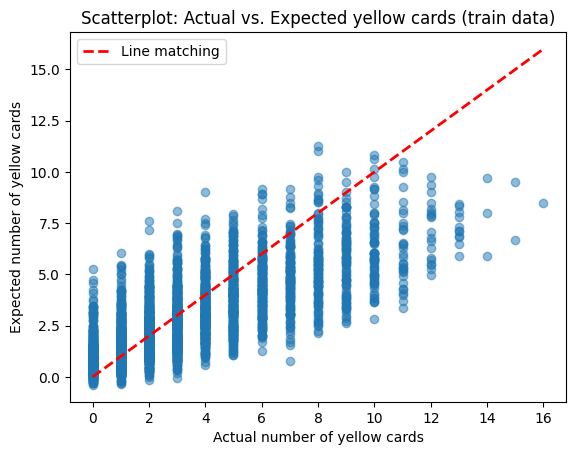

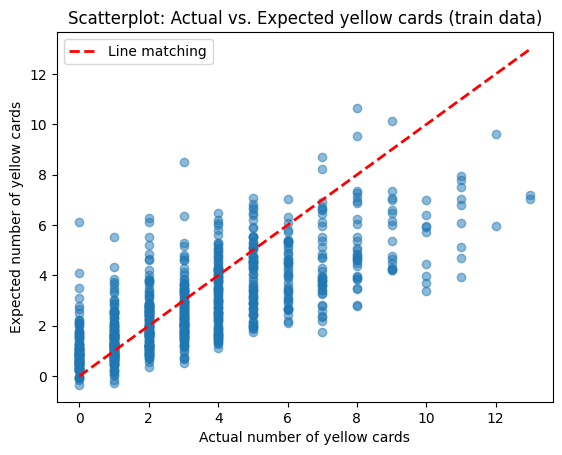

In [1053]:
generate_a_comparison_of_prediction_and_reality('yellow cards', predictions_df_1['CrdY'], predictions_df_1['krs1_p_CrdY'], 'train')
generate_a_comparison_of_prediction_and_reality('yellow cards', test_predictions_df_1['CrdY'], test_predictions_df_1['krs1_p_CrdY'], 'train')

Neural networks with stopping condition:

c:\Users\trine\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 146: early stopping


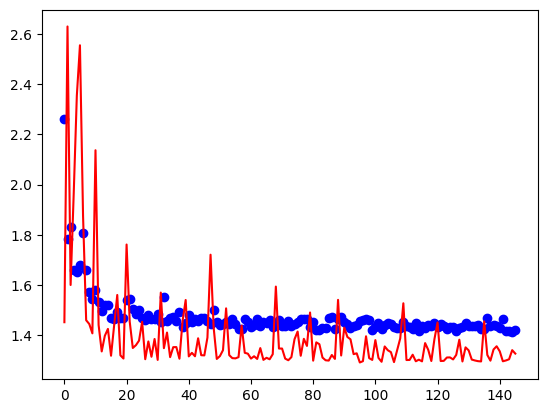

In [1054]:
model66 = Sequential()
model66.add(Dense(13, input_shape=(7,), activation='relu'))
model66.add(Dense(13, activation='relu'))
model66.add(Dense(13, activation='relu'))
model66.add(Dense(13, activation='relu'))
model66.add(Dense(13, activation='relu'))
model66.add(Dense(1,))
model66.compile(Adam(lr=0.003), 'mean_absolute_error')

earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='min')
model66_hist = model66.fit(X_train, y_train, epochs = 2000, validation_split = 0, validation_data=(X_test, y_test), shuffle = True, verbose = 0, callbacks = [earlystopper])

model66_dict = model66_hist.history
loss_values = model66_dict['loss']
val_loss_values = model66_dict['val_loss']
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='training loss val')

plt.savefig(f'./diagrams/keras{counter}.png')
counter += 1

The diagram above shows how the error of our model decreased over the epochs.

Now let's make a prediction for our training data.

In [1055]:
predictions_df_1['krs2_p_CrdY'] = model66.predict(X_train)

predictions_df_1

108/108 [==============================] - 0s 1ms/step


Player  Pos     Min   Fls   Fld   Int  TklW  Recov  CrdY  \
0       Thomas Müller    3  2558.0  11.0  22.0  15.0  20.0   94.0   0.0   
1        Manuel Neuer    1  2510.0   0.0   1.0   0.0   1.0   85.0   0.0   
2      Joshua Kimmich    3  2474.0  20.0  46.0  52.0  20.0  218.0   4.0   
3     Dayot Upamecano    2  2211.0  28.0  11.0  32.0  42.0  249.0   4.0   
4        Serge Gnabry    6  2185.0  11.0  21.0  14.0  31.0  146.0   0.0   
...               ...  ...     ...   ...   ...   ...   ...    ...   ...   
3420  Luca Fiordilino    3   661.0   5.0  10.0  11.0  13.0   50.0   2.0   
3421       Dor Peretz    3   585.0  10.0   8.0   8.0  18.0   25.0   2.0   
3422  Francesco Forte    4   422.0  11.0   7.0   0.0   2.0   14.0   3.0   
3423     Marco Modolo    2   392.0   6.0   3.0   4.0   3.0   19.0   2.0   
3424             Nani    7   287.0   2.0   8.0   2.0   1.0   20.0   1.0   

      lr_p_CrdY  xgbr_p_CrdY  lgbm1_p_CrdY  lgbm2_p_CrdY  krs1_p_CrdY  \
0      2.687454     0.575441      1.780699      2.053421     1.745175   
1      1.106807     0.025646      1.245144      0.501411     0.196272   
2      5.033358     4.254878      4.455744      4.272967     3.723741   
3      5.185488     4.114817      5.274376      4.310365     3.721553   
4      2.159950    -0.002485      0.974105      1.302827     1.127612   
...         ...          ...           ...           ...          ...   
3420   1.386705     1.644959      1.249192      1.480984     0.867862   
3421   1.831106     2.011050      1.604853      2.031186     1.628948   
3422   1.540548     1.992890      1.530462      1.493729     1.255467   
3423   1.327282     2.072019      1.567257      1.466908     1.178278   
3424   0.129117     0.519256      0.420793      0.439774    -0.143143   

      krs2_p_CrdY  
0        1.887098  
1        1.674552  
2        4.505623  
3        4.586601  
4        1.750225  
...           ...  
3420     1.224555  
3421     1.516258  
3422     1.305703  
3423     1.134692  
3424     0.001487  

[3425 rows x 15 columns]

R² for our second neural networks for training data is:

In [1056]:
r2_score(y_train, predictions_df_1['krs2_p_CrdY'])

0.5171320182385406

Let's now calculate the 2 main measures of our model's error for training data:

In [1057]:
mean_absolute_error(y_train, predictions_df_1['krs2_p_CrdY']), mean_squared_error(y_train, predictions_df_1['krs2_p_CrdY'])

(1.4231283656437033, 3.786046635326236)

Now let's make a prediction for our testing data.

In [1058]:
test_predictions_df_1['krs2_p_CrdY'] = model66.predict(X_test)

test_predictions_df_1

27/27 [==============================] - 0s 908us/step


Player  Pos     Min  Fls  Fld  Int  TklW  Recov  CrdY  \
0                 Rodri    3  2911.0   47   20   33    41  301.0   5.0   
1        Erling Haaland    4  2769.0   31   24    3     2   37.0   5.0   
2       Kevin De Bruyne    3  2417.0   20   29    9    12   97.0   1.0   
3        İlkay Gündoğan    3  2353.0   22   25   20    18  155.0   0.0   
4         Manuel Akanji    2  2287.0   24   12   16    25  136.0   2.0   
..                  ...  ...     ...  ...  ...  ...   ...    ...   ...   
853      Gonzalo Villar    3   696.0   17   18    4     7   55.0   2.0   
854        Koray Günter    2   731.0    7    2   11     7   47.0   2.0   
855       Valerio Verre    3   677.0   14   13    9     7   61.0   5.0   
856  Fabio Quagliarella    4   628.0    4   18    0     1   25.0   2.0   
857        Nicola Murru    2   650.0   12    6    8    13   31.0   2.0   

     lr_p_CrdY  xgbr_p_CrdY  lgbm1_p_CrdY  lgbm2_p_CrdY  krs1_p_CrdY  \
0     7.500197    10.020272      8.631900     10.484989     6.398838   
1     4.561638     1.369111      3.433525      3.396009     4.570225   
2     3.570615     2.393644      3.324976      2.881410     2.565971   
3     4.109104     4.437050      5.120948      5.036146     3.512743   
4     4.244229     4.518568      5.361538      4.763816     3.788567   
..         ...          ...           ...           ...          ...   
853   2.628264     2.900242      3.141624      3.154168     2.599076   
854   1.726326     1.572734      1.392935      1.663254     1.360128   
855   2.400273     2.015562      2.113059      1.931106     2.184376   
856   0.848441     0.226073      0.957397      0.881647     0.678585   
857   2.209022     3.510860      2.408798      2.664880     2.003186   

     krs2_p_CrdY  
0       6.706838  
1       3.618921  
2       2.861037  
3       3.466417  
4       3.513282  
..           ...  
853     2.300599  
854     1.381072  
855     2.094537  
856     0.869835  
857     1.832473  

[858 rows x 15 columns]

R² for our second neural networks for testing data is:

In [1059]:
r2_score(y_test, test_predictions_df_1['krs2_p_CrdY'])

0.505483791804663

Let's now calculate the 2 main measures of our model's error for testing data:


In [1060]:
mean_absolute_error(y_test, test_predictions_df_1['krs2_p_CrdY']), mean_squared_error(y_test, test_predictions_df_1['krs2_p_CrdY'])

(1.3267702889261823, 3.3327864244080003)

And now to compare our results to reality.

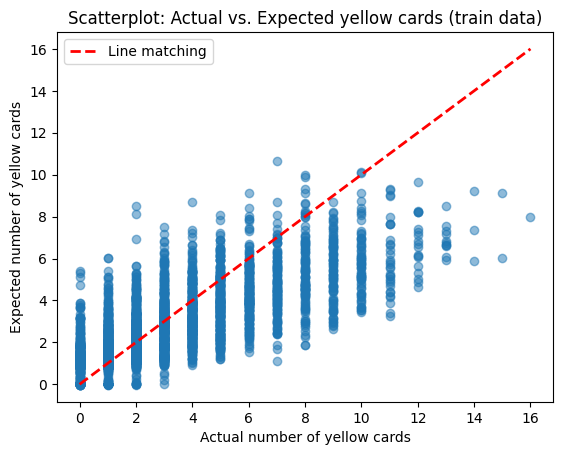

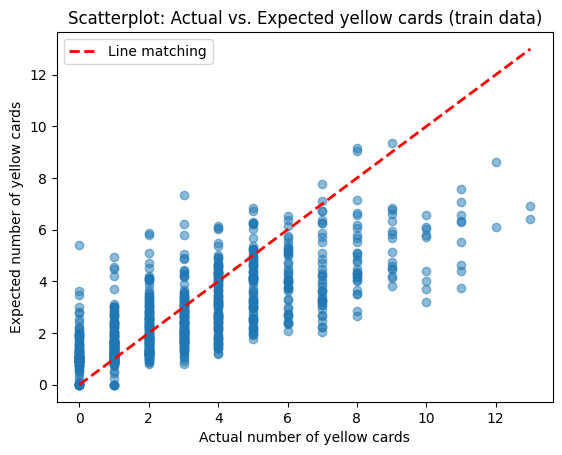

In [1061]:
generate_a_comparison_of_prediction_and_reality('yellow cards', predictions_df_1['CrdY'], predictions_df_1['krs2_p_CrdY'], 'train')
generate_a_comparison_of_prediction_and_reality('yellow cards', test_predictions_df_1['CrdY'], test_predictions_df_1['krs2_p_CrdY'], 'train')

Now let's move on to the last model - `DecisionTreeRegressor`

In [1062]:
dtr1 = DecisionTreeRegressor()
model77 = dtr1.fit(X_train, y_train)

r_sqr = dtr1.score(X_train, y_train)
print(f'r^2 = {r_sqr}')
print(f'params = {dtr1.get_params}')

r^2 = 1.0
params = <bound method BaseEstimator.get_params of DecisionTreeRegressor()>


Now let's make a prediction for our training data.

In [1063]:
predictions_df_1['dtr1_p_CrdY'] = model77.predict(X_train).flatten()
predictions_df_1

Player  Pos     Min   Fls   Fld   Int  TklW  Recov  CrdY  \
0       Thomas Müller    3  2558.0  11.0  22.0  15.0  20.0   94.0   0.0   
1        Manuel Neuer    1  2510.0   0.0   1.0   0.0   1.0   85.0   0.0   
2      Joshua Kimmich    3  2474.0  20.0  46.0  52.0  20.0  218.0   4.0   
3     Dayot Upamecano    2  2211.0  28.0  11.0  32.0  42.0  249.0   4.0   
4        Serge Gnabry    6  2185.0  11.0  21.0  14.0  31.0  146.0   0.0   
...               ...  ...     ...   ...   ...   ...   ...    ...   ...   
3420  Luca Fiordilino    3   661.0   5.0  10.0  11.0  13.0   50.0   2.0   
3421       Dor Peretz    3   585.0  10.0   8.0   8.0  18.0   25.0   2.0   
3422  Francesco Forte    4   422.0  11.0   7.0   0.0   2.0   14.0   3.0   
3423     Marco Modolo    2   392.0   6.0   3.0   4.0   3.0   19.0   2.0   
3424             Nani    7   287.0   2.0   8.0   2.0   1.0   20.0   1.0   

      lr_p_CrdY  xgbr_p_CrdY  lgbm1_p_CrdY  lgbm2_p_CrdY  krs1_p_CrdY  \
0      2.687454     0.575441      1.780699      2.053421     1.745175   
1      1.106807     0.025646      1.245144      0.501411     0.196272   
2      5.033358     4.254878      4.455744      4.272967     3.723741   
3      5.185488     4.114817      5.274376      4.310365     3.721553   
4      2.159950    -0.002485      0.974105      1.302827     1.127612   
...         ...          ...           ...           ...          ...   
3420   1.386705     1.644959      1.249192      1.480984     0.867862   
3421   1.831106     2.011050      1.604853      2.031186     1.628948   
3422   1.540548     1.992890      1.530462      1.493729     1.255467   
3423   1.327282     2.072019      1.567257      1.466908     1.178278   
3424   0.129117     0.519256      0.420793      0.439774    -0.143143   

      krs2_p_CrdY  dtr1_p_CrdY  
0        1.887098          0.0  
1        1.674552          0.0  
2        4.505623          4.0  
3        4.586601          4.0  
4        1.750225          0.0  
...           ...          ...  
3420     1.224555          2.0  
3421     1.516258          2.0  
3422     1.305703          3.0  
3423     1.134692          2.0  
3424     0.001487          1.0  

[3425 rows x 16 columns]

Let's now calculate the 2 main measures of our model's error for training data:


In [1064]:
mean_absolute_error(y_train, predictions_df_1['dtr1_p_CrdY']), mean_squared_error(y_train, predictions_df_1['dtr1_p_CrdY'])

(0.0, 0.0)

Now let's make a prediction for our testing data.

In [1065]:
test_predictions_df_1['dtr1_p_CrdY'] = model77.predict(X_test).flatten()

test_predictions_df_1

Player  Pos     Min  Fls  Fld  Int  TklW  Recov  CrdY  \
0                 Rodri    3  2911.0   47   20   33    41  301.0   5.0   
1        Erling Haaland    4  2769.0   31   24    3     2   37.0   5.0   
2       Kevin De Bruyne    3  2417.0   20   29    9    12   97.0   1.0   
3        İlkay Gündoğan    3  2353.0   22   25   20    18  155.0   0.0   
4         Manuel Akanji    2  2287.0   24   12   16    25  136.0   2.0   
..                  ...  ...     ...  ...  ...  ...   ...    ...   ...   
853      Gonzalo Villar    3   696.0   17   18    4     7   55.0   2.0   
854        Koray Günter    2   731.0    7    2   11     7   47.0   2.0   
855       Valerio Verre    3   677.0   14   13    9     7   61.0   5.0   
856  Fabio Quagliarella    4   628.0    4   18    0     1   25.0   2.0   
857        Nicola Murru    2   650.0   12    6    8    13   31.0   2.0   

     lr_p_CrdY  xgbr_p_CrdY  lgbm1_p_CrdY  lgbm2_p_CrdY  krs1_p_CrdY  \
0     7.500197    10.020272      8.631900     10.484989     6.398838   
1     4.561638     1.369111      3.433525      3.396009     4.570225   
2     3.570615     2.393644      3.324976      2.881410     2.565971   
3     4.109104     4.437050      5.120948      5.036146     3.512743   
4     4.244229     4.518568      5.361538      4.763816     3.788567   
..         ...          ...           ...           ...          ...   
853   2.628264     2.900242      3.141624      3.154168     2.599076   
854   1.726326     1.572734      1.392935      1.663254     1.360128   
855   2.400273     2.015562      2.113059      1.931106     2.184376   
856   0.848441     0.226073      0.957397      0.881647     0.678585   
857   2.209022     3.510860      2.408798      2.664880     2.003186   

     krs2_p_CrdY  dtr1_p_CrdY  
0       6.706838         13.0  
1       3.618921          2.0  
2       2.861037          1.0  
3       3.466417          7.0  
4       3.513282          4.0  
..           ...          ...  
853     2.300599          3.0  
854     1.381072          2.0  
855     2.094537          0.0  
856     0.869835          0.0  
857     1.832473          3.0  

[858 rows x 16 columns]

R² for our first `DecisionTreeRegressor` model for testing data is:

In [1066]:
r_sqr = dtr1.score(X_test, test_predictions_df_1['CrdY'])
print(f'r^2 = {r_sqr}')

r^2 = -0.06580542588144533


Let's now calculate the 2 main measures of our model's error for training data:


In [1067]:
mean_absolute_error(y_test, test_predictions_df_1['dtr1_p_CrdY']), mean_squared_error(y_test, test_predictions_df_1['dtr1_p_CrdY'])

(2.0221445221445222, 7.182983682983683)

And now to compare our results to reality.

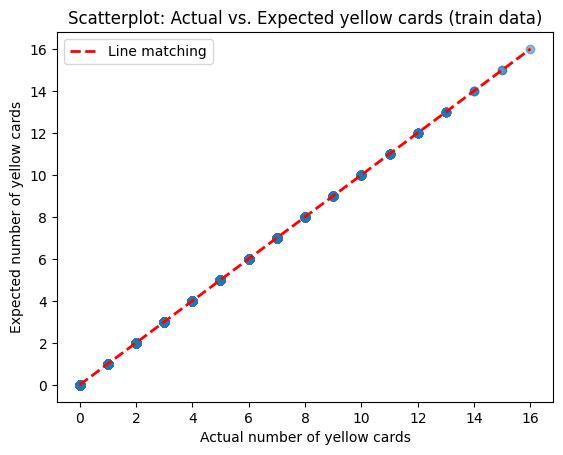

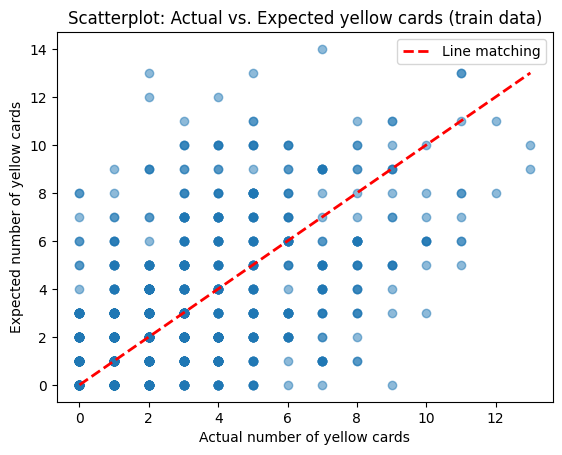

In [1068]:
generate_a_comparison_of_prediction_and_reality('yellow cards', predictions_df_1['CrdY'], predictions_df_1['dtr1_p_CrdY'], 'train')
generate_a_comparison_of_prediction_and_reality('yellow cards', test_predictions_df_1['CrdY'], test_predictions_df_1['dtr1_p_CrdY'], 'train')

As a reminder, I present the parameters that will be selected for our `DecisionTreeRegressor` model:

In [1069]:
param_grid = {
    'criterion': ['absolute_error', 'squared_error', 'friedman_mse'],
    'splitter' : ['random', 'best'],
    'max_depth' : [70, 80, 90, 100],
    'min_samples_split' : [50, 55, 60, 65, 70, 75],
    'min_impurity_decrease' : [0.0025, 0.005, 0.01]
}

gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
gridSearch.fit(X_train, y_train)
print('The best score: ', gridSearch.best_score_)
print('The best parameters: ', gridSearch.best_params_)

The best score:  -3.7456600185864835
The best parameters:  {'criterion': 'squared_error', 'max_depth': 80, 'min_impurity_decrease': 0.005, 'min_samples_split': 75, 'splitter': 'random'}


Now let's train the model for the best parameters on our training data.

In [1070]:
dtr2 = DecisionTreeRegressor(**gridSearch.best_params_)
model88 = dtr2.fit(X_train, y_train)

r_sqr = dtr2.score(X_train, y_train)
print(f'r^2 = {r_sqr}')

r^2 = 0.5434313258857305


Below we take the best parameter for our `DecisionTreeRegressor` model and train it on our training data.

In [1071]:
predictions_df_1['dtr2_p_CrdY'] = model88.predict(X_train).flatten()
predictions_df_1

Player  Pos     Min   Fls   Fld   Int  TklW  Recov  CrdY  \
0       Thomas Müller    3  2558.0  11.0  22.0  15.0  20.0   94.0   0.0   
1        Manuel Neuer    1  2510.0   0.0   1.0   0.0   1.0   85.0   0.0   
2      Joshua Kimmich    3  2474.0  20.0  46.0  52.0  20.0  218.0   4.0   
3     Dayot Upamecano    2  2211.0  28.0  11.0  32.0  42.0  249.0   4.0   
4        Serge Gnabry    6  2185.0  11.0  21.0  14.0  31.0  146.0   0.0   
...               ...  ...     ...   ...   ...   ...   ...    ...   ...   
3420  Luca Fiordilino    3   661.0   5.0  10.0  11.0  13.0   50.0   2.0   
3421       Dor Peretz    3   585.0  10.0   8.0   8.0  18.0   25.0   2.0   
3422  Francesco Forte    4   422.0  11.0   7.0   0.0   2.0   14.0   3.0   
3423     Marco Modolo    2   392.0   6.0   3.0   4.0   3.0   19.0   2.0   
3424             Nani    7   287.0   2.0   8.0   2.0   1.0   20.0   1.0   

      lr_p_CrdY  xgbr_p_CrdY  lgbm1_p_CrdY  lgbm2_p_CrdY  krs1_p_CrdY  \
0      2.687454     0.575441      1.780699      2.053421     1.745175   
1      1.106807     0.025646      1.245144      0.501411     0.196272   
2      5.033358     4.254878      4.455744      4.272967     3.723741   
3      5.185488     4.114817      5.274376      4.310365     3.721553   
4      2.159950    -0.002485      0.974105      1.302827     1.127612   
...         ...          ...           ...           ...          ...   
3420   1.386705     1.644959      1.249192      1.480984     0.867862   
3421   1.831106     2.011050      1.604853      2.031186     1.628948   
3422   1.540548     1.992890      1.530462      1.493729     1.255467   
3423   1.327282     2.072019      1.567257      1.466908     1.178278   
3424   0.129117     0.519256      0.420793      0.439774    -0.143143   

      krs2_p_CrdY  dtr1_p_CrdY  dtr2_p_CrdY  
0        1.887098          0.0     2.393617  
1        1.674552          0.0     1.766234  
2        4.505623          4.0     7.695652  
3        4.586601          4.0     5.518519  
4        1.750225          0.0     2.921053  
...           ...          ...          ...  
3420     1.224555          2.0     1.167939  
3421     1.516258          2.0     1.889706  
3422     1.305703          3.0     1.889706  
3423     1.134692          2.0     0.872414  
3424     0.001487          1.0     0.872414  

[3425 rows x 17 columns]

Let's now calculate the 2 main measures of our model's error for training data:


In [1072]:
mean_absolute_error(predictions_df_1['CrdY'], predictions_df_1['dtr2_p_CrdY']), mean_squared_error(predictions_df_1['CrdY'], predictions_df_1['dtr2_p_CrdY'])

(1.4342490378592458, 3.5798403657247)

Now let's make a prediction for our testing data.

In [1073]:
test_predictions_df_1['dtr2_p_CrdY'] = model88.predict(X_test).flatten()

test_predictions_df_1

Player  Pos     Min  Fls  Fld  Int  TklW  Recov  CrdY  \
0                 Rodri    3  2911.0   47   20   33    41  301.0   5.0   
1        Erling Haaland    4  2769.0   31   24    3     2   37.0   5.0   
2       Kevin De Bruyne    3  2417.0   20   29    9    12   97.0   1.0   
3        İlkay Gündoğan    3  2353.0   22   25   20    18  155.0   0.0   
4         Manuel Akanji    2  2287.0   24   12   16    25  136.0   2.0   
..                  ...  ...     ...  ...  ...  ...   ...    ...   ...   
853      Gonzalo Villar    3   696.0   17   18    4     7   55.0   2.0   
854        Koray Günter    2   731.0    7    2   11     7   47.0   2.0   
855       Valerio Verre    3   677.0   14   13    9     7   61.0   5.0   
856  Fabio Quagliarella    4   628.0    4   18    0     1   25.0   2.0   
857        Nicola Murru    2   650.0   12    6    8    13   31.0   2.0   

     lr_p_CrdY  xgbr_p_CrdY  lgbm1_p_CrdY  lgbm2_p_CrdY  krs1_p_CrdY  \
0     7.500197    10.020272      8.631900     10.484989     6.398838   
1     4.561638     1.369111      3.433525      3.396009     4.570225   
2     3.570615     2.393644      3.324976      2.881410     2.565971   
3     4.109104     4.437050      5.120948      5.036146     3.512743   
4     4.244229     4.518568      5.361538      4.763816     3.788567   
..         ...          ...           ...           ...          ...   
853   2.628264     2.900242      3.141624      3.154168     2.599076   
854   1.726326     1.572734      1.392935      1.663254     1.360128   
855   2.400273     2.015562      2.113059      1.931106     2.184376   
856   0.848441     0.226073      0.957397      0.881647     0.678585   
857   2.209022     3.510860      2.408798      2.664880     2.003186   

     krs2_p_CrdY  dtr1_p_CrdY  dtr2_p_CrdY  
0       6.706838         13.0     8.323944  
1       3.618921          2.0     4.527027  
2       2.861037          1.0     2.393617  
3       3.466417          7.0     3.518519  
4       3.513282          4.0     2.921053  
..           ...          ...          ...  
853     2.300599          3.0     3.017094  
854     1.381072          2.0     1.167939  
855     2.094537          0.0     2.371747  
856     0.869835          0.0     1.167939  
857     1.832473          3.0     2.371747  

[858 rows x 17 columns]

R² for our second `DecisionTreeregressor` for testing data is:

In [1074]:
r_sqr = dtr2.score(X_test, test_predictions_df_1['CrdY'])
print(f'r^2 = {r_sqr}')

r^2 = 0.505883392183487


And now to compare our results to reality.

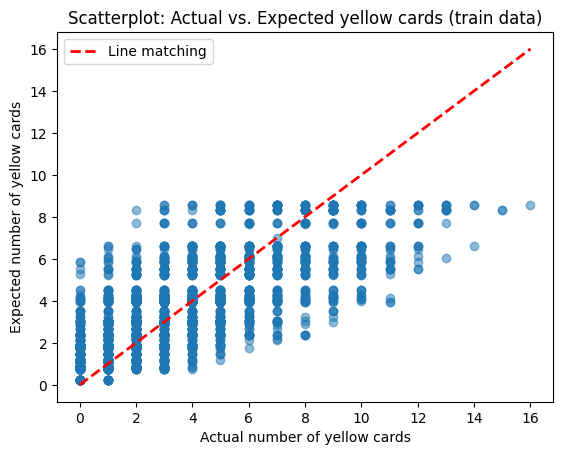

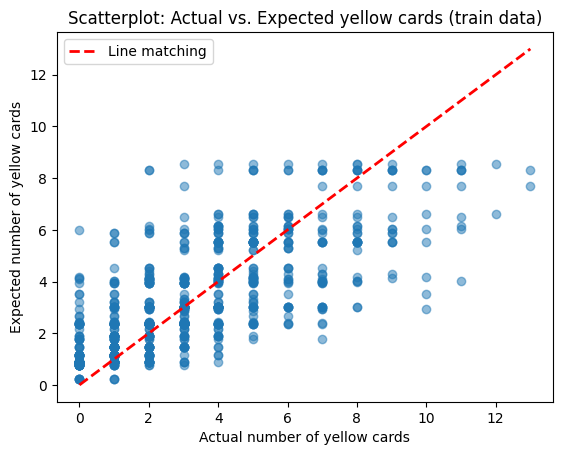

In [1075]:
generate_a_comparison_of_prediction_and_reality('yellow cards', predictions_df_1['CrdY'], predictions_df_1['dtr2_p_CrdY'], 'train')
generate_a_comparison_of_prediction_and_reality('yellow cards', test_predictions_df_1['CrdY'], test_predictions_df_1['dtr2_p_CrdY'], 'train')

Let us now summarize the results of our models

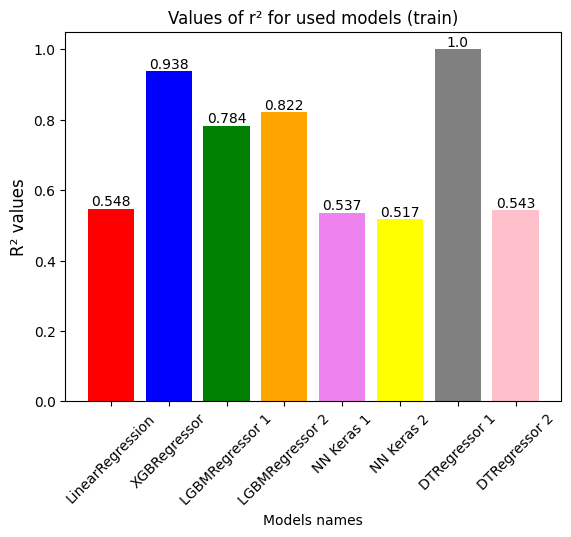

<Figure size 640x480 with 0 Axes>

In [1076]:
NAMES_OF_PREDICTIONS_COLUMNS_1 = [column_name[:-3] for column_name in NAMES_OF_PREDICTIONS_COLUMNS]

train_r2_score_list_1 = get_all_r2_values(NAMES_OF_PREDICTIONS_COLUMNS_1, y_train, predictions_df_1)

plt.bar(models_names, train_r2_score_list_1, color=colors)

plt.title('Values of r² for used models (train)')
plt.xticks(rotation=45)
plt.xlabel('Models names')
plt.ylabel('R² values',  fontsize=12, va='bottom')


add_values_on_diagram_bars(plt.gca())
plt.show()

plt.savefig('./diagrams/r2_crdY_train.png')

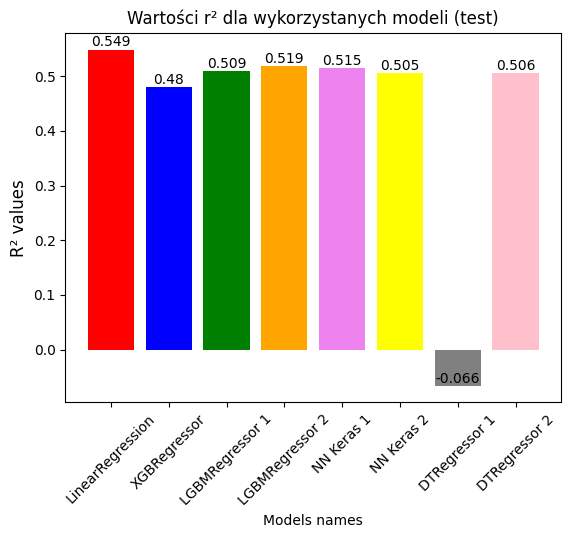

<Figure size 640x480 with 0 Axes>

In [1077]:
test_r2_score_list_1 = get_all_r2_values(NAMES_OF_PREDICTIONS_COLUMNS_1, y_test, test_predictions_df_1)

plt.bar(models_names, test_r2_score_list_1, color=colors)


plt.title('Wartości r² dla wykorzystanych modeli (test)')
plt.xticks(rotation=45)
plt.xlabel('Models names')
plt.ylabel('R² values',  fontsize=12, va='bottom')

add_values_on_diagram_bars(plt.gca())
plt.show()

plt.savefig('./diagrams/r2_crdY_test.png')

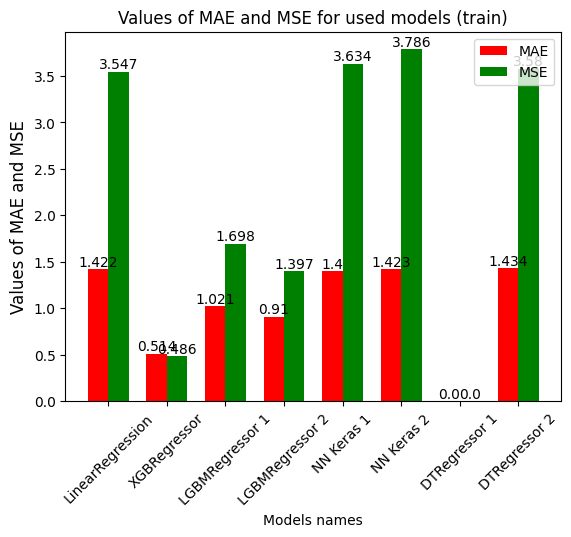

<Figure size 640x480 with 0 Axes>

In [1078]:
train_mse_score_list_1 = get_all_mse_values(NAMES_OF_PREDICTIONS_COLUMNS_1, y_train, predictions_df_1)
train_mae_score_list_1 = get_all_mae_values(NAMES_OF_PREDICTIONS_COLUMNS_1, y_train, predictions_df_1)

indexes = np.arange(len(models_names))

plt.bar(indexes, train_mae_score_list_1, width, color=['red'], label='MAE')
plt.bar(indexes + width, train_mse_score_list_1, width, color=['green'], label='MSE')


plt.title('Values of MAE and MSE for used models (train)')
plt.xticks(indexes + width/2, models_names, rotation=45)
plt.xlabel('Models names')
plt.ylabel('Values of MAE and MSE',  fontsize=12, va='bottom')
plt.legend()

add_values_on_diagram_bars(plt.gca())
plt.show()

plt.savefig('./diagrams/mae_mse_crdY_train.png')

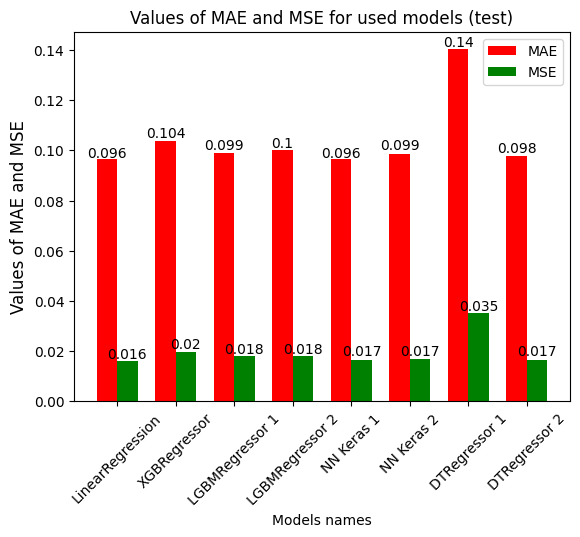

<Figure size 640x480 with 0 Axes>

In [1079]:
test_mse_score_list_1 = get_all_mse_values(NAMES_OF_PREDICTIONS_COLUMNS_1, y_test, test_predictions_df_1)
test_mae_score_list_1 = get_all_mae_values(NAMES_OF_PREDICTIONS_COLUMNS_1, y_test, test_predictions_df_1)


plt.bar(indexes, test_mae_score_list, width, color=['red'], label='MAE')
plt.bar(indexes + width, test_mse_score_list, width, color=['green'], label='MSE')


plt.title('Values of MAE and MSE for used models (test)')
plt.xticks(indexes + width/2, models_names, rotation=45)
plt.xlabel('Models names')
plt.ylabel('Values of MAE and MSE',  fontsize=12, va='bottom')
plt.legend()
add_values_on_diagram_bars(plt.gca())
plt.show()

plt.savefig('./diagrams/mae_mse_crdY_test.png')


Now let's calculate the median value for the number of yellow cards scored by all players for the training data

In [1080]:
median_crdY = predictions_df_1['CrdY'].median()
median_crdY

3.0

Now, for each model, let's calculate what fraction of the average number of yellow cards  is due to their MAE and MSE errors.

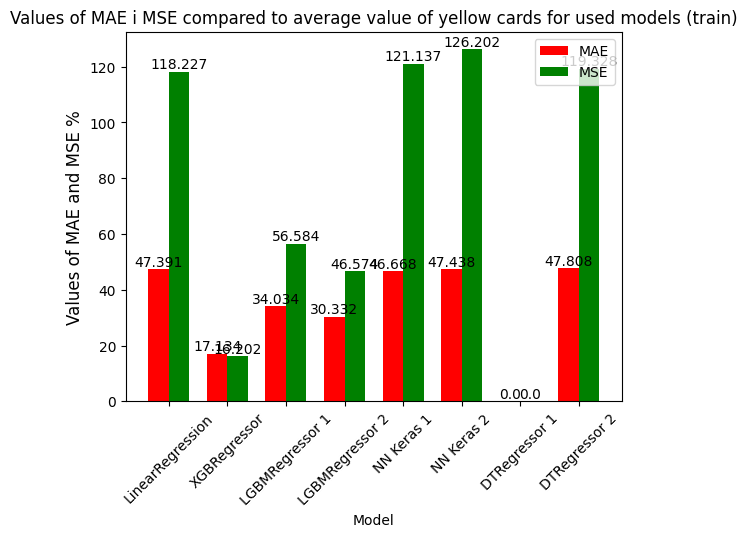

<Figure size 640x480 with 0 Axes>

In [1081]:
compared_to_prediction_mae_train_1 = [error/median_crdY * 100 for error in train_mae_score_list_1]

compared_to_prediction_mse_train_1 = [error/median_crdY  * 100 for error in train_mse_score_list_1]

indexes = np.arange(len(models_names))

width = 0.35

plt.bar(indexes, compared_to_prediction_mae_train_1, width, color=['red'], label='MAE')
plt.bar(indexes + width, compared_to_prediction_mse_train_1, width, color=['green'], label='MSE')


plt.title('Values of MAE i MSE compared to average value of yellow cards for used models (train)')
plt.xticks(indexes + width/2, models_names, rotation=45)
plt.xlabel('Model')
plt.ylabel('Values of MAE and MSE %',  fontsize=12, va='bottom')
plt.legend()

add_values_on_diagram_bars(plt.gca())
plt.show()

plt.savefig('./diagrams/compared_mae_mse_crdY_train.png')

Also in this case, the `MSE` does not give adequate information about the fit of our model. So let's see what the situation looks like for the `MAE` itself.

For the training data alone, the smallest error is 0% for the first `DecisionTreeRegressor` model, but the others give errors of 15% to almost 44% of the average yellow cards scored per season, which does not speak well of the quality of our models and their predictions.

Let's check what the situation looks like for our test data, because this will be the most important criterion for choosing the best model and confirming or rejecting our main hypothesis.

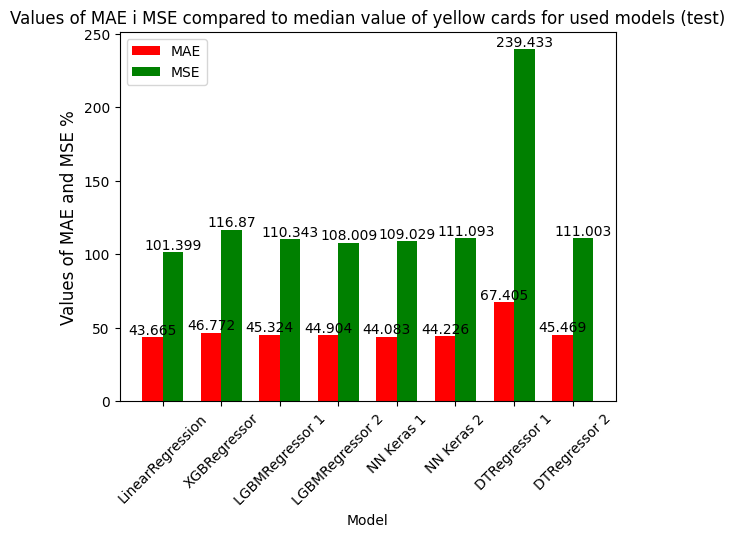

<Figure size 640x480 with 0 Axes>

In [1082]:
median_crdY = test_predictions_df_1['CrdY'].median()

compared_to_prediction_mae_test_1 = [error/median_crdY * 100 for error in test_mae_score_list_1]

compared_to_prediction_mse_test_1 = [error/median_crdY  * 100 for error in test_mse_score_list_1]

indexes = np.arange(len(models_names))

width = 0.35

plt.bar(indexes, compared_to_prediction_mae_test_1, width, color=['red'], label='MAE')
plt.bar(indexes + width, compared_to_prediction_mse_test_1, width, color=['green'], label='MSE')


plt.title('Values of MAE i MSE compared to median value of yellow cards for used models (test)')
plt.xticks(indexes + width/2, models_names, rotation=45)
plt.xlabel('Model')
plt.ylabel('Values of MAE and MSE %',  fontsize=12, va='bottom')
plt.legend()

add_values_on_diagram_bars(plt.gca())
plt.show()

plt.savefig('./diagrams/compared_mae_mse_crdY_test.png')

As the graph above shows us, the best model for the training data - first `DecisionTreeRegressor` model - turned out to be the worst for the test data. This is probably due to excessive overtraining of the model and too much adjustment to the training data.

The other models keep the error at 40% of the average number of yellow cards and ultimately gives us the answer that the yellow card data is quite unpredictable and difficult to predict based on player statistics.

In [1083]:
predictions_df_1.to_csv('./checkpoints/prediction_df_1.csv')
test_predictions_df_1.to_csv('./checkpoints/test_prediction_df_1.csv')



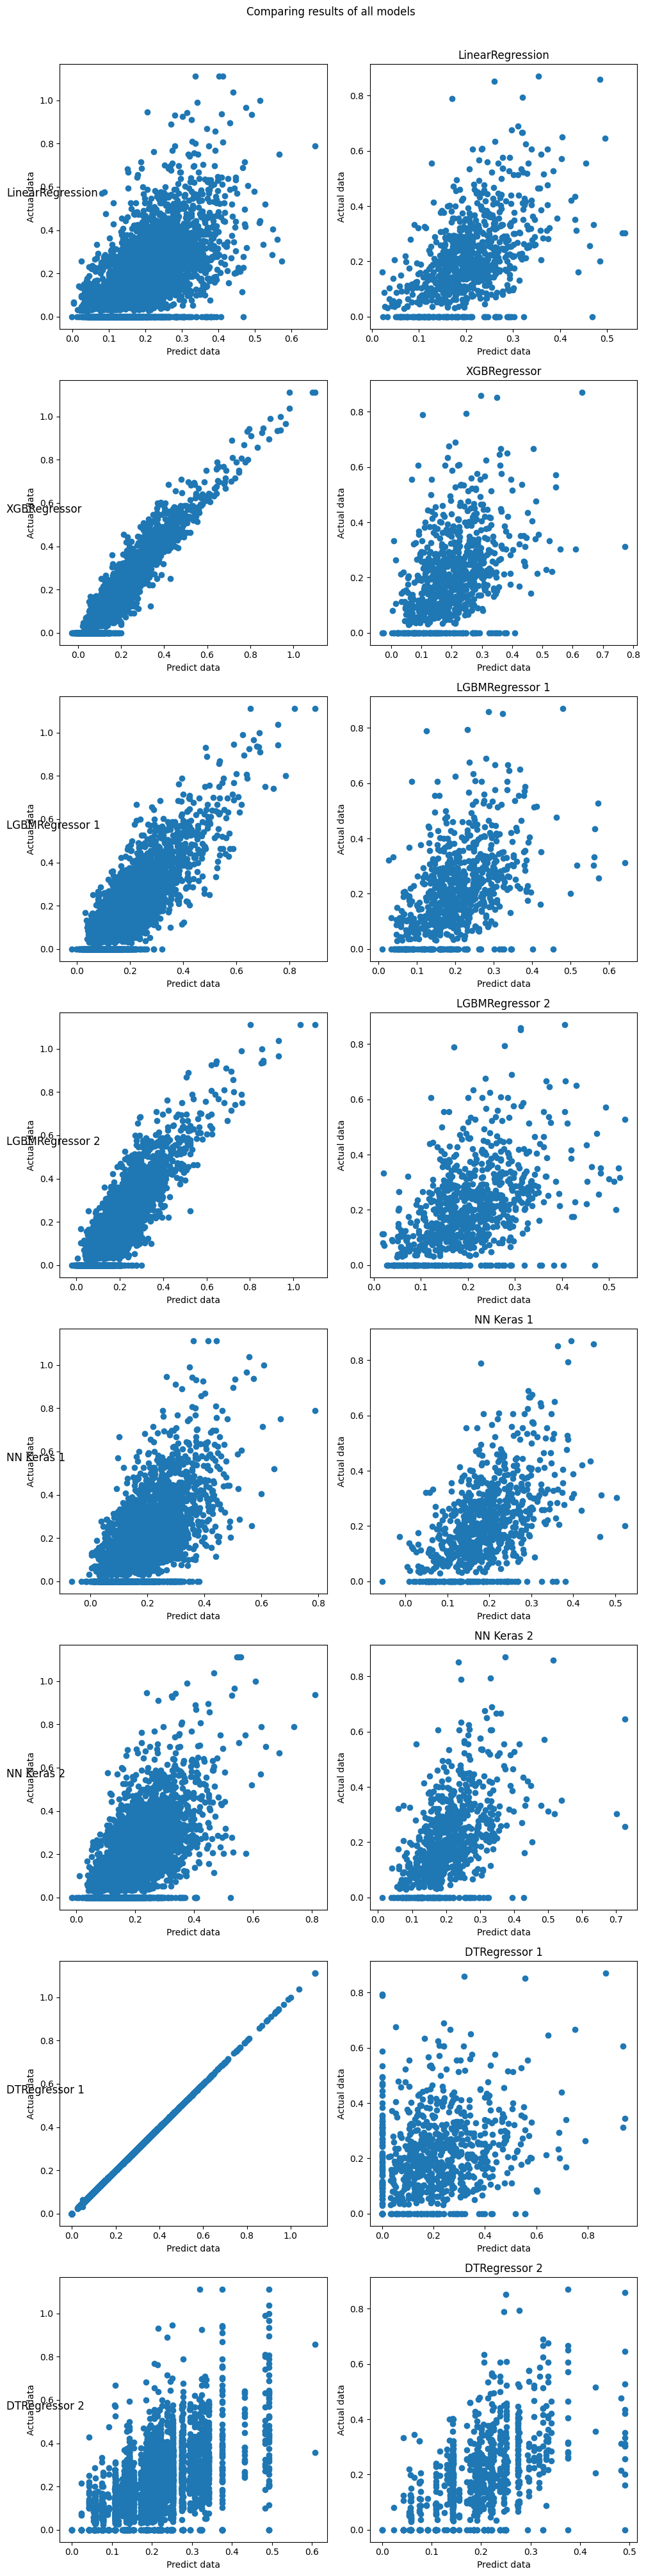

In [1106]:

def generate_diagram_grid(titles, models_short, train_prediction, test_prediction, y_name, suptitle):

    fig, axes = plt.subplots(len(titles), 2, figsize=(10,5 * len(titles)))
    fig.suptitle(suptitle, y=1.005)


    for i, (name, model_short) in enumerate(zip(titles, models_short)):

        axes[i][0].scatter(train_prediction[model_short], train_prediction[y_name])
        axes[i][0].set_title(name, fontsize=12, loc='center')
        axes[i][0].set_xlabel('Predict data', fontsize=10)
        axes[i][0].set_ylabel('Actual data', fontsize=10)

        axes[i][1].scatter(test_prediction[model_short], test_prediction[y_name])
        axes[i][1].set_title(name, fontsize=12, loc='center')
        axes[i][1].set_xlabel('Predict data', fontsize=10)
        axes[i][1].set_ylabel('Actual data', fontsize=10)


    fig.subplots_adjust(hspace=0.5, wspace=0.5) 
    plt.tight_layout() 

    plt.show()

generate_diagram_grid(models_names, NAMES_OF_PREDICTIONS_COLUMNS, predictions_df, test_predictions_df, 'CrdY/90', 'Comparing results of all models')

In [1108]:
def predict_and_print_statistics(models, models_name, models_shortcuts, X_train, y_train, X_test, y_test, train_predictions_df, test_predictions_df):
    for model, shortcut, name in zip(models, models_shortcuts, models_name):
        print(f'Statistic for {name}')

        train_predictions_df[shortcut] = model.predict(X_train).flatten()

        print(f'Train r²: {r2_score(y_train, train_predictions_df[shortcut])}')
        print(f'Train MAE: {mean_absolute_error(y_train, train_predictions_df[shortcut])}')
        print(f'Train MSE: {mean_squared_error(y_train, train_predictions_df[shortcut])}')

        test_predictions_df[shortcut] = model.predict(X_test).flatten()

        print(f'Test r²: {r2_score(y_test, test_predictions_df[shortcut])}')
        print(f'Test MAE: {mean_absolute_error(y_test, test_predictions_df[shortcut])}')
        print(f'Test MSE: {mean_squared_error(y_test, test_predictions_df[shortcut])}')

        print('------------------------')

    return train_predictions_df, test_predictions_df


df1, df2 = predict_and_print_statistics([model11], ['LinearRegression'], ['test_lr_p_CrdY'], X_train, y_train, X_test, y_test, pd.DataFrame(), pd.DataFrame())

Statistic for LinearRegression
Train r²: 0.5476446686249803
Train MAE: 1.4217204682277602
Train MSE: 3.5468046029407985
Test r²: 0.5486357151139903
Test MAE: 1.309958552487941
Test MSE: 3.041964522498542
------------------------


7


c:\Users\trine\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


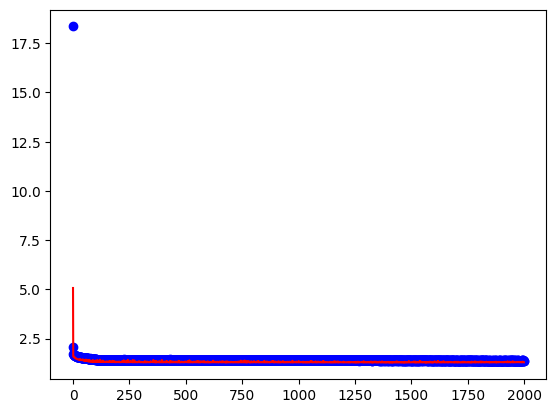

In [1119]:
def make_neural_network(X_train, y_train, X_test, y_test, earlystopper=None):
    print(len(X_train.columns))
    model = Sequential()
    model.add(Dense(13, input_shape=(len(X_train.columns),), activation='relu'))
    model.add(Dense(13, activation='relu'))
    model.add(Dense(13, activation='relu'))
    model.add(Dense(13, activation='relu'))
    model.add(Dense(13, activation='relu'))
    model.add(Dense(1,))
    model.compile(Adam(lr=0.0001), 'mean_absolute_error')

    if earlystopper != None:
        model_hist = model.fit(X_train, y_train, epochs = 2000, validation_split = 0, validation_data=(X_test, y_test), verbose = 0, callbacks=[earlystopper])
    else:
        model_hist = model.fit(X_train, y_train, epochs = 2000, validation_split = 0, validation_data=(X_test, y_test), verbose = 0)

    model_dict = model_hist.history
    loss_values = model_dict['loss']
    val_loss_values = model_dict['val_loss']
    plt.plot(loss_values,'bo',label='training loss')
    plt.plot(val_loss_values,'r',label='training loss val')

    return model

make_neural_network(X_train, y_train, X_test, y_test)